In [1]:
import pandas as pd
# import scprep as sc
import scanpy as sc
import phate
import numpy as np
import seaborn as sns
import scprep
from sklearn.metrics import roc_auc_score, average_precision_score
import os
from tqdm import tqdm
import warnings


In [2]:
from tqdm import tqdm
import warnings
## KPSS Null hypothesis: there is a no unit root, meaning series is stationary
from statsmodels.tsa.stattools import kpss


def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f"KPSS Statistic: {statistic}")
    print(f"p-value: {p_value}")
    print(f"num lags: {n_lags}")
    print("Critial Values:")
    for key, value in critical_values.items():
        print(f"   {key} : {value}")
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')


from statsmodels.tsa.stattools import grangercausalitytests

lag_order = 1
maxlag = (
    lag_order,  # becuase we got this value before. We are not suppose to add 1 to it
)
test = "ssr_chi2test"

from joblib import Parallel, delayed

def grangers_causation_matrix(
    data, in_variables, out_variables, test="ssr_chi2test", n_jobs=1, warn=False
):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """

    def get_pval(dd):
        if warn:
            test_result = grangercausalitytests(dd, maxlag=maxlag, verbose=True)
        else:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=FutureWarning)
                test_result = grangercausalitytests(dd, maxlag=maxlag, verbose=False)
                # according to the documentation https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.grangercausalitytests.html,
                # the dd has 2 columns, second causes the first.
        p_values = [test_result[i][0][test][1] for i in maxlag]
        min_p_value = np.min(p_values)
        return min_p_value

    out = Parallel(n_jobs=n_jobs)(
        # delayed(get_pval)(data[[r, c]]) # this is incorrect
        delayed(get_pval)(data[[c, r]]) # this means r causes c, so r is be in and c is out
        for c in tqdm(out_variables, desc="Processing columns")  # Outer loop progress bar
        for r in tqdm(in_variables, desc="Processing rows", leave=False)  # Inner loop progress bar
    )
    # Note that this is the wrong way and must be corrected
    # df = pd.DataFrame(
    #     np.array(out).reshape((len(in_variables), len(out_variables))), # this is incorrect
    #     columns=out_variables,
    #     index=in_variables,
    # )
    df = pd.DataFrame(
        np.array(out).reshape((len(out_variables), len(in_variables))), # should be reshaped to len(out_variables), len(in_variables) according to the for loop.
        columns=in_variables,
        index=out_variables,
    ).T # used the correct reshaping, and then transposed the matrix so the x and y are semantically correct (x causes y).
    df.index = [var + "_x" for var in in_variables]
    df.columns = [var + "_y" for var in out_variables]
    return df

def do_granger(trajs, in_genes, out_genes, n_jobs=1, warn=False):
    # in causes out
    # trajs = trajs.T[::10]
    trajs = trajs.T # do not shorten it
    trajs = trajs - trajs.shift(1)
    trajs = trajs.dropna()
    out_traj = grangers_causation_matrix(
        trajs, in_variables=in_genes, out_variables=out_genes, n_jobs=n_jobs, warn=warn
    )
    return out_traj

In [3]:
# traj_gene_sp = np.load("../data_human_samples/10-trajectories_gene_space.npy")
traj_gene_sp = np.load(f"../results_final_Dec22/traj_gene_space_T.npy", allow_pickle=True)

In [4]:
adata = sc.read_h5ad('../data/rna_figure_ready.h5ad')

In [5]:
# sc.pp.highly_variable_genes(adata, n_top_genes=400)
alex_genes = open('../data/alex_genes.txt').read().splitlines()
alex_tfs = open('../data/alex_tfs.txt').read().splitlines()

In [6]:
# gene_mask = np.isin(adata.var_names, alex_genes)
# tf_mask = np.isin(adata.var_names, alex_tfs)

In [7]:
alex_gene_all = list(set(alex_genes) | set(alex_tfs))
alex_gene_all_mask = np.isin(adata.var_names, alex_gene_all)
traj_subset = traj_gene_sp[:, :, alex_gene_all_mask]
gene_names = adata.var_names[alex_gene_all_mask]

In [8]:
traj_subset.shape

(100, 80, 2226)

In [9]:
# traj_df = pd.DataFrame(np.transpose(traj_subset, (1, 0, 2)).mean(axis=0), columns=gene_names)
data = np.transpose(traj_subset, (1, 0, 2))
valid_mask = (data.mean(axis=0).var(axis=0) != 0.0)
data = data[:, :, valid_mask]
gene_names = np.array(gene_names)[valid_mask]
traj_df = pd.DataFrame(data.mean(axis=0), columns=gene_names)

In [10]:
gm = do_granger(traj_df.T, in_genes=alex_tfs, out_genes=alex_genes, n_jobs=-1)

Processing columns:   0%|          | 0/1970 [00:00<?, ?it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:   5%|▍         | 16/331 [00:00<00:18, 16.79it/s]

Processing rows:  31%|███▏      | 104/331 [00:01<00:01, 127.04it/s]

Processing rows:  80%|███████▉  | 264/331 [00:01<00:00, 342.71it/s]

Processing columns:   0%|          | 1/1970 [00:01<40:43,  1.24s/it]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 209/331 [00:00<00:00, 2088.99it/s]

Processing columns:   0%|          | 2/1970 [00:01<20:35,  1.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 223/331 [00:00<00:00, 2228.22it/s]

Processing columns:   0%|          | 3/1970 [00:01<13:42,  2.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 2257.31it/s]

Processing columns:   0%|          | 4/1970 [00:01<10:27,  3.14it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▋   | 220/331 [00:00<00:00, 2175.49it/s]

Processing columns:   0%|          | 5/1970 [00:01<08:45,  3.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2233.17it/s]

Processing columns:   0%|          | 6/1970 [00:02<07:29,  4.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2128.30it/s]

Processing columns:   0%|          | 7/1970 [00:02<06:59,  4.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2332.07it/s]

Processing columns:   0%|          | 8/1970 [00:02<06:32,  5.00it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2404.49it/s]

Processing columns:   0%|          | 9/1970 [00:02<06:02,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1949.21it/s]

Processing columns:   1%|          | 10/1970 [00:02<05:57,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2359.47it/s]

Processing columns:   1%|          | 11/1970 [00:02<05:47,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 218/331 [00:00<00:00, 2179.50it/s]

Processing columns:   1%|          | 12/1970 [00:03<06:03,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2032.88it/s]

Processing columns:   1%|          | 13/1970 [00:03<06:04,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2361.42it/s]

Processing columns:   1%|          | 14/1970 [00:03<06:05,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2136.76it/s]

Processing columns:   1%|          | 15/1970 [00:03<05:46,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2002.77it/s]

Processing columns:   1%|          | 16/1970 [00:03<05:57,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2339.16it/s]

Processing columns:   1%|          | 17/1970 [00:04<05:34,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2044.41it/s]

Processing columns:   1%|          | 18/1970 [00:04<05:43,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  29%|██▉       | 97/331 [00:00<00:00, 481.73it/s]

Processing rows:  89%|████████▉ | 295/331 [00:00<00:00, 1102.34it/s]

Processing columns:   1%|          | 19/1970 [00:04<07:38,  4.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2356.63it/s]

Processing columns:   1%|          | 20/1970 [00:04<06:44,  4.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2015.87it/s]

Processing columns:   1%|          | 21/1970 [00:04<06:30,  4.99it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2018.17it/s]

Processing columns:   1%|          | 22/1970 [00:05<06:16,  5.18it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 219/331 [00:00<00:00, 2181.80it/s]

Processing columns:   1%|          | 23/1970 [00:05<05:54,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2016.43it/s]

Processing columns:   1%|          | 24/1970 [00:05<06:06,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2385.50it/s]

Processing columns:   1%|▏         | 25/1970 [00:05<06:20,  5.11it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.54it/s]

Processing columns:   1%|▏         | 26/1970 [00:05<06:01,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2036.51it/s]

Processing columns:   1%|▏         | 27/1970 [00:06<05:56,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2358.49it/s]

Processing columns:   1%|▏         | 28/1970 [00:06<05:46,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 222/331 [00:00<00:00, 2211.07it/s]

Processing columns:   1%|▏         | 29/1970 [00:06<05:34,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1912.92it/s]

Processing columns:   2%|▏         | 30/1970 [00:06<05:58,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2359.75it/s]

Processing columns:   2%|▏         | 31/1970 [00:06<05:52,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.43it/s]

Processing columns:   2%|▏         | 32/1970 [00:06<05:33,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 176/331 [00:00<00:00, 1754.69it/s]

Processing columns:   2%|▏         | 33/1970 [00:07<06:02,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2359.93it/s]

Processing columns:   2%|▏         | 34/1970 [00:07<05:37,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1934.05it/s]

Processing columns:   2%|▏         | 35/1970 [00:07<05:46,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2122.71it/s]

Processing columns:   2%|▏         | 36/1970 [00:07<06:04,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2378.24it/s]

Processing columns:   2%|▏         | 37/1970 [00:07<05:37,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2044.64it/s]

Processing columns:   2%|▏         | 38/1970 [00:08<06:56,  4.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 2060.77it/s]

Processing columns:   2%|▏         | 39/1970 [00:08<07:01,  4.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2385.79it/s]

Processing columns:   2%|▏         | 40/1970 [00:08<06:17,  5.12it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2026.48it/s]

Processing columns:   2%|▏         | 41/1970 [00:08<06:06,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.06it/s]

Processing columns:   2%|▏         | 42/1970 [00:08<05:57,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 2291.99it/s]

Processing columns:   2%|▏         | 43/1970 [00:08<05:37,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1994.78it/s]

Processing columns:   2%|▏         | 44/1970 [00:09<05:41,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2377.36it/s]

Processing columns:   2%|▏         | 45/1970 [00:09<05:47,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 180/331 [00:00<00:00, 1799.48it/s]

Processing columns:   2%|▏         | 46/1970 [00:09<05:41,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1997.32it/s]

Processing columns:   2%|▏         | 47/1970 [00:09<05:43,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2288.49it/s]

Processing columns:   2%|▏         | 48/1970 [00:09<05:39,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2361.67it/s]

Processing columns:   2%|▏         | 49/1970 [00:10<05:27,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1944.76it/s]

Processing columns:   3%|▎         | 50/1970 [00:10<05:32,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2388.52it/s]

Processing columns:   3%|▎         | 51/1970 [00:10<05:14,  6.10it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1916.83it/s]

Processing columns:   3%|▎         | 52/1970 [00:10<05:27,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2033.70it/s]

Processing columns:   3%|▎         | 53/1970 [00:10<06:05,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2351.07it/s]

Processing columns:   3%|▎         | 54/1970 [00:10<05:38,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2005.14it/s]

Processing columns:   3%|▎         | 55/1970 [00:11<05:40,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2069.93it/s]

Processing columns:   3%|▎         | 56/1970 [00:11<06:04,  5.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2360.74it/s]

Processing columns:   3%|▎         | 57/1970 [00:11<05:40,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2128.41it/s]

Processing columns:   3%|▎         | 58/1970 [00:11<06:52,  4.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2394.10it/s]

Processing columns:   3%|▎         | 59/1970 [00:11<06:27,  4.93it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.20it/s]

Processing columns:   3%|▎         | 60/1970 [00:12<05:57,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2122.35it/s]

Processing columns:   3%|▎         | 61/1970 [00:12<05:51,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2361.82it/s]

Processing columns:   3%|▎         | 62/1970 [00:12<05:46,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2390.70it/s]

Processing columns:   3%|▎         | 63/1970 [00:12<05:26,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2012.34it/s]

Processing columns:   3%|▎         | 64/1970 [00:12<05:40,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2366.12it/s]

Processing columns:   3%|▎         | 65/1970 [00:12<05:51,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2372.08it/s]

Processing columns:   3%|▎         | 66/1970 [00:13<06:05,  5.22it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1909.47it/s]

Processing columns:   3%|▎         | 67/1970 [00:13<05:57,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.73it/s]

Processing columns:   3%|▎         | 68/1970 [00:13<05:36,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 176/331 [00:00<00:00, 1757.16it/s]

Processing columns:   4%|▎         | 69/1970 [00:13<05:36,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 222/331 [00:00<00:00, 2212.03it/s]

Processing columns:   4%|▎         | 70/1970 [00:13<05:44,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2386.39it/s]

Processing columns:   4%|▎         | 71/1970 [00:14<05:34,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2022.73it/s]

Processing columns:   4%|▎         | 72/1970 [00:14<05:36,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.87it/s]

Processing columns:   4%|▎         | 73/1970 [00:14<05:59,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.44it/s]

Processing columns:   4%|▍         | 74/1970 [00:14<05:37,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1995.09it/s]

Processing columns:   4%|▍         | 75/1970 [00:14<05:54,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2341.58it/s]

Processing columns:   4%|▍         | 76/1970 [00:14<05:48,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2351.65it/s]

Processing columns:   4%|▍         | 77/1970 [00:15<05:29,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  31%|███▏      | 104/331 [00:00<00:00, 596.35it/s]

Processing rows:  92%|█████████▏| 303/331 [00:00<00:00, 1223.44it/s]

Processing columns:   4%|▍         | 78/1970 [00:15<06:48,  4.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2336.95it/s]

Processing columns:   4%|▍         | 79/1970 [00:15<06:24,  4.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2378.28it/s]

Processing columns:   4%|▍         | 80/1970 [00:15<05:54,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 209/331 [00:00<00:00, 2082.86it/s]

Processing columns:   4%|▍         | 81/1970 [00:15<05:48,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2244.76it/s]

Processing columns:   4%|▍         | 82/1970 [00:16<05:28,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2045.12it/s]

Processing columns:   4%|▍         | 83/1970 [00:16<05:32,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1978.08it/s]

Processing columns:   4%|▍         | 84/1970 [00:16<05:47,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2393.71it/s]

Processing columns:   4%|▍         | 85/1970 [00:16<05:23,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2034.93it/s]

Processing columns:   4%|▍         | 86/1970 [00:16<05:28,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2021.98it/s]

Processing columns:   4%|▍         | 87/1970 [00:17<05:48,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2341.63it/s]

Processing columns:   4%|▍         | 88/1970 [00:17<05:29,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2017.64it/s]

Processing columns:   5%|▍         | 89/1970 [00:17<05:42,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2333.97it/s]

Processing columns:   5%|▍         | 90/1970 [00:17<05:51,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2385.55it/s]

Processing columns:   5%|▍         | 91/1970 [00:17<05:45,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2032.31it/s]

Processing columns:   5%|▍         | 92/1970 [00:17<05:56,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2354.04it/s]

Processing columns:   5%|▍         | 93/1970 [00:18<05:47,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2303.10it/s]

Processing columns:   5%|▍         | 94/1970 [00:18<05:29,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2011.60it/s]

Processing columns:   5%|▍         | 95/1970 [00:18<05:32,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2313.30it/s]

Processing columns:   5%|▍         | 96/1970 [00:18<05:28,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1843.60it/s]

Processing columns:   5%|▍         | 97/1970 [00:18<05:54,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  18%|█▊        | 59/331 [00:00<00:00, 326.21it/s]

Processing rows:  78%|███████▊  | 257/331 [00:00<00:00, 1055.33it/s]

Processing columns:   5%|▍         | 98/1970 [00:19<07:18,  4.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.59it/s]

Processing columns:   5%|▌         | 99/1970 [00:19<06:28,  4.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2013.05it/s]

Processing columns:   5%|▌         | 100/1970 [00:19<06:13,  5.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2123.42it/s]

Processing columns:   5%|▌         | 101/1970 [00:19<06:05,  5.11it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2335.64it/s]

Processing columns:   5%|▌         | 102/1970 [00:19<05:38,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1945.26it/s]

Processing columns:   5%|▌         | 103/1970 [00:20<05:37,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 219/331 [00:00<00:00, 2055.81it/s]

Processing columns:   5%|▌         | 104/1970 [00:20<05:38,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2007.85it/s]

Processing columns:   5%|▌         | 105/1970 [00:20<05:27,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1927.50it/s]

Processing columns:   5%|▌         | 106/1970 [00:20<05:28,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.87it/s]

Processing columns:   5%|▌         | 107/1970 [00:20<05:24,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.08it/s]

Processing columns:   5%|▌         | 108/1970 [00:20<05:12,  5.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2034.85it/s]

Processing columns:   6%|▌         | 109/1970 [00:21<05:18,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.85it/s]

Processing columns:   6%|▌         | 110/1970 [00:21<05:20,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2351.66it/s]

Processing columns:   6%|▌         | 111/1970 [00:21<05:42,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2032.23it/s]

Processing columns:   6%|▌         | 112/1970 [00:21<06:01,  5.14it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2314.36it/s]

Processing columns:   6%|▌         | 113/1970 [00:21<05:52,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.80it/s]

Processing columns:   6%|▌         | 114/1970 [00:21<05:28,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1964.19it/s]

Processing columns:   6%|▌         | 115/1970 [00:22<05:49,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2364.16it/s]

Processing columns:   6%|▌         | 116/1970 [00:22<05:24,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2027.92it/s]

Processing columns:   6%|▌         | 117/1970 [00:22<06:46,  4.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2004.05it/s]

Processing columns:   6%|▌         | 118/1970 [00:22<06:23,  4.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2371.49it/s]

Processing columns:   6%|▌         | 119/1970 [00:22<05:48,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2026.66it/s]

Processing columns:   6%|▌         | 120/1970 [00:23<05:42,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 1859.25it/s]

Processing columns:   6%|▌         | 121/1970 [00:23<05:54,  5.21it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2329.51it/s]

Processing columns:   6%|▌         | 122/1970 [00:23<05:28,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2008.96it/s]

Processing columns:   6%|▌         | 123/1970 [00:23<05:28,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.22it/s]

Processing columns:   6%|▋         | 124/1970 [00:23<05:24,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.21it/s]

Processing columns:   6%|▋         | 125/1970 [00:24<05:11,  5.93it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1903.43it/s]

Processing columns:   6%|▋         | 126/1970 [00:24<05:17,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2367.03it/s]

Processing columns:   6%|▋         | 127/1970 [00:24<05:25,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2344.43it/s]

Processing columns:   6%|▋         | 128/1970 [00:24<05:39,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1942.46it/s]

Processing columns:   7%|▋         | 129/1970 [00:24<06:00,  5.11it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2346.29it/s]

Processing columns:   7%|▋         | 130/1970 [00:24<05:51,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2343.09it/s]

Processing columns:   7%|▋         | 131/1970 [00:25<05:29,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2015.98it/s]

Processing columns:   7%|▋         | 132/1970 [00:25<05:37,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2371.23it/s]

Processing columns:   7%|▋         | 133/1970 [00:25<05:18,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1985.31it/s]

Processing columns:   7%|▋         | 134/1970 [00:25<05:22,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2046.11it/s]

Processing columns:   7%|▋         | 135/1970 [00:25<05:39,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2403.60it/s]

Processing columns:   7%|▋         | 136/1970 [00:26<05:16,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 177/331 [00:00<00:00, 707.31it/s]

Processing columns:   7%|▋         | 137/1970 [00:26<06:51,  4.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2008.56it/s]

Processing columns:   7%|▋         | 138/1970 [00:26<06:26,  4.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2322.94it/s]

Processing columns:   7%|▋         | 139/1970 [00:26<05:53,  5.19it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2004.95it/s]

Processing columns:   7%|▋         | 140/1970 [00:26<05:45,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2352.71it/s]

Processing columns:   7%|▋         | 141/1970 [00:27<05:42,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  51%|█████▏    | 170/331 [00:00<00:00, 1694.45it/s]

Processing columns:   7%|▋         | 142/1970 [00:27<05:33,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1915.64it/s]

Processing columns:   7%|▋         | 143/1970 [00:27<05:48,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2360.69it/s]

Processing columns:   7%|▋         | 144/1970 [00:27<05:46,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.49it/s]

Processing columns:   7%|▋         | 145/1970 [00:27<05:53,  5.16it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2096.04it/s]

Processing columns:   7%|▋         | 146/1970 [00:28<06:03,  5.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2380.26it/s]

Processing columns:   7%|▋         | 147/1970 [00:28<05:48,  5.23it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2334.50it/s]

Processing columns:   8%|▊         | 148/1970 [00:28<05:31,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1914.30it/s]

Processing columns:   8%|▊         | 149/1970 [00:28<05:43,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.38it/s]

Processing columns:   8%|▊         | 150/1970 [00:28<05:18,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1918.73it/s]

Processing columns:   8%|▊         | 151/1970 [00:28<05:23,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2011.46it/s]

Processing columns:   8%|▊         | 152/1970 [00:29<05:22,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2262.60it/s]

Processing columns:   8%|▊         | 153/1970 [00:29<05:08,  5.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1934.55it/s]

Processing columns:   8%|▊         | 154/1970 [00:29<05:12,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 1984.61it/s]

Processing columns:   8%|▊         | 155/1970 [00:29<05:33,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2268.84it/s]

Processing columns:   8%|▊         | 156/1970 [00:29<05:13,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:   8%|▊         | 25/331 [00:00<00:01, 165.69it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 1008.76it/s]

Processing columns:   8%|▊         | 157/1970 [00:30<06:45,  4.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2337.51it/s]

Processing columns:   8%|▊         | 158/1970 [00:30<06:22,  4.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2260.74it/s]

Processing columns:   8%|▊         | 159/1970 [00:30<05:50,  5.17it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2019.14it/s]

Processing columns:   8%|▊         | 160/1970 [00:30<05:41,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2358.50it/s]

Processing columns:   8%|▊         | 161/1970 [00:30<05:32,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2389.52it/s]

Processing columns:   8%|▊         | 162/1970 [00:30<05:15,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1929.89it/s]

Processing columns:   8%|▊         | 163/1970 [00:31<05:22,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2347.62it/s]

Processing columns:   8%|▊         | 164/1970 [00:31<05:21,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2378.24it/s]

Processing columns:   8%|▊         | 165/1970 [00:31<05:07,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1825.71it/s]

Processing columns:   8%|▊         | 166/1970 [00:31<05:20,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.82it/s]

Processing columns:   8%|▊         | 167/1970 [00:31<05:04,  5.93it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2037.77it/s]

Processing columns:   9%|▊         | 168/1970 [00:31<05:09,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 208/331 [00:00<00:00, 1891.84it/s]

Processing columns:   9%|▊         | 169/1970 [00:32<05:30,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2391.26it/s]

Processing columns:   9%|▊         | 170/1970 [00:32<05:08,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2095.25it/s]

Processing columns:   9%|▊         | 171/1970 [00:32<05:20,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2343.23it/s]

Processing columns:   9%|▊         | 172/1970 [00:32<05:29,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2320.60it/s]

Processing columns:   9%|▉         | 173/1970 [00:32<05:15,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1937.03it/s]

Processing columns:   9%|▉         | 174/1970 [00:33<05:30,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2355.30it/s]

Processing columns:   9%|▉         | 175/1970 [00:33<05:25,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.77it/s]

Processing columns:   9%|▉         | 176/1970 [00:33<06:22,  4.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2013.88it/s]

Processing columns:   9%|▉         | 177/1970 [00:33<06:05,  4.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2354.23it/s]

Processing columns:   9%|▉         | 178/1970 [00:33<05:50,  5.12it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2356.47it/s]

Processing columns:   9%|▉         | 179/1970 [00:34<05:26,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2042.46it/s]

Processing columns:   9%|▉         | 180/1970 [00:34<05:24,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.19it/s]

Processing columns:   9%|▉         | 181/1970 [00:34<05:03,  5.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2016.42it/s]

Processing columns:   9%|▉         | 182/1970 [00:34<05:11,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1997.16it/s]

Processing columns:   9%|▉         | 183/1970 [00:34<05:14,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2357.40it/s]

Processing columns:   9%|▉         | 184/1970 [00:34<04:56,  6.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1924.27it/s]

Processing columns:   9%|▉         | 185/1970 [00:35<05:04,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2039.33it/s]

Processing columns:   9%|▉         | 186/1970 [00:35<05:16,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▋   | 220/331 [00:00<00:00, 2193.43it/s]

Processing columns:   9%|▉         | 187/1970 [00:35<05:03,  5.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1949.65it/s]

Processing columns:  10%|▉         | 188/1970 [00:35<05:19,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2380.81it/s]

Processing columns:  10%|▉         | 189/1970 [00:35<05:12,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 228/331 [00:00<00:00, 2276.60it/s]

Processing columns:  10%|▉         | 190/1970 [00:35<05:03,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2029.50it/s]

Processing columns:  10%|▉         | 191/1970 [00:36<05:08,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.64it/s]

Processing columns:  10%|▉         | 192/1970 [00:36<05:06,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2351.81it/s]

Processing columns:  10%|▉         | 193/1970 [00:36<04:55,  6.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2018.58it/s]

Processing columns:  10%|▉         | 194/1970 [00:36<05:03,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2351.69it/s]

Processing columns:  10%|▉         | 195/1970 [00:36<05:05,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 177/331 [00:00<00:00, 1766.57it/s]

Processing columns:  10%|▉         | 196/1970 [00:37<06:38,  4.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2023.76it/s]

Processing columns:  10%|█         | 197/1970 [00:37<06:12,  4.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.76it/s]

Processing columns:  10%|█         | 198/1970 [00:37<05:40,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2014.17it/s]

Processing columns:  10%|█         | 199/1970 [00:37<05:36,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2015.73it/s]

Processing columns:  10%|█         | 200/1970 [00:37<05:30,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2380.21it/s]

Processing columns:  10%|█         | 201/1970 [00:37<05:07,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2013.64it/s]

Processing columns:  10%|█         | 202/1970 [00:38<05:09,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 218/331 [00:00<00:00, 1998.45it/s]

Processing columns:  10%|█         | 203/1970 [00:38<05:11,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.28it/s]

Processing columns:  10%|█         | 204/1970 [00:38<04:55,  5.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1998.91it/s]

Processing columns:  10%|█         | 205/1970 [00:38<05:01,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.65it/s]

Processing columns:  10%|█         | 206/1970 [00:38<05:03,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2391.03it/s]

Processing columns:  11%|█         | 207/1970 [00:38<04:55,  5.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1822.74it/s]

Processing columns:  11%|█         | 208/1970 [00:39<05:01,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2327.22it/s]

Processing columns:  11%|█         | 209/1970 [00:39<05:19,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2239.78it/s]

Processing columns:  11%|█         | 210/1970 [00:39<05:08,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 208/331 [00:00<00:00, 2077.92it/s]

Processing columns:  11%|█         | 211/1970 [00:39<05:10,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2355.60it/s]

Processing columns:  11%|█         | 212/1970 [00:39<05:11,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 2259.45it/s]

Processing columns:  11%|█         | 213/1970 [00:40<04:58,  5.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2033.59it/s]

Processing columns:  11%|█         | 214/1970 [00:40<05:00,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2328.54it/s]

Processing columns:  11%|█         | 215/1970 [00:40<04:49,  6.07it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  30%|██▉       | 99/331 [00:00<00:00, 497.34it/s]

Processing rows:  95%|█████████▌| 315/331 [00:00<00:00, 1190.67it/s]

Processing columns:  11%|█         | 216/1970 [00:40<06:05,  4.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2037.53it/s]

Processing columns:  11%|█         | 217/1970 [00:40<06:06,  4.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2363.88it/s]

Processing columns:  11%|█         | 218/1970 [00:41<05:32,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2039.41it/s]

Processing columns:  11%|█         | 219/1970 [00:41<05:32,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 223/331 [00:00<00:00, 2029.53it/s]

Processing columns:  11%|█         | 220/1970 [00:41<05:26,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2380.07it/s]

Processing columns:  11%|█         | 221/1970 [00:41<05:07,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1844.04it/s]

Processing columns:  11%|█▏        | 222/1970 [00:41<05:14,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 228/331 [00:00<00:00, 2276.07it/s]

Processing columns:  11%|█▏        | 223/1970 [00:41<05:11,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.10it/s]

Processing columns:  11%|█▏        | 224/1970 [00:42<05:25,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2035.51it/s]

Processing columns:  11%|█▏        | 225/1970 [00:42<05:20,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2366.40it/s]

Processing columns:  11%|█▏        | 226/1970 [00:42<05:15,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2382.55it/s]

Processing columns:  12%|█▏        | 227/1970 [00:42<04:57,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1923.65it/s]

Processing columns:  12%|█▏        | 228/1970 [00:42<04:58,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2363.77it/s]

Processing columns:  12%|█▏        | 229/1970 [00:42<05:00,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 2295.81it/s]

Processing columns:  12%|█▏        | 230/1970 [00:43<04:51,  5.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 181/331 [00:00<00:00, 1808.05it/s]

Processing columns:  12%|█▏        | 231/1970 [00:43<04:57,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2392.72it/s]

Processing columns:  12%|█▏        | 232/1970 [00:43<04:45,  6.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2017.03it/s]

Processing columns:  12%|█▏        | 233/1970 [00:43<04:53,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1987.04it/s]

Processing columns:  12%|█▏        | 234/1970 [00:43<05:00,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.34it/s]

Processing columns:  12%|█▏        | 235/1970 [00:44<06:02,  4.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1917.37it/s]

Processing columns:  12%|█▏        | 236/1970 [00:44<06:01,  4.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 228/331 [00:00<00:00, 2066.89it/s]

Processing columns:  12%|█▏        | 237/1970 [00:44<05:48,  4.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.62it/s]

Processing columns:  12%|█▏        | 238/1970 [00:44<05:18,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1917.70it/s]

Processing columns:  12%|█▏        | 239/1970 [00:44<05:19,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2341.72it/s]

Processing columns:  12%|█▏        | 240/1970 [00:45<05:12,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2354.95it/s]

Processing columns:  12%|█▏        | 241/1970 [00:45<04:58,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2023.67it/s]

Processing columns:  12%|█▏        | 242/1970 [00:45<05:16,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2361.10it/s]

Processing columns:  12%|█▏        | 243/1970 [00:45<05:07,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2392.54it/s]

Processing columns:  12%|█▏        | 244/1970 [00:45<04:56,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2022.44it/s]

Processing columns:  12%|█▏        | 245/1970 [00:45<05:04,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2357.05it/s]

Processing columns:  12%|█▏        | 246/1970 [00:46<05:03,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.98it/s]

Processing columns:  13%|█▎        | 247/1970 [00:46<04:52,  5.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2026.83it/s]

Processing columns:  13%|█▎        | 248/1970 [00:46<04:59,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2345.74it/s]

Processing columns:  13%|█▎        | 249/1970 [00:46<04:50,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2123.92it/s]

Processing columns:  13%|█▎        | 250/1970 [00:46<04:56,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2026.16it/s]

Processing columns:  13%|█▎        | 251/1970 [00:46<05:13,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2394.96it/s]

Processing columns:  13%|█▎        | 252/1970 [00:47<04:52,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2138.00it/s]

Processing columns:  13%|█▎        | 253/1970 [00:47<05:05,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 1987.26it/s]

Processing columns:  13%|█▎        | 254/1970 [00:47<05:36,  5.10it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2287.10it/s]

Processing columns:  13%|█▎        | 255/1970 [00:47<06:23,  4.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1998.49it/s]

Processing columns:  13%|█▎        | 256/1970 [00:47<06:00,  4.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2338.63it/s]

Processing columns:  13%|█▎        | 257/1970 [00:48<05:40,  5.03it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.21it/s]

Processing columns:  13%|█▎        | 258/1970 [00:48<05:16,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2033.10it/s]

Processing columns:  13%|█▎        | 259/1970 [00:48<05:14,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2367.19it/s]

Processing columns:  13%|█▎        | 260/1970 [00:48<05:10,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2355.95it/s]

Processing columns:  13%|█▎        | 261/1970 [00:48<04:53,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2002.97it/s]

Processing columns:  13%|█▎        | 262/1970 [00:48<04:59,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2358.79it/s]

Processing columns:  13%|█▎        | 263/1970 [00:49<04:59,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2331.43it/s]

Processing columns:  13%|█▎        | 264/1970 [00:49<04:49,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1822.22it/s]

Processing columns:  13%|█▎        | 265/1970 [00:49<05:01,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2347.81it/s]

Processing columns:  14%|█▎        | 266/1970 [00:49<04:44,  5.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1927.50it/s]

Processing columns:  14%|█▎        | 267/1970 [00:49<04:54,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 2020.97it/s]

Processing columns:  14%|█▎        | 268/1970 [00:50<05:08,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2347.08it/s]

Processing columns:  14%|█▎        | 269/1970 [00:50<04:50,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2028.73it/s]

Processing columns:  14%|█▎        | 270/1970 [00:50<04:54,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2086.16it/s]

Processing columns:  14%|█▍        | 271/1970 [00:50<04:57,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2337.44it/s]

Processing columns:  14%|█▍        | 272/1970 [00:50<04:44,  5.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2037.60it/s]

Processing columns:  14%|█▍        | 273/1970 [00:50<04:49,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2363.70it/s]

Processing columns:  14%|█▍        | 274/1970 [00:51<05:05,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  45%|████▌     | 150/331 [00:00<00:00, 731.14it/s]

Processing columns:  14%|█▍        | 275/1970 [00:51<06:17,  4.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2028.36it/s]

Processing columns:  14%|█▍        | 276/1970 [00:51<05:53,  4.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2355.63it/s]

Processing columns:  14%|█▍        | 277/1970 [00:51<05:36,  5.03it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 228/331 [00:00<00:00, 2273.88it/s]

Processing columns:  14%|█▍        | 278/1970 [00:51<05:13,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2006.90it/s]

Processing columns:  14%|█▍        | 279/1970 [00:52<05:08,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2357.35it/s]

Processing columns:  14%|█▍        | 280/1970 [00:52<05:07,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.06it/s]

Processing columns:  14%|█▍        | 281/1970 [00:52<04:54,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1998.13it/s]

Processing columns:  14%|█▍        | 282/1970 [00:52<04:56,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2361.72it/s]

Processing columns:  14%|█▍        | 283/1970 [00:52<04:40,  6.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1899.92it/s]

Processing columns:  14%|█▍        | 284/1970 [00:52<04:47,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2030.56it/s]

Processing columns:  14%|█▍        | 285/1970 [00:53<04:50,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.63it/s]

Processing columns:  15%|█▍        | 286/1970 [00:53<04:39,  6.03it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1988.10it/s]

Processing columns:  15%|█▍        | 287/1970 [00:53<04:54,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2323.40it/s]

Processing columns:  15%|█▍        | 288/1970 [00:53<04:57,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2249.55it/s]

Processing columns:  15%|█▍        | 289/1970 [00:53<04:44,  5.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2011.85it/s]

Processing columns:  15%|█▍        | 290/1970 [00:53<04:48,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2366.70it/s]

Processing columns:  15%|█▍        | 291/1970 [00:54<04:50,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2391.34it/s]

Processing columns:  15%|█▍        | 292/1970 [00:54<04:37,  6.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1906.79it/s]

Processing columns:  15%|█▍        | 293/1970 [00:54<04:56,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.79it/s]

Processing columns:  15%|█▍        | 294/1970 [00:54<04:55,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:   6%|▌         | 19/331 [00:00<00:03, 100.27it/s]

Processing rows:  77%|███████▋  | 254/331 [00:00<00:00, 1065.98it/s]

Processing columns:  15%|█▍        | 295/1970 [00:54<06:12,  4.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2004.97it/s]

Processing columns:  15%|█▌        | 296/1970 [00:55<05:48,  4.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2347.82it/s]

Processing columns:  15%|█▌        | 297/1970 [00:55<05:25,  5.14it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1985.80it/s]

Processing columns:  15%|█▌        | 298/1970 [00:55<05:19,  5.23it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1912.86it/s]

Processing columns:  15%|█▌        | 299/1970 [00:55<05:16,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2335.62it/s]

Processing columns:  15%|█▌        | 300/1970 [00:55<04:55,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 189/331 [00:00<00:00, 1884.38it/s]

Processing columns:  15%|█▌        | 301/1970 [00:56<05:03,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 217/331 [00:00<00:00, 1997.24it/s]

Processing columns:  15%|█▌        | 302/1970 [00:56<05:24,  5.14it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2334.38it/s]

Processing columns:  15%|█▌        | 303/1970 [00:56<04:59,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1968.28it/s]

Processing columns:  15%|█▌        | 304/1970 [00:56<05:02,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2316.30it/s]

Processing columns:  15%|█▌        | 305/1970 [00:56<05:01,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2343.12it/s]

Processing columns:  16%|█▌        | 306/1970 [00:56<04:45,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2008.06it/s]

Processing columns:  16%|█▌        | 307/1970 [00:57<04:53,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2324.01it/s]

Processing columns:  16%|█▌        | 308/1970 [00:57<04:54,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2359.15it/s]

Processing columns:  16%|█▌        | 309/1970 [00:57<05:11,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2091.45it/s]

Processing columns:  16%|█▌        | 310/1970 [00:57<05:10,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2335.53it/s]

Processing columns:  16%|█▌        | 311/1970 [00:57<05:16,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2359.06it/s]

Processing columns:  16%|█▌        | 312/1970 [00:58<05:22,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1998.56it/s]

Processing columns:  16%|█▌        | 313/1970 [00:58<05:36,  4.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  48%|████▊     | 159/331 [00:00<00:00, 813.00it/s]

Processing columns:  16%|█▌        | 314/1970 [00:58<06:11,  4.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2124.29it/s]

Processing columns:  16%|█▌        | 315/1970 [00:58<05:49,  4.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1839.52it/s]

Processing columns:  16%|█▌        | 316/1970 [00:58<05:40,  4.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2321.45it/s]

Processing columns:  16%|█▌        | 317/1970 [00:59<05:10,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2027.84it/s]

Processing columns:  16%|█▌        | 318/1970 [00:59<05:06,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 222/331 [00:00<00:00, 1975.44it/s]

Processing columns:  16%|█▌        | 319/1970 [00:59<05:03,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 2252.11it/s]

Processing columns:  16%|█▌        | 320/1970 [00:59<04:49,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2037.00it/s]

Processing columns:  16%|█▋        | 321/1970 [00:59<04:51,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.20it/s]

Processing columns:  16%|█▋        | 322/1970 [00:59<04:49,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2372.80it/s]

Processing columns:  16%|█▋        | 323/1970 [01:00<04:36,  5.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 2107.40it/s]

Processing columns:  16%|█▋        | 324/1970 [01:00<04:42,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2367.05it/s]

Processing columns:  16%|█▋        | 325/1970 [01:00<04:44,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2358.72it/s]

Processing columns:  17%|█▋        | 326/1970 [01:00<04:32,  6.03it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2026.47it/s]

Processing columns:  17%|█▋        | 327/1970 [01:00<04:39,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.29it/s]

Processing columns:  17%|█▋        | 328/1970 [01:00<04:46,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2301.22it/s]

Processing columns:  17%|█▋        | 329/1970 [01:01<04:32,  6.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1965.58it/s]

Processing columns:  17%|█▋        | 330/1970 [01:01<04:48,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.98it/s]

Processing columns:  17%|█▋        | 331/1970 [01:01<04:32,  6.00it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1997.94it/s]

Processing columns:  17%|█▋        | 332/1970 [01:01<04:45,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2012.92it/s]

Processing columns:  17%|█▋        | 333/1970 [01:01<04:47,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  22%|██▏       | 73/331 [00:00<00:00, 403.70it/s]

Processing rows:  93%|█████████▎| 307/331 [00:00<00:00, 1256.25it/s]

Processing columns:  17%|█▋        | 334/1970 [01:02<05:45,  4.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1916.40it/s]

Processing columns:  17%|█▋        | 335/1970 [01:02<05:29,  4.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 1851.39it/s]

Processing columns:  17%|█▋        | 336/1970 [01:02<05:21,  5.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 223/331 [00:00<00:00, 2229.83it/s]

Processing columns:  17%|█▋        | 337/1970 [01:02<05:04,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2038.06it/s]

Processing columns:  17%|█▋        | 338/1970 [01:02<04:59,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2393.18it/s]

Processing columns:  17%|█▋        | 339/1970 [01:03<04:55,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2391.68it/s]

Processing columns:  17%|█▋        | 340/1970 [01:03<04:39,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1986.40it/s]

Processing columns:  17%|█▋        | 341/1970 [01:03<04:43,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.10it/s]

Processing columns:  17%|█▋        | 342/1970 [01:03<04:42,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2407.57it/s]

Processing columns:  17%|█▋        | 343/1970 [01:03<04:31,  5.99it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2017.09it/s]

Processing columns:  17%|█▋        | 344/1970 [01:03<04:40,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.84it/s]

Processing columns:  18%|█▊        | 345/1970 [01:04<04:41,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2385.13it/s]

Processing columns:  18%|█▊        | 346/1970 [01:04<04:28,  6.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2019.50it/s]

Processing columns:  18%|█▊        | 347/1970 [01:04<04:44,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2366.68it/s]

Processing columns:  18%|█▊        | 348/1970 [01:04<04:29,  6.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1909.75it/s]

Processing columns:  18%|█▊        | 349/1970 [01:04<04:38,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 1875.51it/s]

Processing columns:  18%|█▊        | 350/1970 [01:04<04:47,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2234.70it/s]

Processing columns:  18%|█▊        | 351/1970 [01:05<04:35,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1962.37it/s]

Processing columns:  18%|█▊        | 352/1970 [01:05<04:41,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2052.32it/s]

Processing columns:  18%|█▊        | 353/1970 [01:05<05:55,  4.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.12it/s]

Processing columns:  18%|█▊        | 354/1970 [01:05<05:18,  5.08it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1999.84it/s]

Processing columns:  18%|█▊        | 355/1970 [01:05<05:10,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2348.99it/s]

Processing columns:  18%|█▊        | 356/1970 [01:06<05:08,  5.23it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2372.45it/s]

Processing columns:  18%|█▊        | 357/1970 [01:06<05:10,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 209/331 [00:00<00:00, 2085.95it/s]

Processing columns:  18%|█▊        | 358/1970 [01:06<05:04,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2347.88it/s]

Processing columns:  18%|█▊        | 359/1970 [01:06<04:59,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.34it/s]

Processing columns:  18%|█▊        | 360/1970 [01:06<05:11,  5.17it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2009.61it/s]

Processing columns:  18%|█▊        | 361/1970 [01:07<05:11,  5.17it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2327.51it/s]

Processing columns:  18%|█▊        | 362/1970 [01:07<05:04,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2378.26it/s]

Processing columns:  18%|█▊        | 363/1970 [01:07<04:46,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1822.35it/s]

Processing columns:  18%|█▊        | 364/1970 [01:07<05:03,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2322.81it/s]

Processing columns:  19%|█▊        | 365/1970 [01:07<04:42,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1997.48it/s]

Processing columns:  19%|█▊        | 366/1970 [01:07<04:48,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2013.99it/s]

Processing columns:  19%|█▊        | 367/1970 [01:08<04:53,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2331.59it/s]

Processing columns:  19%|█▊        | 368/1970 [01:08<04:38,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2119.86it/s]

Processing columns:  19%|█▊        | 369/1970 [01:08<04:40,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2352.08it/s]

Processing columns:  19%|█▉        | 370/1970 [01:08<04:47,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2372.02it/s]

Processing columns:  19%|█▉        | 371/1970 [01:08<04:48,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2016.89it/s]

Processing columns:  19%|█▉        | 372/1970 [01:09<04:47,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  36%|███▌      | 118/331 [00:00<00:00, 670.78it/s]

Processing rows:  91%|█████████ | 301/331 [00:00<00:00, 1188.64it/s]

Processing columns:  19%|█▉        | 373/1970 [01:09<06:13,  4.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.40it/s]

Processing columns:  19%|█▉        | 374/1970 [01:09<05:34,  4.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2117.87it/s]

Processing columns:  19%|█▉        | 375/1970 [01:09<05:31,  4.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2355.53it/s]

Processing columns:  19%|█▉        | 376/1970 [01:09<05:13,  5.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1896.88it/s]

Processing columns:  19%|█▉        | 377/1970 [01:10<05:10,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2017.26it/s]

Processing columns:  19%|█▉        | 378/1970 [01:10<05:03,  5.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2343.92it/s]

Processing columns:  19%|█▉        | 379/1970 [01:10<04:55,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2345.39it/s]

Processing columns:  19%|█▉        | 380/1970 [01:10<04:39,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2012.55it/s]

Processing columns:  19%|█▉        | 381/1970 [01:10<05:05,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2325.63it/s]

Processing columns:  19%|█▉        | 382/1970 [01:10<04:43,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 209/331 [00:00<00:00, 2081.17it/s]

Processing columns:  19%|█▉        | 383/1970 [01:11<04:46,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 2011.50it/s]

Processing columns:  19%|█▉        | 384/1970 [01:11<04:47,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2240.84it/s]

Processing columns:  20%|█▉        | 385/1970 [01:11<04:35,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2111.25it/s]

Processing columns:  20%|█▉        | 386/1970 [01:11<04:39,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2347.72it/s]

Processing columns:  20%|█▉        | 387/1970 [01:11<04:47,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2324.46it/s]

Processing columns:  20%|█▉        | 388/1970 [01:12<04:49,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 179/331 [00:00<00:00, 1786.47it/s]

Processing columns:  20%|█▉        | 389/1970 [01:12<04:55,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.70it/s]

Processing columns:  20%|█▉        | 390/1970 [01:12<04:50,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.50it/s]

Processing columns:  20%|█▉        | 391/1970 [01:12<04:33,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1996.72it/s]

Processing columns:  20%|█▉        | 392/1970 [01:12<04:42,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  11%|█         | 36/331 [00:00<00:01, 249.29it/s]

Processing rows:  81%|████████▏ | 269/331 [00:00<00:00, 1282.54it/s]

Processing columns:  20%|█▉        | 393/1970 [01:13<05:41,  4.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 223/331 [00:00<00:00, 2221.23it/s]

Processing columns:  20%|██        | 394/1970 [01:13<05:11,  5.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 181/331 [00:00<00:00, 1804.93it/s]

Processing columns:  20%|██        | 395/1970 [01:13<05:05,  5.16it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2369.89it/s]

Processing columns:  20%|██        | 396/1970 [01:13<04:42,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 2069.26it/s]

Processing columns:  20%|██        | 397/1970 [01:13<04:46,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1907.48it/s]

Processing columns:  20%|██        | 398/1970 [01:13<04:48,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2386.89it/s]

Processing columns:  20%|██        | 399/1970 [01:14<04:30,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▋    | 187/331 [00:00<00:00, 1865.94it/s]

Processing columns:  20%|██        | 400/1970 [01:14<04:35,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▌   | 216/331 [00:00<00:00, 2021.78it/s]

Processing columns:  20%|██        | 401/1970 [01:14<05:02,  5.18it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2372.32it/s]

Processing columns:  20%|██        | 402/1970 [01:14<04:39,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 177/331 [00:00<00:00, 1767.55it/s]

Processing columns:  20%|██        | 403/1970 [01:14<04:42,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2355.29it/s]

Processing columns:  21%|██        | 404/1970 [01:14<04:42,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1894.96it/s]

Processing columns:  21%|██        | 405/1970 [01:15<04:38,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1947.75it/s]

Processing columns:  21%|██        | 406/1970 [01:15<04:41,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2337.22it/s]

Processing columns:  21%|██        | 407/1970 [01:15<04:40,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2321.43it/s]

Processing columns:  21%|██        | 408/1970 [01:15<04:31,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1929.54it/s]

Processing columns:  21%|██        | 409/1970 [01:15<04:36,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2355.85it/s]

Processing columns:  21%|██        | 410/1970 [01:16<04:37,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1845.99it/s]

Processing columns:  21%|██        | 411/1970 [01:16<04:32,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1969.10it/s]

Processing columns:  21%|██        | 412/1970 [01:16<05:46,  4.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.12it/s]

Processing columns:  21%|██        | 413/1970 [01:16<05:09,  5.03it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2005.90it/s]

Processing columns:  21%|██        | 414/1970 [01:16<05:01,  5.17it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 209/331 [00:00<00:00, 2088.62it/s]

Processing columns:  21%|██        | 415/1970 [01:17<04:54,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.46it/s]

Processing columns:  21%|██        | 416/1970 [01:17<04:33,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2035.41it/s]

Processing columns:  21%|██        | 417/1970 [01:17<04:39,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 221/331 [00:00<00:00, 2005.05it/s]

Processing columns:  21%|██        | 418/1970 [01:17<05:05,  5.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2348.22it/s]

Processing columns:  21%|██▏       | 419/1970 [01:17<04:41,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1983.89it/s]

Processing columns:  21%|██▏       | 420/1970 [01:17<04:41,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2342.13it/s]

Processing columns:  21%|██▏       | 421/1970 [01:18<04:37,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1965.91it/s]

Processing columns:  21%|██▏       | 422/1970 [01:18<04:31,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1915.58it/s]

Processing columns:  21%|██▏       | 423/1970 [01:18<04:33,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.03it/s]

Processing columns:  22%|██▏       | 424/1970 [01:18<04:36,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2314.35it/s]

Processing columns:  22%|██▏       | 425/1970 [01:18<04:23,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1916.84it/s]

Processing columns:  22%|██▏       | 426/1970 [01:18<04:26,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2348.92it/s]

Processing columns:  22%|██▏       | 427/1970 [01:19<04:28,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  43%|████▎     | 143/331 [00:00<00:00, 1424.12it/s]

Processing columns:  22%|██▏       | 428/1970 [01:19<04:38,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1998.82it/s]

Processing columns:  22%|██▏       | 429/1970 [01:19<04:42,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2377.12it/s]

Processing columns:  22%|██▏       | 430/1970 [01:19<04:27,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1925.71it/s]

Processing columns:  22%|██▏       | 431/1970 [01:19<04:30,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  42%|████▏     | 138/331 [00:00<00:00, 700.71it/s]

Processing columns:  22%|██▏       | 432/1970 [01:20<05:33,  4.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2366.70it/s]

Processing columns:  22%|██▏       | 433/1970 [01:20<05:01,  5.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1935.20it/s]

Processing columns:  22%|██▏       | 434/1970 [01:20<04:53,  5.23it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 1979.17it/s]

Processing columns:  22%|██▏       | 435/1970 [01:20<04:55,  5.19it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2116.94it/s]

Processing columns:  22%|██▏       | 436/1970 [01:20<04:37,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1843.16it/s]

Processing columns:  22%|██▏       | 437/1970 [01:21<04:50,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2344.94it/s]

Processing columns:  22%|██▏       | 438/1970 [01:21<04:44,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2339.75it/s]

Processing columns:  22%|██▏       | 439/1970 [01:21<04:53,  5.21it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1839.77it/s]

Processing columns:  22%|██▏       | 440/1970 [01:21<04:47,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2352.03it/s]

Processing columns:  22%|██▏       | 441/1970 [01:21<04:41,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2308.79it/s]

Processing columns:  22%|██▏       | 442/1970 [01:21<04:26,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1924.22it/s]

Processing columns:  22%|██▏       | 443/1970 [01:22<04:27,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2348.68it/s]

Processing columns:  23%|██▎       | 444/1970 [01:22<04:27,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2364.83it/s]

Processing columns:  23%|██▎       | 445/1970 [01:22<04:20,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2025.79it/s]

Processing columns:  23%|██▎       | 446/1970 [01:22<04:21,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.34it/s]

Processing columns:  23%|██▎       | 447/1970 [01:22<04:10,  6.08it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1939.02it/s]

Processing columns:  23%|██▎       | 448/1970 [01:22<04:17,  5.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1867.20it/s]

Processing columns:  23%|██▎       | 449/1970 [01:23<04:49,  5.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2339.93it/s]

Processing columns:  23%|██▎       | 450/1970 [01:23<04:29,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2022.39it/s]

Processing columns:  23%|██▎       | 451/1970 [01:23<04:39,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  16%|█▋        | 54/331 [00:00<00:00, 362.40it/s]

Processing rows:  75%|███████▍  | 248/331 [00:00<00:00, 1132.61it/s]

Processing columns:  23%|██▎       | 452/1970 [01:23<05:58,  4.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2356.91it/s]

Processing columns:  23%|██▎       | 453/1970 [01:24<05:16,  4.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2128.75it/s]

Processing columns:  23%|██▎       | 454/1970 [01:24<05:02,  5.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.75it/s]

Processing columns:  23%|██▎       | 455/1970 [01:24<04:46,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2326.00it/s]

Processing columns:  23%|██▎       | 456/1970 [01:24<04:32,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1936.16it/s]

Processing columns:  23%|██▎       | 457/1970 [01:24<04:36,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.49it/s]

Processing columns:  23%|██▎       | 458/1970 [01:24<04:38,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2344.01it/s]

Processing columns:  23%|██▎       | 459/1970 [01:25<04:47,  5.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1998.68it/s]

Processing columns:  23%|██▎       | 460/1970 [01:25<04:48,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2386.38it/s]

Processing columns:  23%|██▎       | 461/1970 [01:25<04:40,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2358.29it/s]

Processing columns:  23%|██▎       | 462/1970 [01:25<04:23,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2127.82it/s]

Processing columns:  24%|██▎       | 463/1970 [01:25<04:25,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2405.42it/s]

Processing columns:  24%|██▎       | 464/1970 [01:25<04:09,  6.03it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1922.31it/s]

Processing columns:  24%|██▎       | 465/1970 [01:26<04:15,  5.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2025.47it/s]

Processing columns:  24%|██▎       | 466/1970 [01:26<04:17,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2359.31it/s]

Processing columns:  24%|██▎       | 467/1970 [01:26<04:06,  6.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1845.13it/s]

Processing columns:  24%|██▍       | 468/1970 [01:26<04:13,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2310.73it/s]

Processing columns:  24%|██▍       | 469/1970 [01:26<04:15,  5.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2356.76it/s]

Processing columns:  24%|██▍       | 470/1970 [01:27<04:07,  6.07it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2129.51it/s]

Processing columns:  24%|██▍       | 471/1970 [01:27<05:18,  4.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2371.77it/s]

Processing columns:  24%|██▍       | 472/1970 [01:27<05:01,  4.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2357.45it/s]

Processing columns:  24%|██▍       | 473/1970 [01:27<04:37,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1996.09it/s]

Processing columns:  24%|██▍       | 474/1970 [01:27<04:40,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2378.45it/s]

Processing columns:  24%|██▍       | 475/1970 [01:28<04:38,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  38%|███▊      | 125/331 [00:00<00:00, 1247.35it/s]

Processing columns:  24%|██▍       | 476/1970 [01:28<04:40,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1998.13it/s]

Processing columns:  24%|██▍       | 477/1970 [01:28<04:34,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.94it/s]

Processing columns:  24%|██▍       | 478/1970 [01:28<04:36,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1846.81it/s]

Processing columns:  24%|██▍       | 479/1970 [01:28<04:28,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2005.09it/s]

Processing columns:  24%|██▍       | 480/1970 [01:28<04:42,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2317.81it/s]

Processing columns:  24%|██▍       | 481/1970 [01:29<04:22,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1977.04it/s]

Processing columns:  24%|██▍       | 482/1970 [01:29<04:24,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 1936.95it/s]

Processing columns:  25%|██▍       | 483/1970 [01:29<04:39,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2399.00it/s]

Processing columns:  25%|██▍       | 484/1970 [01:29<04:20,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2006.03it/s]

Processing columns:  25%|██▍       | 485/1970 [01:29<04:21,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2344.57it/s]

Processing columns:  25%|██▍       | 486/1970 [01:30<04:21,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.61it/s]

Processing columns:  25%|██▍       | 487/1970 [01:30<04:08,  5.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1896.81it/s]

Processing columns:  25%|██▍       | 488/1970 [01:30<04:23,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.75it/s]

Processing columns:  25%|██▍       | 489/1970 [01:30<04:20,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2260.20it/s]

Processing columns:  25%|██▍       | 490/1970 [01:30<04:14,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  51%|█████     | 169/331 [00:00<00:00, 724.20it/s]

Processing columns:  25%|██▍       | 491/1970 [01:31<05:21,  4.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2363.11it/s]

Processing columns:  25%|██▍       | 492/1970 [01:31<05:01,  4.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2038.48it/s]

Processing columns:  25%|██▌       | 493/1970 [01:31<04:56,  4.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1829.57it/s]

Processing columns:  25%|██▌       | 494/1970 [01:31<04:55,  5.00it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2344.13it/s]

Processing columns:  25%|██▌       | 495/1970 [01:31<04:30,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1983.34it/s]

Processing columns:  25%|██▌       | 496/1970 [01:31<04:29,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1807.77it/s]

Processing columns:  25%|██▌       | 497/1970 [01:32<04:27,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.79it/s]

Processing columns:  25%|██▌       | 498/1970 [01:32<04:13,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1832.26it/s]

Processing columns:  25%|██▌       | 499/1970 [01:32<04:17,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2029.55it/s]

Processing columns:  25%|██▌       | 500/1970 [01:32<04:33,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.93it/s]

Processing columns:  25%|██▌       | 501/1970 [01:32<04:14,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2019.61it/s]

Processing columns:  25%|██▌       | 502/1970 [01:32<04:17,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2346.93it/s]

Processing columns:  26%|██▌       | 503/1970 [01:33<04:14,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2288.25it/s]

Processing columns:  26%|██▌       | 504/1970 [01:33<04:05,  5.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2115.62it/s]

Processing columns:  26%|██▌       | 505/1970 [01:33<04:10,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2351.95it/s]

Processing columns:  26%|██▌       | 506/1970 [01:33<04:11,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.90it/s]

Processing columns:  26%|██▌       | 507/1970 [01:33<04:01,  6.06it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2132.21it/s]

Processing columns:  26%|██▌       | 508/1970 [01:33<04:07,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2372.38it/s]

Processing columns:  26%|██▌       | 509/1970 [01:34<04:24,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.70it/s]

Processing columns:  26%|██▌       | 510/1970 [01:34<04:29,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:   5%|▌         | 17/331 [00:00<00:02, 113.77it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 970.57it/s]

Processing rows:  96%|█████████▋| 319/331 [00:00<00:00, 969.78it/s]

Processing columns:  26%|██▌       | 511/1970 [01:34<05:53,  4.12it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2346.86it/s]

Processing columns:  26%|██▌       | 512/1970 [01:34<05:10,  4.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2034.23it/s]

Processing columns:  26%|██▌       | 513/1970 [01:35<04:59,  4.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1939.04it/s]

Processing columns:  26%|██▌       | 514/1970 [01:35<04:58,  4.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2382.41it/s]

Processing columns:  26%|██▌       | 515/1970 [01:35<04:31,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2133.09it/s]

Processing columns:  26%|██▌       | 516/1970 [01:35<04:32,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▋   | 220/331 [00:00<00:00, 1980.14it/s]

Processing columns:  26%|██▌       | 517/1970 [01:35<04:28,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2125.39it/s]

Processing columns:  26%|██▋       | 518/1970 [01:35<04:14,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2036.04it/s]

Processing columns:  26%|██▋       | 519/1970 [01:36<04:17,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2356.82it/s]

Processing columns:  26%|██▋       | 520/1970 [01:36<04:30,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.93it/s]

Processing columns:  26%|██▋       | 521/1970 [01:36<04:22,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2038.08it/s]

Processing columns:  26%|██▋       | 522/1970 [01:36<04:31,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.32it/s]

Processing columns:  27%|██▋       | 523/1970 [01:36<04:25,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2359.86it/s]

Processing columns:  27%|██▋       | 524/1970 [01:37<04:10,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2012.48it/s]

Processing columns:  27%|██▋       | 525/1970 [01:37<04:11,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2380.60it/s]

Processing columns:  27%|██▋       | 526/1970 [01:37<04:12,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2282.07it/s]

Processing columns:  27%|██▋       | 527/1970 [01:37<04:03,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2023.59it/s]

Processing columns:  27%|██▋       | 528/1970 [01:37<04:14,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2354.00it/s]

Processing columns:  27%|██▋       | 529/1970 [01:37<04:00,  6.00it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2129.72it/s]

Processing columns:  27%|██▋       | 530/1970 [01:38<05:01,  4.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2014.06it/s]

Processing columns:  27%|██▋       | 531/1970 [01:38<04:46,  5.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2377.50it/s]

Processing columns:  27%|██▋       | 532/1970 [01:38<04:24,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2004.05it/s]

Processing columns:  27%|██▋       | 533/1970 [01:38<04:21,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 1993.73it/s]

Processing columns:  27%|██▋       | 534/1970 [01:38<04:20,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2391.14it/s]

Processing columns:  27%|██▋       | 535/1970 [01:38<04:03,  5.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2019.35it/s]

Processing columns:  27%|██▋       | 536/1970 [01:39<04:15,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.38it/s]

Processing columns:  27%|██▋       | 537/1970 [01:39<04:14,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2348.48it/s]

Processing columns:  27%|██▋       | 538/1970 [01:39<04:02,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1991.95it/s]

Processing columns:  27%|██▋       | 539/1970 [01:39<04:06,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.79it/s]

Processing columns:  27%|██▋       | 540/1970 [01:39<04:07,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 242/331 [00:00<00:00, 2411.98it/s]

Processing columns:  27%|██▋       | 541/1970 [01:40<03:55,  6.06it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2009.73it/s]

Processing columns:  28%|██▊       | 542/1970 [01:40<04:16,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.05it/s]

Processing columns:  28%|██▊       | 543/1970 [01:40<04:14,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.94it/s]

Processing columns:  28%|██▊       | 544/1970 [01:40<04:01,  5.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1927.45it/s]

Processing columns:  28%|██▊       | 545/1970 [01:40<04:13,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 2298.80it/s]

Processing columns:  28%|██▊       | 546/1970 [01:40<04:00,  5.93it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 189/331 [00:00<00:00, 1886.20it/s]

Processing columns:  28%|██▊       | 547/1970 [01:41<04:05,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1943.88it/s]

Processing columns:  28%|██▊       | 548/1970 [01:41<04:08,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 2293.18it/s]

Processing columns:  28%|██▊       | 549/1970 [01:41<03:56,  6.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  41%|████▏     | 137/331 [00:00<00:00, 670.37it/s]

Processing columns:  28%|██▊       | 550/1970 [01:41<04:55,  4.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 1996.76it/s]

Processing columns:  28%|██▊       | 551/1970 [01:41<04:54,  4.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2284.98it/s]

Processing columns:  28%|██▊       | 552/1970 [01:42<04:29,  5.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2028.08it/s]

Processing columns:  28%|██▊       | 553/1970 [01:42<04:32,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2333.02it/s]

Processing columns:  28%|██▊       | 554/1970 [01:42<04:26,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2364.89it/s]

Processing columns:  28%|██▊       | 555/1970 [01:42<04:10,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2007.93it/s]

Processing columns:  28%|██▊       | 556/1970 [01:42<04:11,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2356.61it/s]

Processing columns:  28%|██▊       | 557/1970 [01:42<04:09,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.49it/s]

Processing columns:  28%|██▊       | 558/1970 [01:43<03:58,  5.93it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1909.17it/s]

Processing columns:  28%|██▊       | 559/1970 [01:43<04:08,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2363.74it/s]

Processing columns:  28%|██▊       | 560/1970 [01:43<04:07,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2386.53it/s]

Processing columns:  28%|██▊       | 561/1970 [01:43<03:55,  5.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2015.09it/s]

Processing columns:  29%|██▊       | 562/1970 [01:43<04:02,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2351.93it/s]

Processing columns:  29%|██▊       | 563/1970 [01:43<03:50,  6.10it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1928.71it/s]

Processing columns:  29%|██▊       | 564/1970 [01:44<03:56,  5.93it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2051.36it/s]

Processing columns:  29%|██▊       | 565/1970 [01:44<04:14,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.96it/s]

Processing columns:  29%|██▊       | 566/1970 [01:44<04:04,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 182/331 [00:00<00:00, 1816.52it/s]

Processing columns:  29%|██▉       | 567/1970 [01:44<04:12,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2046.37it/s]

Processing columns:  29%|██▉       | 568/1970 [01:44<04:12,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2378.17it/s]

Processing columns:  29%|██▉       | 569/1970 [01:45<04:49,  4.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1927.35it/s]

Processing columns:  29%|██▉       | 570/1970 [01:45<04:47,  4.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2354.55it/s]

Processing columns:  29%|██▉       | 571/1970 [01:45<04:34,  5.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2372.87it/s]

Processing columns:  29%|██▉       | 572/1970 [01:45<04:14,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1992.57it/s]

Processing columns:  29%|██▉       | 573/1970 [01:45<04:14,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2348.97it/s]

Processing columns:  29%|██▉       | 574/1970 [01:46<04:11,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2372.43it/s]

Processing columns:  29%|██▉       | 575/1970 [01:46<04:01,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1933.23it/s]

Processing columns:  29%|██▉       | 576/1970 [01:46<04:18,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2341.38it/s]

Processing columns:  29%|██▉       | 577/1970 [01:46<04:19,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  47%|████▋     | 154/331 [00:00<00:00, 1537.58it/s]

Processing columns:  29%|██▉       | 578/1970 [01:46<04:17,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2032.96it/s]

Processing columns:  29%|██▉       | 579/1970 [01:46<04:16,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2236.39it/s]

Processing columns:  29%|██▉       | 580/1970 [01:47<04:02,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1928.53it/s]

Processing columns:  29%|██▉       | 581/1970 [01:47<04:06,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 209/331 [00:00<00:00, 2049.17it/s]

Processing columns:  30%|██▉       | 582/1970 [01:47<04:28,  5.17it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2358.93it/s]

Processing columns:  30%|██▉       | 583/1970 [01:47<04:07,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2025.51it/s]

Processing columns:  30%|██▉       | 584/1970 [01:47<04:07,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2389.30it/s]

Processing columns:  30%|██▉       | 585/1970 [01:47<04:03,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2360.41it/s]

Processing columns:  30%|██▉       | 586/1970 [01:48<04:05,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2025.10it/s]

Processing columns:  30%|██▉       | 587/1970 [01:48<04:06,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2344.28it/s]

Processing columns:  30%|██▉       | 588/1970 [01:48<04:19,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 976.55it/s]

Processing columns:  30%|██▉       | 589/1970 [01:48<05:12,  4.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2015.91it/s]

Processing columns:  30%|██▉       | 590/1970 [01:49<04:53,  4.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2380.42it/s]

Processing columns:  30%|███       | 591/1970 [01:49<04:37,  4.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  49%|████▉     | 163/331 [00:00<00:00, 1627.96it/s]

Processing columns:  30%|███       | 592/1970 [01:49<04:31,  5.08it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2025.10it/s]

Processing columns:  30%|███       | 593/1970 [01:49<04:24,  5.21it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2336.06it/s]

Processing columns:  30%|███       | 594/1970 [01:49<04:04,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1906.97it/s]

Processing columns:  30%|███       | 595/1970 [01:49<04:10,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2019.01it/s]

Processing columns:  30%|███       | 596/1970 [01:50<04:09,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.79it/s]

Processing columns:  30%|███       | 597/1970 [01:50<03:53,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2004.58it/s]

Processing columns:  30%|███       | 598/1970 [01:50<03:58,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 1866.33it/s]

Processing columns:  30%|███       | 599/1970 [01:50<04:16,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2403.35it/s]

Processing columns:  30%|███       | 600/1970 [01:50<03:57,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2008.77it/s]

Processing columns:  31%|███       | 601/1970 [01:51<04:08,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.19it/s]

Processing columns:  31%|███       | 602/1970 [01:51<04:03,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2380.54it/s]

Processing columns:  31%|███       | 603/1970 [01:51<03:52,  5.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1902.54it/s]

Processing columns:  31%|███       | 604/1970 [01:51<03:56,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.42it/s]

Processing columns:  31%|███       | 605/1970 [01:51<03:53,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2360.21it/s]

Processing columns:  31%|███       | 606/1970 [01:51<03:48,  5.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1956.90it/s]

Processing columns:  31%|███       | 607/1970 [01:52<04:06,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2372.73it/s]

Processing columns:  31%|███       | 608/1970 [01:52<04:08,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  32%|███▏      | 105/331 [00:00<00:00, 514.66it/s]

Processing columns:  31%|███       | 609/1970 [01:52<04:58,  4.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2004.46it/s]

Processing columns:  31%|███       | 610/1970 [01:52<04:46,  4.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2382.84it/s]

Processing columns:  31%|███       | 611/1970 [01:52<04:20,  5.21it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1939.56it/s]

Processing columns:  31%|███       | 612/1970 [01:53<04:14,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2001.82it/s]

Processing columns:  31%|███       | 613/1970 [01:53<04:14,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.74it/s]

Processing columns:  31%|███       | 614/1970 [01:53<03:58,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2017.29it/s]

Processing columns:  31%|███       | 615/1970 [01:53<03:59,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 219/331 [00:00<00:00, 1971.37it/s]

Processing columns:  31%|███▏      | 616/1970 [01:53<04:02,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2352.75it/s]

Processing columns:  31%|███▏      | 617/1970 [01:53<03:48,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2015.54it/s]

Processing columns:  31%|███▏      | 618/1970 [01:54<03:52,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2346.72it/s]

Processing columns:  31%|███▏      | 619/1970 [01:54<04:00,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.01it/s]

Processing columns:  31%|███▏      | 620/1970 [01:54<04:04,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2029.02it/s]

Processing columns:  32%|███▏      | 621/1970 [01:54<04:07,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2334.58it/s]

Processing columns:  32%|███▏      | 622/1970 [01:54<04:14,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1936.35it/s]

Processing columns:  32%|███▏      | 623/1970 [01:55<04:03,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2015.84it/s]

Processing columns:  32%|███▏      | 624/1970 [01:55<04:00,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2353.80it/s]

Processing columns:  32%|███▏      | 625/1970 [01:55<03:58,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2286.46it/s]

Processing columns:  32%|███▏      | 626/1970 [01:55<03:48,  5.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|████▉     | 164/331 [00:00<00:00, 1633.06it/s]

Processing rows:  99%|█████████▉| 328/331 [00:00<00:00, 1495.73it/s]

Processing columns:  32%|███▏      | 627/1970 [01:55<04:08,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2378.02it/s]

Processing columns:  32%|███▏      | 628/1970 [01:56<04:48,  4.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1919.39it/s]

Processing columns:  32%|███▏      | 629/1970 [01:56<04:33,  4.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2004.12it/s]

Processing columns:  32%|███▏      | 630/1970 [01:56<04:23,  5.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.34it/s]

Processing columns:  32%|███▏      | 631/1970 [01:56<04:01,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2034.05it/s]

Processing columns:  32%|███▏      | 632/1970 [01:56<04:01,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2043.29it/s]

Processing columns:  32%|███▏      | 633/1970 [01:56<03:59,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 2292.07it/s]

Processing columns:  32%|███▏      | 634/1970 [01:57<03:49,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2025.60it/s]

Processing columns:  32%|███▏      | 635/1970 [01:57<03:51,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2343.19it/s]

Processing columns:  32%|███▏      | 636/1970 [01:57<03:52,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.19it/s]

Processing columns:  32%|███▏      | 637/1970 [01:57<04:04,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1937.17it/s]

Processing columns:  32%|███▏      | 638/1970 [01:57<04:06,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2343.73it/s]

Processing columns:  32%|███▏      | 639/1970 [01:57<04:02,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.31it/s]

Processing columns:  32%|███▏      | 640/1970 [01:58<03:48,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1995.57it/s]

Processing columns:  33%|███▎      | 641/1970 [01:58<04:10,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2337.04it/s]

Processing columns:  33%|███▎      | 642/1970 [01:58<04:01,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.79it/s]

Processing columns:  33%|███▎      | 643/1970 [01:58<04:21,  5.08it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2024.90it/s]

Processing columns:  33%|███▎      | 644/1970 [01:58<04:28,  4.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.26it/s]

Processing columns:  33%|███▎      | 645/1970 [01:59<04:04,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2028.73it/s]

Processing columns:  33%|███▎      | 646/1970 [01:59<04:02,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1941.18it/s]

Processing columns:  33%|███▎      | 647/1970 [01:59<04:14,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 958.07it/s]

Processing columns:  33%|███▎      | 648/1970 [01:59<04:44,  4.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2009.63it/s]

Processing columns:  33%|███▎      | 649/1970 [01:59<04:30,  4.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 1931.11it/s]

Processing columns:  33%|███▎      | 650/1970 [02:00<04:19,  5.10it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2265.73it/s]

Processing columns:  33%|███▎      | 651/1970 [02:00<04:01,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1837.06it/s]

Processing columns:  33%|███▎      | 652/1970 [02:00<03:59,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2309.86it/s]

Processing columns:  33%|███▎      | 653/1970 [02:00<03:56,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 2255.53it/s]

Processing columns:  33%|███▎      | 654/1970 [02:00<03:45,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2001.82it/s]

Processing columns:  33%|███▎      | 655/1970 [02:00<03:49,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2371.50it/s]

Processing columns:  33%|███▎      | 656/1970 [02:01<03:49,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.32it/s]

Processing columns:  33%|███▎      | 657/1970 [02:01<03:38,  6.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1823.53it/s]

Processing columns:  33%|███▎      | 658/1970 [02:01<03:59,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.78it/s]

Processing columns:  33%|███▎      | 659/1970 [02:01<03:56,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2302.36it/s]

Processing columns:  34%|███▎      | 660/1970 [02:01<03:44,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1938.18it/s]

Processing columns:  34%|███▎      | 661/1970 [02:02<04:07,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2343.87it/s]

Processing columns:  34%|███▎      | 662/1970 [02:02<03:49,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1915.16it/s]

Processing columns:  34%|███▎      | 663/1970 [02:02<03:56,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2020.35it/s]

Processing columns:  34%|███▎      | 664/1970 [02:02<04:13,  5.16it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.57it/s]

Processing columns:  34%|███▍      | 665/1970 [02:02<03:53,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2035.39it/s]

Processing columns:  34%|███▍      | 666/1970 [02:02<03:53,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2062.21it/s]

Processing columns:  34%|███▍      | 667/1970 [02:03<04:09,  5.22it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  34%|███▍      | 112/331 [00:00<00:00, 640.81it/s]

Processing columns:  34%|███▍      | 668/1970 [02:03<04:43,  4.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1916.72it/s]

Processing columns:  34%|███▍      | 669/1970 [02:03<04:28,  4.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.13it/s]

Processing columns:  34%|███▍      | 670/1970 [02:03<04:16,  5.07it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.99it/s]

Processing columns:  34%|███▍      | 671/1970 [02:03<03:57,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1991.82it/s]

Processing columns:  34%|███▍      | 672/1970 [02:04<03:56,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.28it/s]

Processing columns:  34%|███▍      | 673/1970 [02:04<03:50,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 178/331 [00:00<00:00, 1776.56it/s]

Processing columns:  34%|███▍      | 674/1970 [02:04<03:51,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1976.91it/s]

Processing columns:  34%|███▍      | 675/1970 [02:04<03:52,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.02it/s]

Processing columns:  34%|███▍      | 676/1970 [02:04<03:50,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.76it/s]

Processing columns:  34%|███▍      | 677/1970 [02:04<03:38,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1824.05it/s]

Processing columns:  34%|███▍      | 678/1970 [02:05<03:41,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.00it/s]

Processing columns:  34%|███▍      | 679/1970 [02:05<03:30,  6.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2025.39it/s]

Processing columns:  35%|███▍      | 680/1970 [02:05<03:41,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 208/331 [00:00<00:00, 2014.99it/s]

Processing columns:  35%|███▍      | 681/1970 [02:05<03:56,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2394.32it/s]

Processing columns:  35%|███▍      | 682/1970 [02:05<03:41,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1914.72it/s]

Processing columns:  35%|███▍      | 683/1970 [02:06<03:43,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.18it/s]

Processing columns:  35%|███▍      | 684/1970 [02:06<03:43,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2393.78it/s]

Processing columns:  35%|███▍      | 685/1970 [02:06<03:33,  6.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1995.87it/s]

Processing columns:  35%|███▍      | 686/1970 [02:06<03:43,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.11it/s]

Processing columns:  35%|███▍      | 687/1970 [02:06<04:33,  4.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2377.54it/s]

Processing columns:  35%|███▍      | 688/1970 [02:06<04:06,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2022.35it/s]

Processing columns:  35%|███▍      | 689/1970 [02:07<04:12,  5.08it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2341.16it/s]

Processing columns:  35%|███▌      | 690/1970 [02:07<04:05,  5.22it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2369.96it/s]

Processing columns:  35%|███▌      | 691/1970 [02:07<03:49,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2018.78it/s]

Processing columns:  35%|███▌      | 692/1970 [02:07<04:03,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2336.95it/s]

Processing columns:  35%|███▌      | 693/1970 [02:07<03:45,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2017.15it/s]

Processing columns:  35%|███▌      | 694/1970 [02:08<03:47,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2026.27it/s]

Processing columns:  35%|███▌      | 695/1970 [02:08<03:46,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2358.82it/s]

Processing columns:  35%|███▌      | 696/1970 [02:08<03:35,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2033.32it/s]

Processing columns:  35%|███▌      | 697/1970 [02:08<03:38,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 1952.75it/s]

Processing columns:  35%|███▌      | 698/1970 [02:08<03:40,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2348.47it/s]

Processing columns:  35%|███▌      | 699/1970 [02:08<03:32,  5.99it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1937.76it/s]

Processing columns:  36%|███▌      | 700/1970 [02:09<03:36,  5.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2352.34it/s]

Processing columns:  36%|███▌      | 701/1970 [02:09<03:37,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.86it/s]

Processing columns:  36%|███▌      | 702/1970 [02:09<03:28,  6.07it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1834.16it/s]

Processing columns:  36%|███▌      | 703/1970 [02:09<03:45,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2352.60it/s]

Processing columns:  36%|███▌      | 704/1970 [02:09<03:44,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2354.08it/s]

Processing columns:  36%|███▌      | 705/1970 [02:09<03:34,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1923.75it/s]

Processing columns:  36%|███▌      | 706/1970 [02:10<03:37,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|████▉     | 165/331 [00:00<00:00, 773.13it/s]

Processing columns:  36%|███▌      | 707/1970 [02:10<04:33,  4.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2394.51it/s]

Processing columns:  36%|███▌      | 708/1970 [02:10<04:06,  5.11it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2043.14it/s]

Processing columns:  36%|███▌      | 709/1970 [02:10<03:59,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2364.73it/s]

Processing columns:  36%|███▌      | 710/1970 [02:10<03:42,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2039.85it/s]

Processing columns:  36%|███▌      | 711/1970 [02:11<03:43,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2032.07it/s]

Processing columns:  36%|███▌      | 712/1970 [02:11<03:51,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.93it/s]

Processing columns:  36%|███▌      | 713/1970 [02:11<03:37,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1838.26it/s]

Processing columns:  36%|███▌      | 714/1970 [02:11<03:48,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 218/331 [00:00<00:00, 1916.35it/s]

Processing columns:  36%|███▋      | 715/1970 [02:11<03:47,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▋    | 187/331 [00:00<00:00, 1866.12it/s]

Processing columns:  36%|███▋      | 716/1970 [02:11<03:40,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2035.24it/s]

Processing columns:  36%|███▋      | 717/1970 [02:12<03:41,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2358.29it/s]

Processing columns:  36%|███▋      | 718/1970 [02:12<03:41,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2348.78it/s]

Processing columns:  36%|███▋      | 719/1970 [02:12<03:31,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1916.20it/s]

Processing columns:  37%|███▋      | 720/1970 [02:12<03:48,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2372.63it/s]

Processing columns:  37%|███▋      | 721/1970 [02:12<03:45,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.81it/s]

Processing columns:  37%|███▋      | 722/1970 [02:13<03:56,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2024.52it/s]

Processing columns:  37%|███▋      | 723/1970 [02:13<04:03,  5.12it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2336.04it/s]

Processing columns:  37%|███▋      | 724/1970 [02:13<03:56,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.74it/s]

Processing columns:  37%|███▋      | 725/1970 [02:13<03:41,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2014.73it/s]

Processing columns:  37%|███▋      | 726/1970 [02:13<03:41,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  24%|██▍       | 79/331 [00:00<00:00, 445.60it/s]

Processing rows:  94%|█████████▍| 312/331 [00:00<00:00, 1285.92it/s]

Processing columns:  37%|███▋      | 727/1970 [02:14<04:22,  4.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 181/331 [00:00<00:00, 1809.87it/s]

Processing columns:  37%|███▋      | 728/1970 [02:14<04:10,  4.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2015.80it/s]

Processing columns:  37%|███▋      | 729/1970 [02:14<04:04,  5.08it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2392.39it/s]

Processing columns:  37%|███▋      | 730/1970 [02:14<03:44,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1913.89it/s]

Processing columns:  37%|███▋      | 731/1970 [02:14<03:51,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 223/331 [00:00<00:00, 2048.27it/s]

Processing columns:  37%|███▋      | 732/1970 [02:15<04:08,  4.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2378.47it/s]

Processing columns:  37%|███▋      | 733/1970 [02:15<03:47,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2011.58it/s]

Processing columns:  37%|███▋      | 734/1970 [02:15<03:52,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.21it/s]

Processing columns:  37%|███▋      | 735/1970 [02:15<03:47,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.16it/s]

Processing columns:  37%|███▋      | 736/1970 [02:15<03:33,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1996.58it/s]

Processing columns:  37%|███▋      | 737/1970 [02:15<03:35,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.44it/s]

Processing columns:  37%|███▋      | 738/1970 [02:16<03:35,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2398.82it/s]

Processing columns:  38%|███▊      | 739/1970 [02:16<03:26,  5.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2098.08it/s]

Processing columns:  38%|███▊      | 740/1970 [02:16<03:41,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2357.40it/s]

Processing columns:  38%|███▊      | 741/1970 [02:16<03:47,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2334.15it/s]

Processing columns:  38%|███▊      | 742/1970 [02:16<03:56,  5.19it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2006.91it/s]

Processing columns:  38%|███▊      | 743/1970 [02:16<03:53,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2377.19it/s]

Processing columns:  38%|███▊      | 744/1970 [02:17<03:39,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2003.45it/s]

Processing columns:  38%|███▊      | 745/1970 [02:17<03:44,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2023.72it/s]

Processing columns:  38%|███▊      | 746/1970 [02:17<04:30,  4.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.95it/s]

Processing columns:  38%|███▊      | 747/1970 [02:17<04:02,  5.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2024.72it/s]

Processing columns:  38%|███▊      | 748/1970 [02:17<03:54,  5.21it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 228/331 [00:00<00:00, 2034.70it/s]

Processing columns:  38%|███▊      | 749/1970 [02:18<03:51,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.64it/s]

Processing columns:  38%|███▊      | 750/1970 [02:18<03:34,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2012.25it/s]

Processing columns:  38%|███▊      | 751/1970 [02:18<03:35,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.04it/s]

Processing columns:  38%|███▊      | 752/1970 [02:18<03:39,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.18it/s]

Processing columns:  38%|███▊      | 753/1970 [02:18<03:43,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2031.56it/s]

Processing columns:  38%|███▊      | 754/1970 [02:19<03:41,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2341.79it/s]

Processing columns:  38%|███▊      | 755/1970 [02:19<03:37,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.44it/s]

Processing columns:  38%|███▊      | 756/1970 [02:19<03:33,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2017.73it/s]

Processing columns:  38%|███▊      | 757/1970 [02:19<03:36,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.32it/s]

Processing columns:  38%|███▊      | 758/1970 [02:19<03:35,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2377.76it/s]

Processing columns:  39%|███▊      | 759/1970 [02:19<03:24,  5.93it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1826.53it/s]

Processing columns:  39%|███▊      | 760/1970 [02:20<03:42,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2352.43it/s]

Processing columns:  39%|███▊      | 761/1970 [02:20<03:27,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2024.33it/s]

Processing columns:  39%|███▊      | 762/1970 [02:20<03:33,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 1924.80it/s]

Processing columns:  39%|███▊      | 763/1970 [02:20<03:55,  5.12it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2310.35it/s]

Processing columns:  39%|███▉      | 764/1970 [02:20<03:38,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2006.50it/s]

Processing columns:  39%|███▉      | 765/1970 [02:20<03:37,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  41%|████      | 135/331 [00:00<00:00, 726.55it/s]

Processing columns:  39%|███▉      | 766/1970 [02:21<04:26,  4.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2343.35it/s]

Processing columns:  39%|███▉      | 767/1970 [02:21<04:13,  4.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2016.99it/s]

Processing columns:  39%|███▉      | 768/1970 [02:21<04:01,  4.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2337.04it/s]

Processing columns:  39%|███▉      | 769/1970 [02:21<04:00,  4.99it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 181/331 [00:00<00:00, 1805.02it/s]

Processing columns:  39%|███▉      | 770/1970 [02:22<03:49,  5.23it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2016.27it/s]

Processing columns:  39%|███▉      | 771/1970 [02:22<03:57,  5.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2333.73it/s]

Processing columns:  39%|███▉      | 772/1970 [02:22<03:49,  5.22it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.03it/s]

Processing columns:  39%|███▉      | 773/1970 [02:22<03:33,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 186/331 [00:00<00:00, 1852.92it/s]

Processing columns:  39%|███▉      | 774/1970 [02:22<03:46,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2335.73it/s]

Processing columns:  39%|███▉      | 775/1970 [02:22<03:41,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.47it/s]

Processing columns:  39%|███▉      | 776/1970 [02:23<03:28,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2023.35it/s]

Processing columns:  39%|███▉      | 777/1970 [02:23<03:37,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2364.13it/s]

Processing columns:  39%|███▉      | 778/1970 [02:23<03:23,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2014.06it/s]

Processing columns:  40%|███▉      | 779/1970 [02:23<03:26,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 2025.76it/s]

Processing columns:  40%|███▉      | 780/1970 [02:23<03:46,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2359.13it/s]

Processing columns:  40%|███▉      | 781/1970 [02:24<03:29,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2038.49it/s]

Processing columns:  40%|███▉      | 782/1970 [02:24<03:30,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2346.91it/s]

Processing columns:  40%|███▉      | 783/1970 [02:24<03:30,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2240.50it/s]

Processing columns:  40%|███▉      | 784/1970 [02:24<03:20,  5.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1934.11it/s]

Processing columns:  40%|███▉      | 785/1970 [02:24<03:23,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  13%|█▎        | 42/331 [00:00<00:00, 292.41it/s]

Processing rows:  81%|████████▏ | 269/331 [00:00<00:00, 1181.90it/s]

Processing columns:  40%|███▉      | 786/1970 [02:25<04:10,  4.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.44it/s]

Processing columns:  40%|███▉      | 787/1970 [02:25<03:47,  5.21it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2023.09it/s]

Processing columns:  40%|████      | 788/1970 [02:25<03:43,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.09it/s]

Processing columns:  40%|████      | 789/1970 [02:25<03:42,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2348.48it/s]

Processing columns:  40%|████      | 790/1970 [02:25<03:49,  5.14it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2013.48it/s]

Processing columns:  40%|████      | 791/1970 [02:25<03:42,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2360.96it/s]

Processing columns:  40%|████      | 792/1970 [02:26<03:37,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2358.04it/s]

Processing columns:  40%|████      | 793/1970 [02:26<03:26,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2019.52it/s]

Processing columns:  40%|████      | 794/1970 [02:26<03:35,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2404.82it/s]

Processing columns:  40%|████      | 795/1970 [02:26<03:20,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2093.98it/s]

Processing columns:  40%|████      | 796/1970 [02:26<03:23,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2044.92it/s]

Processing columns:  40%|████      | 797/1970 [02:26<03:26,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2377.99it/s]

Processing columns:  41%|████      | 798/1970 [02:27<03:15,  5.99it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1919.37it/s]

Processing columns:  41%|████      | 799/1970 [02:27<03:29,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.83it/s]

Processing columns:  41%|████      | 800/1970 [02:27<03:41,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2378.33it/s]

Processing columns:  41%|████      | 801/1970 [02:27<03:30,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1897.51it/s]

Processing columns:  41%|████      | 802/1970 [02:27<03:41,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.25it/s]

Processing columns:  41%|████      | 803/1970 [02:28<03:36,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2371.80it/s]

Processing columns:  41%|████      | 804/1970 [02:28<03:22,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2097.43it/s]

Processing columns:  41%|████      | 805/1970 [02:28<04:15,  4.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2366.71it/s]

Processing columns:  41%|████      | 806/1970 [02:28<04:14,  4.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.55it/s]

Processing columns:  41%|████      | 807/1970 [02:28<04:01,  4.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2011.42it/s]

Processing columns:  41%|████      | 808/1970 [02:29<03:51,  5.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2355.55it/s]

Processing columns:  41%|████      | 809/1970 [02:29<03:33,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2035.36it/s]

Processing columns:  41%|████      | 810/1970 [02:29<03:32,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 186/331 [00:00<00:00, 1825.98it/s]

Processing columns:  41%|████      | 811/1970 [02:29<03:31,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.73it/s]

Processing columns:  41%|████      | 812/1970 [02:29<03:19,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1837.00it/s]

Processing columns:  41%|████▏     | 813/1970 [02:29<03:21,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 217/331 [00:00<00:00, 2029.48it/s]

Processing columns:  41%|████▏     | 814/1970 [02:30<03:22,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2394.20it/s]

Processing columns:  41%|████▏     | 815/1970 [02:30<03:11,  6.03it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1927.06it/s]

Processing columns:  41%|████▏     | 816/1970 [02:30<03:22,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2340.45it/s]

Processing columns:  41%|████▏     | 817/1970 [02:30<03:23,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▋    | 187/331 [00:00<00:00, 1866.02it/s]

Processing columns:  42%|████▏     | 818/1970 [02:30<03:22,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2026.17it/s]

Processing columns:  42%|████▏     | 819/1970 [02:31<03:33,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2355.86it/s]

Processing columns:  42%|████▏     | 820/1970 [02:31<03:29,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.22it/s]

Processing columns:  42%|████▏     | 821/1970 [02:31<03:19,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1963.76it/s]

Processing columns:  42%|████▏     | 822/1970 [02:31<03:32,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2337.30it/s]

Processing columns:  42%|████▏     | 823/1970 [02:31<03:40,  5.21it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2351.51it/s]

Processing columns:  42%|████▏     | 824/1970 [02:31<03:41,  5.18it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  31%|███       | 102/331 [00:00<00:00, 600.48it/s]

Processing rows:  88%|████████▊ | 290/331 [00:00<00:00, 1184.80it/s]

Processing columns:  42%|████▏     | 825/1970 [02:32<04:19,  4.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2354.69it/s]

Processing columns:  42%|████▏     | 826/1970 [02:32<03:52,  4.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1922.45it/s]

Processing columns:  42%|████▏     | 827/1970 [02:32<03:45,  5.06it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2042.70it/s]

Processing columns:  42%|████▏     | 828/1970 [02:32<03:38,  5.23it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2343.13it/s]

Processing columns:  42%|████▏     | 829/1970 [02:32<03:24,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2036.24it/s]

Processing columns:  42%|████▏     | 830/1970 [02:33<03:24,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 222/331 [00:00<00:00, 1971.65it/s]

Processing columns:  42%|████▏     | 831/1970 [02:33<03:23,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2359.07it/s]

Processing columns:  42%|████▏     | 832/1970 [02:33<03:11,  5.93it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1929.51it/s]

Processing columns:  42%|████▏     | 833/1970 [02:33<03:14,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2360.63it/s]

Processing columns:  42%|████▏     | 834/1970 [02:33<03:14,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2350.84it/s]

Processing columns:  42%|████▏     | 835/1970 [02:33<03:07,  6.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1838.37it/s]

Processing columns:  42%|████▏     | 836/1970 [02:34<03:25,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 228/331 [00:00<00:00, 2276.59it/s]

Processing columns:  42%|████▏     | 837/1970 [02:34<03:25,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2385.30it/s]

Processing columns:  43%|████▎     | 838/1970 [02:34<03:13,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1927.08it/s]

Processing columns:  43%|████▎     | 839/1970 [02:34<03:15,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.55it/s]

Processing columns:  43%|████▎     | 840/1970 [02:34<03:20,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  47%|████▋     | 155/331 [00:00<00:00, 1545.45it/s]

Processing columns:  43%|████▎     | 841/1970 [02:35<03:20,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1934.63it/s]

Processing columns:  43%|████▎     | 842/1970 [02:35<03:20,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.31it/s]

Processing columns:  43%|████▎     | 843/1970 [02:35<03:08,  5.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2046.79it/s]

Processing columns:  43%|████▎     | 844/1970 [02:35<03:14,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:   5%|▌         | 17/331 [00:00<00:02, 114.60it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 1077.94it/s]

Processing columns:  43%|████▎     | 845/1970 [02:35<04:06,  4.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2118.06it/s]

Processing columns:  43%|████▎     | 846/1970 [02:36<03:44,  5.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2121.35it/s]

Processing columns:  43%|████▎     | 847/1970 [02:36<03:37,  5.17it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 1989.31it/s]

Processing columns:  43%|████▎     | 848/1970 [02:36<03:36,  5.18it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 223/331 [00:00<00:00, 2222.20it/s]

Processing columns:  43%|████▎     | 849/1970 [02:36<03:21,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2035.50it/s]

Processing columns:  43%|████▎     | 850/1970 [02:36<03:28,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.63it/s]

Processing columns:  43%|████▎     | 851/1970 [02:36<03:20,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2363.17it/s]

Processing columns:  43%|████▎     | 852/1970 [02:37<03:15,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1917.31it/s]

Processing columns:  43%|████▎     | 853/1970 [02:37<03:18,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.78it/s]

Processing columns:  43%|████▎     | 854/1970 [02:37<03:17,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2360.55it/s]

Processing columns:  43%|████▎     | 855/1970 [02:37<03:07,  5.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1904.04it/s]

Processing columns:  43%|████▎     | 856/1970 [02:37<03:24,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2380.87it/s]

Processing columns:  44%|████▎     | 857/1970 [02:37<03:28,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2366.36it/s]

Processing columns:  44%|████▎     | 858/1970 [02:38<03:34,  5.18it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2023.35it/s]

Processing columns:  44%|████▎     | 859/1970 [02:38<03:29,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2391.57it/s]

Processing columns:  44%|████▎     | 860/1970 [02:38<03:14,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1917.48it/s]

Processing columns:  44%|████▎     | 861/1970 [02:38<03:15,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2025.45it/s]

Processing columns:  44%|████▍     | 862/1970 [02:38<03:31,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2337.10it/s]

Processing columns:  44%|████▍     | 863/1970 [02:39<03:16,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2014.02it/s]

Processing columns:  44%|████▍     | 864/1970 [02:39<03:58,  4.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2061.48it/s]

Processing columns:  44%|████▍     | 865/1970 [02:39<04:03,  4.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2357.51it/s]

Processing columns:  44%|████▍     | 866/1970 [02:39<03:38,  5.06it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1919.00it/s]

Processing columns:  44%|████▍     | 867/1970 [02:39<03:32,  5.19it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.86it/s]

Processing columns:  44%|████▍     | 868/1970 [02:40<03:26,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2378.27it/s]

Processing columns:  44%|████▍     | 869/1970 [02:40<03:14,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1992.30it/s]

Processing columns:  44%|████▍     | 870/1970 [02:40<03:15,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.00it/s]

Processing columns:  44%|████▍     | 871/1970 [02:40<03:16,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▋    | 187/331 [00:00<00:00, 1866.10it/s]

Processing columns:  44%|████▍     | 872/1970 [02:40<03:15,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1993.90it/s]

Processing columns:  44%|████▍     | 873/1970 [02:40<03:22,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2327.74it/s]

Processing columns:  44%|████▍     | 874/1970 [02:41<03:17,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2011.80it/s]

Processing columns:  44%|████▍     | 875/1970 [02:41<03:31,  5.19it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2024.83it/s]

Processing columns:  44%|████▍     | 876/1970 [02:41<03:41,  4.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2385.33it/s]

Processing columns:  45%|████▍     | 877/1970 [02:41<03:21,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2017.56it/s]

Processing columns:  45%|████▍     | 878/1970 [02:41<03:19,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 1997.57it/s]

Processing columns:  45%|████▍     | 879/1970 [02:42<03:19,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.17it/s]

Processing columns:  45%|████▍     | 880/1970 [02:42<03:06,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2007.06it/s]

Processing columns:  45%|████▍     | 881/1970 [02:42<03:08,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2121.44it/s]

Processing columns:  45%|████▍     | 882/1970 [02:42<03:10,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2391.25it/s]

Processing columns:  45%|████▍     | 883/1970 [02:42<03:00,  6.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 175/331 [00:00<00:00, 807.51it/s]

Processing columns:  45%|████▍     | 884/1970 [02:43<03:48,  4.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2356.00it/s]

Processing columns:  45%|████▍     | 885/1970 [02:43<03:41,  4.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2366.15it/s]

Processing columns:  45%|████▍     | 886/1970 [02:43<03:37,  4.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1993.04it/s]

Processing columns:  45%|████▌     | 887/1970 [02:43<03:41,  4.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2352.06it/s]

Processing columns:  45%|████▌     | 888/1970 [02:43<03:31,  5.11it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.29it/s]

Processing columns:  45%|████▌     | 889/1970 [02:43<03:15,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1918.94it/s]

Processing columns:  45%|████▌     | 890/1970 [02:44<03:15,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2347.80it/s]

Processing columns:  45%|████▌     | 891/1970 [02:44<03:14,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 228/331 [00:00<00:00, 2275.20it/s]

Processing columns:  45%|████▌     | 892/1970 [02:44<03:05,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2111.27it/s]

Processing columns:  45%|████▌     | 893/1970 [02:44<03:08,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.52it/s]

Processing columns:  45%|████▌     | 894/1970 [02:44<02:58,  6.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1842.73it/s]

Processing columns:  45%|████▌     | 895/1970 [02:45<03:06,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 1863.07it/s]

Processing columns:  45%|████▌     | 896/1970 [02:45<03:08,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.53it/s]

Processing columns:  46%|████▌     | 897/1970 [02:45<02:58,  6.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2014.97it/s]

Processing columns:  46%|████▌     | 898/1970 [02:45<03:02,  5.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2335.22it/s]

Processing columns:  46%|████▌     | 899/1970 [02:45<03:03,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2388.24it/s]

Processing columns:  46%|████▌     | 900/1970 [02:45<02:56,  6.07it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2119.94it/s]

Processing columns:  46%|████▌     | 901/1970 [02:46<03:08,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.86it/s]

Processing columns:  46%|████▌     | 902/1970 [02:46<03:06,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.30it/s]

Processing columns:  46%|████▌     | 903/1970 [02:46<02:59,  5.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  19%|█▉        | 64/331 [00:00<00:00, 411.75it/s]

Processing rows:  74%|███████▎  | 244/331 [00:00<00:00, 1075.56it/s]

Processing columns:  46%|████▌     | 904/1970 [02:46<03:50,  4.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2350.83it/s]

Processing columns:  46%|████▌     | 905/1970 [02:46<03:35,  4.93it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2371.15it/s]

Processing columns:  46%|████▌     | 906/1970 [02:47<03:19,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2119.60it/s]

Processing columns:  46%|████▌     | 907/1970 [02:47<03:16,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2355.64it/s]

Processing columns:  46%|████▌     | 908/1970 [02:47<03:03,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2023.81it/s]

Processing columns:  46%|████▌     | 909/1970 [02:47<03:05,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2033.59it/s]

Processing columns:  46%|████▌     | 910/1970 [02:47<03:11,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.14it/s]

Processing columns:  46%|████▌     | 911/1970 [02:47<03:02,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2026.18it/s]

Processing columns:  46%|████▋     | 912/1970 [02:48<03:04,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▌   | 216/331 [00:00<00:00, 2042.64it/s]

Processing columns:  46%|████▋     | 913/1970 [02:48<03:20,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2344.42it/s]

Processing columns:  46%|████▋     | 914/1970 [02:48<03:06,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2011.65it/s]

Processing columns:  46%|████▋     | 915/1970 [02:48<03:07,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2323.73it/s]

Processing columns:  46%|████▋     | 916/1970 [02:48<03:04,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1836.19it/s]

Processing columns:  47%|████▋     | 917/1970 [02:48<03:05,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2023.68it/s]

Processing columns:  47%|████▋     | 918/1970 [02:49<03:17,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2341.76it/s]

Processing columns:  47%|████▋     | 919/1970 [02:49<03:16,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2355.83it/s]

Processing columns:  47%|████▋     | 920/1970 [02:49<03:22,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2034.28it/s]

Processing columns:  47%|████▋     | 921/1970 [02:49<03:17,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2367.55it/s]

Processing columns:  47%|████▋     | 922/1970 [02:49<03:16,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2391.25it/s]

Processing columns:  47%|████▋     | 923/1970 [02:50<04:07,  4.23it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2013.77it/s]

Processing columns:  47%|████▋     | 924/1970 [02:50<04:02,  4.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2352.71it/s]

Processing columns:  47%|████▋     | 925/1970 [02:50<03:34,  4.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1935.24it/s]

Processing columns:  47%|████▋     | 926/1970 [02:50<03:27,  5.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1932.58it/s]

Processing columns:  47%|████▋     | 927/1970 [02:51<03:20,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2356.60it/s]

Processing columns:  47%|████▋     | 928/1970 [02:51<03:07,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2042.77it/s]

Processing columns:  47%|████▋     | 929/1970 [02:51<03:07,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 221/331 [00:00<00:00, 2050.36it/s]

Processing columns:  47%|████▋     | 930/1970 [02:51<03:17,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2361.94it/s]

Processing columns:  47%|████▋     | 931/1970 [02:51<03:03,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2026.00it/s]

Processing columns:  47%|████▋     | 932/1970 [02:51<03:04,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2366.74it/s]

Processing columns:  47%|████▋     | 933/1970 [02:52<03:01,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2330.86it/s]

Processing columns:  47%|████▋     | 934/1970 [02:52<02:54,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1833.53it/s]

Processing columns:  47%|████▋     | 935/1970 [02:52<03:09,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.98it/s]

Processing columns:  48%|████▊     | 936/1970 [02:52<03:16,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2336.66it/s]

Processing columns:  48%|████▊     | 937/1970 [02:52<03:16,  5.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2022.98it/s]

Processing columns:  48%|████▊     | 938/1970 [02:52<03:15,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.37it/s]

Processing columns:  48%|████▊     | 939/1970 [02:53<03:10,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2371.76it/s]

Processing columns:  48%|████▊     | 940/1970 [02:53<02:58,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2028.75it/s]

Processing columns:  48%|████▊     | 941/1970 [02:53<03:00,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.96it/s]

Processing columns:  48%|████▊     | 942/1970 [02:53<02:50,  6.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2013.17it/s]

Processing columns:  48%|████▊     | 943/1970 [02:53<03:36,  4.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2014.52it/s]

Processing columns:  48%|████▊     | 944/1970 [02:54<03:27,  4.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2366.35it/s]

Processing columns:  48%|████▊     | 945/1970 [02:54<03:10,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1926.58it/s]

Processing columns:  48%|████▊     | 946/1970 [02:54<03:08,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 1983.93it/s]

Processing columns:  48%|████▊     | 947/1970 [02:54<03:06,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2363.79it/s]

Processing columns:  48%|████▊     | 948/1970 [02:54<02:56,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1923.55it/s]

Processing columns:  48%|████▊     | 949/1970 [02:54<03:05,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2353.82it/s]

Processing columns:  48%|████▊     | 950/1970 [02:55<03:02,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2390.26it/s]

Processing columns:  48%|████▊     | 951/1970 [02:55<02:52,  5.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 181/331 [00:00<00:00, 1809.92it/s]

Processing columns:  48%|████▊     | 952/1970 [02:55<03:04,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.92it/s]

Processing columns:  48%|████▊     | 953/1970 [02:55<03:02,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2393.34it/s]

Processing columns:  48%|████▊     | 954/1970 [02:55<02:52,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1996.54it/s]

Processing columns:  48%|████▊     | 955/1970 [02:56<02:57,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2380.59it/s]

Processing columns:  49%|████▊     | 956/1970 [02:56<03:07,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.68it/s]

Processing columns:  49%|████▊     | 957/1970 [02:56<03:10,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  52%|█████▏    | 173/331 [00:00<00:00, 1722.80it/s]

Processing columns:  49%|████▊     | 958/1970 [02:56<03:23,  4.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.59it/s]

Processing columns:  49%|████▊     | 959/1970 [02:56<03:05,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2026.40it/s]

Processing columns:  49%|████▊     | 960/1970 [02:56<03:04,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2004.49it/s]

Processing columns:  49%|████▉     | 961/1970 [02:57<03:03,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2002.91it/s]

Processing columns:  49%|████▉     | 962/1970 [02:57<02:57,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  29%|██▉       | 97/331 [00:00<00:00, 446.19it/s]

Processing rows:  94%|█████████▍| 312/331 [00:00<00:00, 1120.45it/s]

Processing columns:  49%|████▉     | 963/1970 [02:57<03:43,  4.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2063.86it/s]

Processing columns:  49%|████▉     | 964/1970 [02:57<03:29,  4.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 221/331 [00:00<00:00, 2202.68it/s]

Processing columns:  49%|████▉     | 965/1970 [02:57<03:13,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1842.38it/s]

Processing columns:  49%|████▉     | 966/1970 [02:58<03:16,  5.10it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2351.20it/s]

Processing columns:  49%|████▉     | 967/1970 [02:58<03:07,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2268.18it/s]

Processing columns:  49%|████▉     | 968/1970 [02:58<02:58,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1926.87it/s]

Processing columns:  49%|████▉     | 969/1970 [02:58<02:58,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2356.04it/s]

Processing columns:  49%|████▉     | 970/1970 [02:58<02:54,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.72it/s]

Processing columns:  49%|████▉     | 971/1970 [02:59<03:04,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2017.06it/s]

Processing columns:  49%|████▉     | 972/1970 [02:59<03:04,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2353.62it/s]

Processing columns:  49%|████▉     | 973/1970 [02:59<03:05,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2378.49it/s]

Processing columns:  49%|████▉     | 974/1970 [02:59<03:11,  5.19it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2027.29it/s]

Processing columns:  49%|████▉     | 975/1970 [02:59<03:18,  5.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2356.79it/s]

Processing columns:  50%|████▉     | 976/1970 [03:00<03:01,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2024.44it/s]

Processing columns:  50%|████▉     | 977/1970 [03:00<03:00,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2009.54it/s]

Processing columns:  50%|████▉     | 978/1970 [03:00<02:58,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2143.92it/s]

Processing columns:  50%|████▉     | 979/1970 [03:00<02:50,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2024.82it/s]

Processing columns:  50%|████▉     | 980/1970 [03:00<02:52,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2335.91it/s]

Processing columns:  50%|████▉     | 981/1970 [03:00<02:57,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2347.77it/s]

Processing columns:  50%|████▉     | 982/1970 [03:01<03:28,  4.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1998.34it/s]

Processing columns:  50%|████▉     | 983/1970 [03:01<03:19,  4.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2287.34it/s]

Processing columns:  50%|████▉     | 984/1970 [03:01<03:23,  4.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2341.01it/s]

Processing columns:  50%|█████     | 985/1970 [03:01<03:15,  5.03it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 181/331 [00:00<00:00, 1803.80it/s]

Processing columns:  50%|█████     | 986/1970 [03:01<03:20,  4.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.06it/s]

Processing columns:  50%|█████     | 987/1970 [03:02<03:08,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2363.13it/s]

Processing columns:  50%|█████     | 988/1970 [03:02<02:58,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2018.70it/s]

Processing columns:  50%|█████     | 989/1970 [03:02<02:58,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2330.76it/s]

Processing columns:  50%|█████     | 990/1970 [03:02<02:56,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2355.07it/s]

Processing columns:  50%|█████     | 991/1970 [03:02<02:47,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2035.13it/s]

Processing columns:  50%|█████     | 992/1970 [03:03<02:54,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2353.93it/s]

Processing columns:  50%|█████     | 993/1970 [03:03<02:45,  5.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2016.25it/s]

Processing columns:  50%|█████     | 994/1970 [03:03<02:47,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2050.61it/s]

Processing columns:  51%|█████     | 995/1970 [03:03<02:52,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 209/331 [00:00<00:00, 2089.94it/s]

Processing columns:  51%|█████     | 996/1970 [03:03<02:46,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2024.41it/s]

Processing columns:  51%|█████     | 997/1970 [03:03<02:54,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.41it/s]

Processing columns:  51%|█████     | 998/1970 [03:04<02:56,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2367.25it/s]

Processing columns:  51%|█████     | 999/1970 [03:04<02:56,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2019.32it/s]

Processing columns:  51%|█████     | 1000/1970 [03:04<02:56,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2363.46it/s]

Processing columns:  51%|█████     | 1001/1970 [03:04<02:55,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 892.88it/s]

Processing columns:  51%|█████     | 1002/1970 [03:04<03:23,  4.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1918.92it/s]

Processing columns:  51%|█████     | 1003/1970 [03:05<03:14,  4.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.78it/s]

Processing columns:  51%|█████     | 1004/1970 [03:05<03:12,  5.03it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2360.15it/s]

Processing columns:  51%|█████     | 1005/1970 [03:05<03:12,  5.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2004.74it/s]

Processing columns:  51%|█████     | 1006/1970 [03:05<03:06,  5.18it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2402.05it/s]

Processing columns:  51%|█████     | 1007/1970 [03:05<02:51,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2022.43it/s]

Processing columns:  51%|█████     | 1008/1970 [03:05<02:52,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2023.61it/s]

Processing columns:  51%|█████     | 1009/1970 [03:06<03:06,  5.17it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.47it/s]

Processing columns:  51%|█████▏    | 1010/1970 [03:06<02:51,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2017.28it/s]

Processing columns:  51%|█████▏    | 1011/1970 [03:06<02:51,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 1893.48it/s]

Processing columns:  51%|█████▏    | 1012/1970 [03:06<03:07,  5.12it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.97it/s]

Processing columns:  51%|█████▏    | 1013/1970 [03:06<02:52,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2007.87it/s]

Processing columns:  51%|█████▏    | 1014/1970 [03:07<02:51,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2353.01it/s]

Processing columns:  52%|█████▏    | 1015/1970 [03:07<02:56,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 228/331 [00:00<00:00, 2274.20it/s]

Processing columns:  52%|█████▏    | 1016/1970 [03:07<02:46,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 189/331 [00:00<00:00, 1883.68it/s]

Processing columns:  52%|█████▏    | 1017/1970 [03:07<02:56,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2358.36it/s]

Processing columns:  52%|█████▏    | 1018/1970 [03:07<03:00,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.03it/s]

Processing columns:  52%|█████▏    | 1019/1970 [03:08<03:00,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1899.59it/s]

Processing columns:  52%|█████▏    | 1020/1970 [03:08<02:56,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.53it/s]

Processing columns:  52%|█████▏    | 1021/1970 [03:08<02:57,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  19%|█▉        | 63/331 [00:00<00:00, 313.27it/s]

Processing rows:  90%|████████▉ | 297/331 [00:00<00:00, 1154.13it/s]

Processing columns:  52%|█████▏    | 1022/1970 [03:08<03:35,  4.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2012.69it/s]

Processing columns:  52%|█████▏    | 1023/1970 [03:08<03:22,  4.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2359.02it/s]

Processing columns:  52%|█████▏    | 1024/1970 [03:09<03:03,  5.17it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1945.64it/s]

Processing columns:  52%|█████▏    | 1025/1970 [03:09<03:01,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1983.15it/s]

Processing columns:  52%|█████▏    | 1026/1970 [03:09<03:10,  4.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2334.78it/s]

Processing columns:  52%|█████▏    | 1027/1970 [03:09<02:54,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2019.37it/s]

Processing columns:  52%|█████▏    | 1028/1970 [03:09<02:52,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▋   | 220/331 [00:00<00:00, 1967.21it/s]

Processing columns:  52%|█████▏    | 1029/1970 [03:09<02:55,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.87it/s]

Processing columns:  52%|█████▏    | 1030/1970 [03:10<02:48,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2096.03it/s]

Processing columns:  52%|█████▏    | 1031/1970 [03:10<02:48,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2344.78it/s]

Processing columns:  52%|█████▏    | 1032/1970 [03:10<02:48,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1835.92it/s]

Processing columns:  52%|█████▏    | 1033/1970 [03:10<02:44,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2022.68it/s]

Processing columns:  52%|█████▏    | 1034/1970 [03:10<02:45,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2329.15it/s]

Processing columns:  53%|█████▎    | 1035/1970 [03:11<02:44,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2237.92it/s]

Processing columns:  53%|█████▎    | 1036/1970 [03:11<02:39,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2029.25it/s]

Processing columns:  53%|█████▎    | 1037/1970 [03:11<02:41,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2364.03it/s]

Processing columns:  53%|█████▎    | 1038/1970 [03:11<02:41,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2316.67it/s]

Processing columns:  53%|█████▎    | 1039/1970 [03:11<02:35,  5.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1998.68it/s]

Processing columns:  53%|█████▎    | 1040/1970 [03:11<02:39,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2357.80it/s]

Processing columns:  53%|█████▎    | 1041/1970 [03:12<03:06,  4.99it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1997.68it/s]

Processing columns:  53%|█████▎    | 1042/1970 [03:12<02:59,  5.16it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1996.58it/s]

Processing columns:  53%|█████▎    | 1043/1970 [03:12<02:54,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2332.94it/s]

Processing columns:  53%|█████▎    | 1044/1970 [03:12<02:43,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1927.22it/s]

Processing columns:  53%|█████▎    | 1045/1970 [03:12<02:44,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2056.04it/s]

Processing columns:  53%|█████▎    | 1046/1970 [03:12<02:44,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.41it/s]

Processing columns:  53%|█████▎    | 1047/1970 [03:13<02:34,  5.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 186/331 [00:00<00:00, 1855.79it/s]

Processing columns:  53%|█████▎    | 1048/1970 [03:13<02:37,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2378.73it/s]

Processing columns:  53%|█████▎    | 1049/1970 [03:13<02:38,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2282.86it/s]

Processing columns:  53%|█████▎    | 1050/1970 [03:13<02:32,  6.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1915.15it/s]

Processing columns:  53%|█████▎    | 1051/1970 [03:13<02:45,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.86it/s]

Processing columns:  53%|█████▎    | 1052/1970 [03:14<02:48,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2348.61it/s]

Processing columns:  53%|█████▎    | 1053/1970 [03:14<02:54,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2029.03it/s]

Processing columns:  54%|█████▎    | 1054/1970 [03:14<02:51,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2340.37it/s]

Processing columns:  54%|█████▎    | 1055/1970 [03:14<02:50,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  44%|████▍     | 146/331 [00:00<00:00, 1458.30it/s]

Processing columns:  54%|█████▎    | 1056/1970 [03:14<02:49,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1829.75it/s]

Processing columns:  54%|█████▎    | 1057/1970 [03:14<02:47,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 2297.82it/s]

Processing columns:  54%|█████▎    | 1058/1970 [03:15<02:37,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2001.97it/s]

Processing columns:  54%|█████▍    | 1059/1970 [03:15<02:39,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2008.37it/s]

Processing columns:  54%|█████▍    | 1060/1970 [03:15<02:39,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  48%|████▊     | 158/331 [00:00<00:00, 742.86it/s]

Processing columns:  54%|█████▍    | 1061/1970 [03:15<03:11,  4.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1919.60it/s]

Processing columns:  54%|█████▍    | 1062/1970 [03:15<03:09,  4.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 1849.67it/s]

Processing columns:  54%|█████▍    | 1063/1970 [03:16<03:00,  5.03it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2360.49it/s]

Processing columns:  54%|█████▍    | 1064/1970 [03:16<02:46,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1908.55it/s]

Processing columns:  54%|█████▍    | 1065/1970 [03:16<02:45,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.64it/s]

Processing columns:  54%|█████▍    | 1066/1970 [03:16<02:42,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.85it/s]

Processing columns:  54%|█████▍    | 1067/1970 [03:16<02:33,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1935.13it/s]

Processing columns:  54%|█████▍    | 1068/1970 [03:16<02:36,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2371.86it/s]

Processing columns:  54%|█████▍    | 1069/1970 [03:17<02:37,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2367.42it/s]

Processing columns:  54%|█████▍    | 1070/1970 [03:17<02:28,  6.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2008.46it/s]

Processing columns:  54%|█████▍    | 1071/1970 [03:17<02:35,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2379.85it/s]

Processing columns:  54%|█████▍    | 1072/1970 [03:17<02:35,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.19it/s]

Processing columns:  54%|█████▍    | 1073/1970 [03:17<02:29,  6.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2033.50it/s]

Processing columns:  55%|█████▍    | 1074/1970 [03:18<02:42,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.51it/s]

Processing columns:  55%|█████▍    | 1075/1970 [03:18<02:32,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 182/331 [00:00<00:00, 1819.63it/s]

Processing columns:  55%|█████▍    | 1076/1970 [03:18<02:39,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2023.56it/s]

Processing columns:  55%|█████▍    | 1077/1970 [03:18<02:48,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2405.61it/s]

Processing columns:  55%|█████▍    | 1078/1970 [03:18<02:35,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2006.59it/s]

Processing columns:  55%|█████▍    | 1079/1970 [03:18<02:36,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2066.99it/s]

Processing columns:  55%|█████▍    | 1080/1970 [03:19<02:37,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:   9%|▉         | 30/331 [00:00<00:01, 183.14it/s]

Processing rows:  79%|███████▉  | 263/331 [00:00<00:00, 1183.11it/s]

Processing columns:  55%|█████▍    | 1081/1970 [03:19<03:09,  4.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1990.19it/s]

Processing columns:  55%|█████▍    | 1082/1970 [03:19<03:00,  4.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2336.79it/s]

Processing columns:  55%|█████▍    | 1083/1970 [03:19<02:53,  5.11it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.64it/s]

Processing columns:  55%|█████▌    | 1084/1970 [03:19<02:40,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1969.11it/s]

Processing columns:  55%|█████▌    | 1085/1970 [03:20<02:39,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2358.43it/s]

Processing columns:  55%|█████▌    | 1086/1970 [03:20<02:43,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|████▉     | 164/331 [00:00<00:00, 1638.42it/s]

Processing columns:  55%|█████▌    | 1087/1970 [03:20<02:41,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1993.18it/s]

Processing columns:  55%|█████▌    | 1088/1970 [03:20<02:40,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2352.16it/s]

Processing columns:  55%|█████▌    | 1089/1970 [03:20<02:39,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.34it/s]

Processing columns:  55%|█████▌    | 1090/1970 [03:20<02:31,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1916.73it/s]

Processing columns:  55%|█████▌    | 1091/1970 [03:21<02:31,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2377.21it/s]

Processing columns:  55%|█████▌    | 1092/1970 [03:21<02:25,  6.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2029.70it/s]

Processing columns:  55%|█████▌    | 1093/1970 [03:21<02:28,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 209/331 [00:00<00:00, 1947.98it/s]

Processing columns:  56%|█████▌    | 1094/1970 [03:21<02:40,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2317.85it/s]

Processing columns:  56%|█████▌    | 1095/1970 [03:21<02:33,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2012.33it/s]

Processing columns:  56%|█████▌    | 1096/1970 [03:22<02:38,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2336.30it/s]

Processing columns:  56%|█████▌    | 1097/1970 [03:22<02:37,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2385.31it/s]

Processing columns:  56%|█████▌    | 1098/1970 [03:22<02:28,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2022.83it/s]

Processing columns:  56%|█████▌    | 1099/1970 [03:22<02:30,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 934.02it/s]

Processing columns:  56%|█████▌    | 1100/1970 [03:22<03:06,  4.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.70it/s]

Processing columns:  56%|█████▌    | 1101/1970 [03:22<02:54,  4.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2016.70it/s]

Processing columns:  56%|█████▌    | 1102/1970 [03:23<02:48,  5.15it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2351.40it/s]

Processing columns:  56%|█████▌    | 1103/1970 [03:23<02:43,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.53it/s]

Processing columns:  56%|█████▌    | 1104/1970 [03:23<02:48,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2005.87it/s]

Processing columns:  56%|█████▌    | 1105/1970 [03:23<02:45,  5.22it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2346.63it/s]

Processing columns:  56%|█████▌    | 1106/1970 [03:23<02:33,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1828.49it/s]

Processing columns:  56%|█████▌    | 1107/1970 [03:24<02:33,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2115.51it/s]

Processing columns:  56%|█████▌    | 1108/1970 [03:24<02:32,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2352.18it/s]

Processing columns:  56%|█████▋    | 1109/1970 [03:24<02:25,  5.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2017.06it/s]

Processing columns:  56%|█████▋    | 1110/1970 [03:24<02:28,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2031.77it/s]

Processing columns:  56%|█████▋    | 1111/1970 [03:24<02:29,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2367.26it/s]

Processing columns:  56%|█████▋    | 1112/1970 [03:24<02:23,  5.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2034.28it/s]

Processing columns:  56%|█████▋    | 1113/1970 [03:25<02:30,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2344.55it/s]

Processing columns:  57%|█████▋    | 1114/1970 [03:25<02:34,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2126.41it/s]

Processing columns:  57%|█████▋    | 1115/1970 [03:25<02:28,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1918.23it/s]

Processing columns:  57%|█████▋    | 1116/1970 [03:25<02:35,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.27it/s]

Processing columns:  57%|█████▋    | 1117/1970 [03:25<02:34,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▋   | 220/331 [00:00<00:00, 2197.52it/s]

Processing columns:  57%|█████▋    | 1118/1970 [03:26<02:38,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1842.98it/s]

Processing columns:  57%|█████▋    | 1119/1970 [03:26<02:45,  5.14it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  38%|███▊      | 127/331 [00:00<00:00, 703.26it/s]

Processing rows:  98%|█████████▊| 325/331 [00:00<00:00, 1265.45it/s]

Processing columns:  57%|█████▋    | 1120/1970 [03:26<03:13,  4.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2358.42it/s]

Processing columns:  57%|█████▋    | 1121/1970 [03:26<02:52,  4.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2118.89it/s]

Processing columns:  57%|█████▋    | 1122/1970 [03:26<02:47,  5.07it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2377.59it/s]

Processing columns:  57%|█████▋    | 1123/1970 [03:27<02:33,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 182/331 [00:00<00:00, 1818.43it/s]

Processing columns:  57%|█████▋    | 1124/1970 [03:27<02:32,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2035.62it/s]

Processing columns:  57%|█████▋    | 1125/1970 [03:27<02:31,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2361.98it/s]

Processing columns:  57%|█████▋    | 1126/1970 [03:27<02:22,  5.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2024.82it/s]

Processing columns:  57%|█████▋    | 1127/1970 [03:27<02:25,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 219/331 [00:00<00:00, 2044.62it/s]

Processing columns:  57%|█████▋    | 1128/1970 [03:27<02:39,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2348.21it/s]

Processing columns:  57%|█████▋    | 1129/1970 [03:28<02:28,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2027.50it/s]

Processing columns:  57%|█████▋    | 1130/1970 [03:28<02:28,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2380.86it/s]

Processing columns:  57%|█████▋    | 1131/1970 [03:28<02:27,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2353.33it/s]

Processing columns:  57%|█████▋    | 1132/1970 [03:28<02:33,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1926.57it/s]

Processing columns:  58%|█████▊    | 1133/1970 [03:28<02:39,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2371.36it/s]

Processing columns:  58%|█████▊    | 1134/1970 [03:29<02:36,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.28it/s]

Processing columns:  58%|█████▊    | 1135/1970 [03:29<02:26,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2133.81it/s]

Processing columns:  58%|█████▊    | 1136/1970 [03:29<02:28,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.02it/s]

Processing columns:  58%|█████▊    | 1137/1970 [03:29<02:28,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2358.61it/s]

Processing columns:  58%|█████▊    | 1138/1970 [03:29<02:20,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2016.07it/s]

Processing columns:  58%|█████▊    | 1139/1970 [03:29<02:34,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  11%|█▏        | 38/331 [00:00<00:01, 231.46it/s]

Processing rows:  82%|████████▏ | 271/331 [00:00<00:00, 1205.90it/s]

Processing columns:  58%|█████▊    | 1140/1970 [03:30<03:01,  4.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1991.55it/s]

Processing columns:  58%|█████▊    | 1141/1970 [03:30<02:51,  4.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▋   | 220/331 [00:00<00:00, 2196.40it/s]

Processing columns:  58%|█████▊    | 1142/1970 [03:30<02:43,  5.07it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.83it/s]

Processing columns:  58%|█████▊    | 1143/1970 [03:30<02:30,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2015.64it/s]

Processing columns:  58%|█████▊    | 1144/1970 [03:30<02:29,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 1955.07it/s]

Processing columns:  58%|█████▊    | 1145/1970 [03:31<02:29,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.78it/s]

Processing columns:  58%|█████▊    | 1146/1970 [03:31<02:19,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1828.52it/s]

Processing columns:  58%|█████▊    | 1147/1970 [03:31<02:22,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2360.91it/s]

Processing columns:  58%|█████▊    | 1148/1970 [03:31<02:22,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2392.20it/s]

Processing columns:  58%|█████▊    | 1149/1970 [03:31<02:16,  6.03it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2008.80it/s]

Processing columns:  58%|█████▊    | 1150/1970 [03:31<02:19,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2360.61it/s]

Processing columns:  58%|█████▊    | 1151/1970 [03:32<02:19,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2310.96it/s]

Processing columns:  58%|█████▊    | 1152/1970 [03:32<02:16,  6.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2055.94it/s]

Processing columns:  59%|█████▊    | 1153/1970 [03:32<02:22,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2356.65it/s]

Processing columns:  59%|█████▊    | 1154/1970 [03:32<02:23,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2397.21it/s]

Processing columns:  59%|█████▊    | 1155/1970 [03:32<02:16,  5.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2008.74it/s]

Processing columns:  59%|█████▊    | 1156/1970 [03:32<02:27,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.34it/s]

Processing columns:  59%|█████▊    | 1157/1970 [03:33<02:18,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1849.89it/s]

Processing columns:  59%|█████▉    | 1158/1970 [03:33<02:20,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2003.31it/s]

Processing columns:  59%|█████▉    | 1159/1970 [03:33<03:04,  4.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.23it/s]

Processing columns:  59%|█████▉    | 1160/1970 [03:33<02:43,  4.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1929.29it/s]

Processing columns:  59%|█████▉    | 1161/1970 [03:33<02:42,  4.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 1913.13it/s]

Processing columns:  59%|█████▉    | 1162/1970 [03:34<02:36,  5.15it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.90it/s]

Processing columns:  59%|█████▉    | 1163/1970 [03:34<02:24,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2038.94it/s]

Processing columns:  59%|█████▉    | 1164/1970 [03:34<02:27,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2341.83it/s]

Processing columns:  59%|█████▉    | 1165/1970 [03:34<02:24,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2249.00it/s]

Processing columns:  59%|█████▉    | 1166/1970 [03:34<02:18,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1824.76it/s]

Processing columns:  59%|█████▉    | 1167/1970 [03:34<02:21,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2312.91it/s]

Processing columns:  59%|█████▉    | 1168/1970 [03:35<02:26,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2372.96it/s]

Processing columns:  59%|█████▉    | 1169/1970 [03:35<02:29,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2018.72it/s]

Processing columns:  59%|█████▉    | 1170/1970 [03:35<02:29,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2338.11it/s]

Processing columns:  59%|█████▉    | 1171/1970 [03:35<02:33,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2382.37it/s]

Processing columns:  59%|█████▉    | 1172/1970 [03:35<02:34,  5.15it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2027.97it/s]

Processing columns:  60%|█████▉    | 1173/1970 [03:36<02:30,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2346.83it/s]

Processing columns:  60%|█████▉    | 1174/1970 [03:36<02:19,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1934.80it/s]

Processing columns:  60%|█████▉    | 1175/1970 [03:36<02:23,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 1952.23it/s]

Processing columns:  60%|█████▉    | 1176/1970 [03:36<02:22,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 218/331 [00:00<00:00, 2175.14it/s]

Processing columns:  60%|█████▉    | 1177/1970 [03:36<02:16,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2016.19it/s]

Processing columns:  60%|█████▉    | 1178/1970 [03:36<02:17,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  16%|█▋        | 54/331 [00:00<00:00, 323.98it/s]

Processing rows:  76%|███████▌  | 251/331 [00:00<00:00, 1083.41it/s]

Processing columns:  60%|█████▉    | 1179/1970 [03:37<02:52,  4.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2269.06it/s]

Processing columns:  60%|█████▉    | 1180/1970 [03:37<02:36,  5.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2012.82it/s]

Processing columns:  60%|█████▉    | 1181/1970 [03:37<02:31,  5.19it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2377.62it/s]

Processing columns:  60%|██████    | 1182/1970 [03:37<02:27,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2342.06it/s]

Processing columns:  60%|██████    | 1183/1970 [03:37<02:19,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1916.04it/s]

Processing columns:  60%|██████    | 1184/1970 [03:38<02:22,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2377.03it/s]

Processing columns:  60%|██████    | 1185/1970 [03:38<02:18,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.35it/s]

Processing columns:  60%|██████    | 1186/1970 [03:38<02:16,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2009.62it/s]

Processing columns:  60%|██████    | 1187/1970 [03:38<02:25,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2372.83it/s]

Processing columns:  60%|██████    | 1188/1970 [03:38<02:21,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2344.61it/s]

Processing columns:  60%|██████    | 1189/1970 [03:39<02:15,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1934.61it/s]

Processing columns:  60%|██████    | 1190/1970 [03:39<02:16,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2351.73it/s]

Processing columns:  60%|██████    | 1191/1970 [03:39<02:08,  6.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1997.11it/s]

Processing columns:  61%|██████    | 1192/1970 [03:39<02:16,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 208/331 [00:00<00:00, 2033.17it/s]

Processing columns:  61%|██████    | 1193/1970 [03:39<02:23,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2342.07it/s]

Processing columns:  61%|██████    | 1194/1970 [03:39<02:18,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2033.61it/s]

Processing columns:  61%|██████    | 1195/1970 [03:40<02:18,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2366.43it/s]

Processing columns:  61%|██████    | 1196/1970 [03:40<02:19,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  51%|█████     | 168/331 [00:00<00:00, 1678.57it/s]

Processing columns:  61%|██████    | 1197/1970 [03:40<02:17,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2031.96it/s]

Processing columns:  61%|██████    | 1198/1970 [03:40<02:48,  4.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2367.50it/s]

Processing columns:  61%|██████    | 1199/1970 [03:40<02:38,  4.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2314.30it/s]

Processing columns:  61%|██████    | 1200/1970 [03:41<02:25,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1926.87it/s]

Processing columns:  61%|██████    | 1201/1970 [03:41<02:23,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2372.25it/s]

Processing columns:  61%|██████    | 1202/1970 [03:41<02:21,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  43%|████▎     | 143/331 [00:00<00:00, 1425.03it/s]

Processing columns:  61%|██████    | 1203/1970 [03:41<02:21,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 182/331 [00:00<00:00, 1816.72it/s]

Processing columns:  61%|██████    | 1204/1970 [03:41<02:24,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2315.33it/s]

Processing columns:  61%|██████    | 1205/1970 [03:41<02:14,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 182/331 [00:00<00:00, 1819.24it/s]

Processing columns:  61%|██████    | 1206/1970 [03:42<02:15,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2003.03it/s]

Processing columns:  61%|██████▏   | 1207/1970 [03:42<02:21,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2396.87it/s]

Processing columns:  61%|██████▏   | 1208/1970 [03:42<02:11,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2016.90it/s]

Processing columns:  61%|██████▏   | 1209/1970 [03:42<02:12,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 1959.96it/s]

Processing columns:  61%|██████▏   | 1210/1970 [03:42<02:22,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2354.46it/s]

Processing columns:  61%|██████▏   | 1211/1970 [03:43<02:12,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2009.17it/s]

Processing columns:  62%|██████▏   | 1212/1970 [03:43<02:13,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2341.05it/s]

Processing columns:  62%|██████▏   | 1213/1970 [03:43<02:12,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2386.55it/s]

Processing columns:  62%|██████▏   | 1214/1970 [03:43<02:06,  5.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1989.72it/s]

Processing columns:  62%|██████▏   | 1215/1970 [03:43<02:09,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2364.30it/s]

Processing columns:  62%|██████▏   | 1216/1970 [03:43<02:10,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.05it/s]

Processing columns:  62%|██████▏   | 1217/1970 [03:44<02:04,  6.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  52%|█████▏    | 172/331 [00:00<00:00, 776.41it/s]

Processing columns:  62%|██████▏   | 1218/1970 [03:44<02:37,  4.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2359.14it/s]

Processing columns:  62%|██████▏   | 1219/1970 [03:44<02:34,  4.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.14it/s]

Processing columns:  62%|██████▏   | 1220/1970 [03:44<02:20,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2035.12it/s]

Processing columns:  62%|██████▏   | 1221/1970 [03:44<02:21,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2351.44it/s]

Processing columns:  62%|██████▏   | 1222/1970 [03:45<02:11,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2039.29it/s]

Processing columns:  62%|██████▏   | 1223/1970 [03:45<02:12,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2029.88it/s]

Processing columns:  62%|██████▏   | 1224/1970 [03:45<02:12,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2338.71it/s]

Processing columns:  62%|██████▏   | 1225/1970 [03:45<02:05,  5.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2016.20it/s]

Processing columns:  62%|██████▏   | 1226/1970 [03:45<02:07,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 218/331 [00:00<00:00, 1952.03it/s]

Processing columns:  62%|██████▏   | 1227/1970 [03:45<02:11,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2345.76it/s]

Processing columns:  62%|██████▏   | 1228/1970 [03:46<02:04,  5.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2018.77it/s]

Processing columns:  62%|██████▏   | 1229/1970 [03:46<02:13,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.32it/s]

Processing columns:  62%|██████▏   | 1230/1970 [03:46<02:11,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.22it/s]

Processing columns:  62%|██████▏   | 1231/1970 [03:46<02:06,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 182/331 [00:00<00:00, 1815.69it/s]

Processing columns:  63%|██████▎   | 1232/1970 [03:46<02:12,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.79it/s]

Processing columns:  63%|██████▎   | 1233/1970 [03:47<02:17,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.31it/s]

Processing columns:  63%|██████▎   | 1234/1970 [03:47<02:18,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2007.56it/s]

Processing columns:  63%|██████▎   | 1235/1970 [03:47<02:19,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2364.28it/s]

Processing columns:  63%|██████▎   | 1236/1970 [03:47<02:16,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2386.22it/s]

Processing columns:  63%|██████▎   | 1237/1970 [03:47<02:08,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:   6%|▋         | 21/331 [00:00<00:02, 154.02it/s]

Processing rows:  66%|██████▌   | 218/331 [00:00<00:00, 1082.74it/s]

Processing columns:  63%|██████▎   | 1238/1970 [03:48<02:36,  4.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2343.24it/s]

Processing columns:  63%|██████▎   | 1239/1970 [03:48<02:22,  5.14it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1923.23it/s]

Processing columns:  63%|██████▎   | 1240/1970 [03:48<02:20,  5.18it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2017.88it/s]

Processing columns:  63%|██████▎   | 1241/1970 [03:48<02:20,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2334.16it/s]

Processing columns:  63%|██████▎   | 1242/1970 [03:48<02:10,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1892.89it/s]

Processing columns:  63%|██████▎   | 1243/1970 [03:48<02:15,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 223/331 [00:00<00:00, 2037.64it/s]

Processing columns:  63%|██████▎   | 1244/1970 [03:49<02:23,  5.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.53it/s]

Processing columns:  63%|██████▎   | 1245/1970 [03:49<02:11,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2029.83it/s]

Processing columns:  63%|██████▎   | 1246/1970 [03:49<02:10,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.20it/s]

Processing columns:  63%|██████▎   | 1247/1970 [03:49<02:08,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.90it/s]

Processing columns:  63%|██████▎   | 1248/1970 [03:49<02:14,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2012.53it/s]

Processing columns:  63%|██████▎   | 1249/1970 [03:50<02:12,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2366.06it/s]

Processing columns:  63%|██████▎   | 1250/1970 [03:50<02:16,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2002.16it/s]

Processing columns:  64%|██████▎   | 1251/1970 [03:50<02:10,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1925.46it/s]

Processing columns:  64%|██████▎   | 1252/1970 [03:50<02:09,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2335.83it/s]

Processing columns:  64%|██████▎   | 1253/1970 [03:50<02:08,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2351.10it/s]

Processing columns:  64%|██████▎   | 1254/1970 [03:50<02:02,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2039.23it/s]

Processing columns:  64%|██████▎   | 1255/1970 [03:51<02:03,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2364.16it/s]

Processing columns:  64%|██████▍   | 1256/1970 [03:51<01:57,  6.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2036.94it/s]

Processing columns:  64%|██████▍   | 1257/1970 [03:51<02:31,  4.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1922.31it/s]

Processing columns:  64%|██████▍   | 1258/1970 [03:51<02:23,  4.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 222/331 [00:00<00:00, 2219.11it/s]

Processing columns:  64%|██████▍   | 1259/1970 [03:51<02:13,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2006.21it/s]

Processing columns:  64%|██████▍   | 1260/1970 [03:52<02:13,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 228/331 [00:00<00:00, 2078.16it/s]

Processing columns:  64%|██████▍   | 1261/1970 [03:52<02:11,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.74it/s]

Processing columns:  64%|██████▍   | 1262/1970 [03:52<02:02,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2004.14it/s]

Processing columns:  64%|██████▍   | 1263/1970 [03:52<02:03,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2360.15it/s]

Processing columns:  64%|██████▍   | 1264/1970 [03:52<02:05,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.88it/s]

Processing columns:  64%|██████▍   | 1265/1970 [03:52<01:57,  5.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2006.85it/s]

Processing columns:  64%|██████▍   | 1266/1970 [03:53<02:06,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2358.80it/s]

Processing columns:  64%|██████▍   | 1267/1970 [03:53<02:08,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1979.93it/s]

Processing columns:  64%|██████▍   | 1268/1970 [03:53<02:05,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1986.66it/s]

Processing columns:  64%|██████▍   | 1269/1970 [03:53<02:07,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2386.03it/s]

Processing columns:  64%|██████▍   | 1270/1970 [03:53<02:05,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2344.58it/s]

Processing columns:  65%|██████▍   | 1271/1970 [03:53<01:58,  5.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1945.02it/s]

Processing columns:  65%|██████▍   | 1272/1970 [03:54<02:00,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2386.43it/s]

Processing columns:  65%|██████▍   | 1273/1970 [03:54<01:54,  6.11it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1923.88it/s]

Processing columns:  65%|██████▍   | 1274/1970 [03:54<01:58,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2013.79it/s]

Processing columns:  65%|██████▍   | 1275/1970 [03:54<02:04,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 209/331 [00:00<00:00, 2082.89it/s]

Processing columns:  65%|██████▍   | 1276/1970 [03:54<01:59,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  42%|████▏     | 140/331 [00:00<00:00, 683.03it/s]

Processing columns:  65%|██████▍   | 1277/1970 [03:55<02:26,  4.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2304.36it/s]

Processing columns:  65%|██████▍   | 1278/1970 [03:55<02:19,  4.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2242.98it/s]

Processing columns:  65%|██████▍   | 1279/1970 [03:55<02:08,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 186/331 [00:00<00:00, 1854.96it/s]

Processing columns:  65%|██████▍   | 1280/1970 [03:55<02:13,  5.18it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2357.30it/s]

Processing columns:  65%|██████▌   | 1281/1970 [03:55<02:09,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2388.16it/s]

Processing columns:  65%|██████▌   | 1282/1970 [03:55<02:00,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2032.04it/s]

Processing columns:  65%|██████▌   | 1283/1970 [03:56<02:01,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2357.24it/s]

Processing columns:  65%|██████▌   | 1284/1970 [03:56<02:00,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2382.17it/s]

Processing columns:  65%|██████▌   | 1285/1970 [03:56<01:55,  5.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2035.82it/s]

Processing columns:  65%|██████▌   | 1286/1970 [03:56<01:59,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2347.43it/s]

Processing columns:  65%|██████▌   | 1287/1970 [03:56<01:59,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2393.48it/s]

Processing columns:  65%|██████▌   | 1288/1970 [03:57<01:53,  6.00it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1926.74it/s]

Processing columns:  65%|██████▌   | 1289/1970 [03:57<02:03,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2333.34it/s]

Processing columns:  65%|██████▌   | 1290/1970 [03:57<01:55,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2011.62it/s]

Processing columns:  66%|██████▌   | 1291/1970 [03:57<01:58,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 2016.26it/s]

Processing columns:  66%|██████▌   | 1292/1970 [03:57<01:59,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2394.45it/s]

Processing columns:  66%|██████▌   | 1293/1970 [03:57<01:52,  6.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1938.23it/s]

Processing columns:  66%|██████▌   | 1294/1970 [03:58<02:00,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2360.95it/s]

Processing columns:  66%|██████▌   | 1295/1970 [03:58<01:59,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2396.21it/s]

Processing columns:  66%|██████▌   | 1296/1970 [03:58<02:22,  4.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2006.30it/s]

Processing columns:  66%|██████▌   | 1297/1970 [03:58<02:15,  4.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2323.13it/s]

Processing columns:  66%|██████▌   | 1298/1970 [03:58<02:11,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2333.66it/s]

Processing columns:  66%|██████▌   | 1299/1970 [03:59<02:02,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1897.78it/s]

Processing columns:  66%|██████▌   | 1300/1970 [03:59<02:03,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2355.90it/s]

Processing columns:  66%|██████▌   | 1301/1970 [03:59<02:12,  5.03it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2350.78it/s]

Processing columns:  66%|██████▌   | 1302/1970 [03:59<02:05,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1899.82it/s]

Processing columns:  66%|██████▌   | 1303/1970 [03:59<02:06,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2308.20it/s]

Processing columns:  66%|██████▌   | 1304/1970 [04:00<02:07,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 176/331 [00:00<00:00, 1755.34it/s]

Processing columns:  66%|██████▌   | 1305/1970 [04:00<02:04,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2016.13it/s]

Processing columns:  66%|██████▋   | 1306/1970 [04:00<02:03,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2287.04it/s]

Processing columns:  66%|██████▋   | 1307/1970 [04:00<01:55,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2027.99it/s]

Processing columns:  66%|██████▋   | 1308/1970 [04:00<01:56,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 1962.92it/s]

Processing columns:  66%|██████▋   | 1309/1970 [04:00<01:56,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.01it/s]

Processing columns:  66%|██████▋   | 1310/1970 [04:01<01:50,  5.99it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1849.89it/s]

Processing columns:  67%|██████▋   | 1311/1970 [04:01<01:52,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2366.57it/s]

Processing columns:  67%|██████▋   | 1312/1970 [04:01<01:55,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2358.12it/s]

Processing columns:  67%|██████▋   | 1313/1970 [04:01<01:57,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1829.11it/s]

Processing columns:  67%|██████▋   | 1314/1970 [04:01<01:59,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2367.69it/s]

Processing columns:  67%|██████▋   | 1315/1970 [04:01<01:58,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▋   | 220/331 [00:00<00:00, 2195.28it/s]

Processing columns:  67%|██████▋   | 1316/1970 [04:02<02:17,  4.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2013.92it/s]

Processing columns:  67%|██████▋   | 1317/1970 [04:02<02:17,  4.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.28it/s]

Processing columns:  67%|██████▋   | 1318/1970 [04:02<02:09,  5.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2346.81it/s]

Processing columns:  67%|██████▋   | 1319/1970 [04:02<02:14,  4.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1979.69it/s]

Processing columns:  67%|██████▋   | 1320/1970 [04:03<02:11,  4.93it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.91it/s]

Processing columns:  67%|██████▋   | 1321/1970 [04:03<02:00,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2093.83it/s]

Processing columns:  67%|██████▋   | 1322/1970 [04:03<01:59,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2026.52it/s]

Processing columns:  67%|██████▋   | 1323/1970 [04:03<01:59,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2361.16it/s]

Processing columns:  67%|██████▋   | 1324/1970 [04:03<01:52,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2003.32it/s]

Processing columns:  67%|██████▋   | 1325/1970 [04:03<01:55,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 217/331 [00:00<00:00, 2056.35it/s]

Processing columns:  67%|██████▋   | 1326/1970 [04:04<01:55,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2391.16it/s]

Processing columns:  67%|██████▋   | 1327/1970 [04:04<01:48,  5.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1915.83it/s]

Processing columns:  67%|██████▋   | 1328/1970 [04:04<01:50,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2348.82it/s]

Processing columns:  67%|██████▋   | 1329/1970 [04:04<01:49,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.94it/s]

Processing columns:  68%|██████▊   | 1330/1970 [04:04<01:46,  5.99it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1993.67it/s]

Processing columns:  68%|██████▊   | 1331/1970 [04:04<01:49,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2352.41it/s]

Processing columns:  68%|██████▊   | 1332/1970 [04:05<01:54,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.17it/s]

Processing columns:  68%|██████▊   | 1333/1970 [04:05<01:56,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2016.39it/s]

Processing columns:  68%|██████▊   | 1334/1970 [04:05<01:56,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.36it/s]

Processing columns:  68%|██████▊   | 1335/1970 [04:05<01:54,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  32%|███▏      | 106/331 [00:00<00:00, 575.80it/s]

Processing columns:  68%|██████▊   | 1336/1970 [04:05<02:14,  4.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2003.79it/s]

Processing columns:  68%|██████▊   | 1337/1970 [04:06<02:06,  4.99it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2394.71it/s]

Processing columns:  68%|██████▊   | 1338/1970 [04:06<01:56,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2027.29it/s]

Processing columns:  68%|██████▊   | 1339/1970 [04:06<01:55,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2011.74it/s]

Processing columns:  68%|██████▊   | 1340/1970 [04:06<02:04,  5.06it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.59it/s]

Processing columns:  68%|██████▊   | 1341/1970 [04:06<01:54,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1936.84it/s]

Processing columns:  68%|██████▊   | 1342/1970 [04:06<01:53,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 222/331 [00:00<00:00, 2042.28it/s]

Processing columns:  68%|██████▊   | 1343/1970 [04:07<01:52,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 241/331 [00:00<00:00, 2402.59it/s]

Processing columns:  68%|██████▊   | 1344/1970 [04:07<01:45,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2033.44it/s]

Processing columns:  68%|██████▊   | 1345/1970 [04:07<01:47,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2351.73it/s]

Processing columns:  68%|██████▊   | 1346/1970 [04:07<01:47,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2382.82it/s]

Processing columns:  68%|██████▊   | 1347/1970 [04:07<01:52,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1927.99it/s]

Processing columns:  68%|██████▊   | 1348/1970 [04:08<01:51,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2354.84it/s]

Processing columns:  68%|██████▊   | 1349/1970 [04:08<01:57,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2380.99it/s]

Processing columns:  69%|██████▊   | 1350/1970 [04:08<01:55,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1988.95it/s]

Processing columns:  69%|██████▊   | 1351/1970 [04:08<01:54,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2340.78it/s]

Processing columns:  69%|██████▊   | 1352/1970 [04:08<01:53,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.41it/s]

Processing columns:  69%|██████▊   | 1353/1970 [04:08<01:47,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2014.65it/s]

Processing columns:  69%|██████▊   | 1354/1970 [04:09<01:47,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.15it/s]

Processing columns:  69%|██████▉   | 1355/1970 [04:09<02:08,  4.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1915.17it/s]

Processing columns:  69%|██████▉   | 1356/1970 [04:09<02:06,  4.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2009.41it/s]

Processing columns:  69%|██████▉   | 1357/1970 [04:09<02:01,  5.07it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2353.76it/s]

Processing columns:  69%|██████▉   | 1358/1970 [04:09<01:51,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2038.95it/s]

Processing columns:  69%|██████▉   | 1359/1970 [04:10<01:50,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2037.10it/s]

Processing columns:  69%|██████▉   | 1360/1970 [04:10<01:58,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2300.42it/s]

Processing columns:  69%|██████▉   | 1361/1970 [04:10<01:49,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1925.24it/s]

Processing columns:  69%|██████▉   | 1362/1970 [04:10<01:49,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2357.48it/s]

Processing columns:  69%|██████▉   | 1363/1970 [04:10<01:47,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2303.01it/s]

Processing columns:  69%|██████▉   | 1364/1970 [04:10<01:45,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2014.98it/s]

Processing columns:  69%|██████▉   | 1365/1970 [04:11<01:51,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2320.17it/s]

Processing columns:  69%|██████▉   | 1366/1970 [04:11<01:49,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.51it/s]

Processing columns:  69%|██████▉   | 1367/1970 [04:11<01:44,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2026.71it/s]

Processing columns:  69%|██████▉   | 1368/1970 [04:11<01:51,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.42it/s]

Processing columns:  69%|██████▉   | 1369/1970 [04:11<01:49,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2269.07it/s]

Processing columns:  70%|██████▉   | 1370/1970 [04:12<01:43,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2033.26it/s]

Processing columns:  70%|██████▉   | 1371/1970 [04:12<01:45,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2354.92it/s]

Processing columns:  70%|██████▉   | 1372/1970 [04:12<01:41,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2022.38it/s]

Processing columns:  70%|██████▉   | 1373/1970 [04:12<01:44,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2026.86it/s]

Processing columns:  70%|██████▉   | 1374/1970 [04:12<01:52,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 928.70it/s]

Processing columns:  70%|██████▉   | 1375/1970 [04:13<02:08,  4.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2008.66it/s]

Processing columns:  70%|██████▉   | 1376/1970 [04:13<02:01,  4.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2002.03it/s]

Processing columns:  70%|██████▉   | 1377/1970 [04:13<01:56,  5.08it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2367.80it/s]

Processing columns:  70%|██████▉   | 1378/1970 [04:13<01:47,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2023.67it/s]

Processing columns:  70%|███████   | 1379/1970 [04:13<01:46,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.82it/s]

Processing columns:  70%|███████   | 1380/1970 [04:13<01:45,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.83it/s]

Processing columns:  70%|███████   | 1381/1970 [04:14<01:39,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2049.48it/s]

Processing columns:  70%|███████   | 1382/1970 [04:14<01:41,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.70it/s]

Processing columns:  70%|███████   | 1383/1970 [04:14<01:45,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2354.41it/s]

Processing columns:  70%|███████   | 1384/1970 [04:14<01:48,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2018.69it/s]

Processing columns:  70%|███████   | 1385/1970 [04:14<01:48,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2382.37it/s]

Processing columns:  70%|███████   | 1386/1970 [04:15<01:45,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2341.95it/s]

Processing columns:  70%|███████   | 1387/1970 [04:15<01:40,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2022.97it/s]

Processing columns:  70%|███████   | 1388/1970 [04:15<01:42,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 223/331 [00:00<00:00, 2227.05it/s]

Processing columns:  71%|███████   | 1389/1970 [04:15<01:39,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2004.20it/s]

Processing columns:  71%|███████   | 1390/1970 [04:15<01:42,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 2027.69it/s]

Processing columns:  71%|███████   | 1391/1970 [04:15<01:44,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.51it/s]

Processing columns:  71%|███████   | 1392/1970 [04:16<01:38,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1999.58it/s]

Processing columns:  71%|███████   | 1393/1970 [04:16<01:39,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2067.29it/s]

Processing columns:  71%|███████   | 1394/1970 [04:16<01:40,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  22%|██▏       | 73/331 [00:00<00:00, 424.01it/s]

Processing rows:  93%|█████████▎| 307/331 [00:00<00:00, 1290.99it/s]

Processing columns:  71%|███████   | 1395/1970 [04:16<02:00,  4.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2009.73it/s]

Processing columns:  71%|███████   | 1396/1970 [04:16<01:55,  4.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2342.47it/s]

Processing columns:  71%|███████   | 1397/1970 [04:17<01:53,  5.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.54it/s]

Processing columns:  71%|███████   | 1398/1970 [04:17<01:52,  5.06it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1996.02it/s]

Processing columns:  71%|███████   | 1399/1970 [04:17<01:49,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.92it/s]

Processing columns:  71%|███████   | 1400/1970 [04:17<01:45,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2392.11it/s]

Processing columns:  71%|███████   | 1401/1970 [04:17<01:52,  5.06it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2022.30it/s]

Processing columns:  71%|███████   | 1402/1970 [04:18<01:49,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.20it/s]

Processing columns:  71%|███████   | 1403/1970 [04:18<01:47,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2392.17it/s]

Processing columns:  71%|███████▏  | 1404/1970 [04:18<01:40,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1992.14it/s]

Processing columns:  71%|███████▏  | 1405/1970 [04:18<01:40,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2363.69it/s]

Processing columns:  71%|███████▏  | 1406/1970 [04:18<01:34,  5.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2007.01it/s]

Processing columns:  71%|███████▏  | 1407/1970 [04:18<01:36,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 2017.60it/s]

Processing columns:  71%|███████▏  | 1408/1970 [04:19<01:43,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2395.21it/s]

Processing columns:  72%|███████▏  | 1409/1970 [04:19<01:36,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2034.13it/s]

Processing columns:  72%|███████▏  | 1410/1970 [04:19<01:37,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2338.51it/s]

Processing columns:  72%|███████▏  | 1411/1970 [04:19<01:39,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2380.37it/s]

Processing columns:  72%|███████▏  | 1412/1970 [04:19<01:35,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1892.79it/s]

Processing columns:  72%|███████▏  | 1413/1970 [04:19<01:36,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2356.49it/s]

Processing columns:  72%|███████▏  | 1414/1970 [04:20<02:03,  4.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2351.85it/s]

Processing columns:  72%|███████▏  | 1415/1970 [04:20<01:57,  4.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1994.35it/s]

Processing columns:  72%|███████▏  | 1416/1970 [04:20<01:52,  4.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.72it/s]

Processing columns:  72%|███████▏  | 1417/1970 [04:20<01:47,  5.15it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2367.62it/s]

Processing columns:  72%|███████▏  | 1418/1970 [04:21<01:51,  4.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1996.93it/s]

Processing columns:  72%|███████▏  | 1419/1970 [04:21<01:48,  5.10it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2336.92it/s]

Processing columns:  72%|███████▏  | 1420/1970 [04:21<01:39,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1934.06it/s]

Processing columns:  72%|███████▏  | 1421/1970 [04:21<01:39,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1823.09it/s]

Processing columns:  72%|███████▏  | 1422/1970 [04:21<01:45,  5.17it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2348.62it/s]

Processing columns:  72%|███████▏  | 1423/1970 [04:21<01:37,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2029.84it/s]

Processing columns:  72%|███████▏  | 1424/1970 [04:22<01:37,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▌   | 216/331 [00:00<00:00, 2003.33it/s]

Processing columns:  72%|███████▏  | 1425/1970 [04:22<01:41,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2317.62it/s]

Processing columns:  72%|███████▏  | 1426/1970 [04:22<01:37,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2006.30it/s]

Processing columns:  72%|███████▏  | 1427/1970 [04:22<01:37,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2358.77it/s]

Processing columns:  72%|███████▏  | 1428/1970 [04:22<01:35,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 176/331 [00:00<00:00, 1757.09it/s]

Processing columns:  73%|███████▎  | 1429/1970 [04:22<01:36,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2014.51it/s]

Processing columns:  73%|███████▎  | 1430/1970 [04:23<01:36,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2339.59it/s]

Processing columns:  73%|███████▎  | 1431/1970 [04:23<01:39,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2363.47it/s]

Processing columns:  73%|███████▎  | 1432/1970 [04:23<01:39,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1922.64it/s]

Processing columns:  73%|███████▎  | 1433/1970 [04:23<01:44,  5.16it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 969.44it/s]

Processing columns:  73%|███████▎  | 1434/1970 [04:24<02:01,  4.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.86it/s]

Processing columns:  73%|███████▎  | 1435/1970 [04:24<02:00,  4.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2028.49it/s]

Processing columns:  73%|███████▎  | 1436/1970 [04:24<01:55,  4.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2346.82it/s]

Processing columns:  73%|███████▎  | 1437/1970 [04:24<01:43,  5.14it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1932.92it/s]

Processing columns:  73%|███████▎  | 1438/1970 [04:24<01:41,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2008.38it/s]

Processing columns:  73%|███████▎  | 1439/1970 [04:24<01:39,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2331.73it/s]

Processing columns:  73%|███████▎  | 1440/1970 [04:25<01:32,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1918.37it/s]

Processing columns:  73%|███████▎  | 1441/1970 [04:25<01:33,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 221/331 [00:00<00:00, 1983.51it/s]

Processing columns:  73%|███████▎  | 1442/1970 [04:25<01:34,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2351.16it/s]

Processing columns:  73%|███████▎  | 1443/1970 [04:25<01:29,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2025.78it/s]

Processing columns:  73%|███████▎  | 1444/1970 [04:25<01:30,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2387.50it/s]

Processing columns:  73%|███████▎  | 1445/1970 [04:25<01:31,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2350.78it/s]

Processing columns:  73%|███████▎  | 1446/1970 [04:26<01:27,  5.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1836.34it/s]

Processing columns:  73%|███████▎  | 1447/1970 [04:26<01:35,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2358.37it/s]

Processing columns:  74%|███████▎  | 1448/1970 [04:26<01:34,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2367.14it/s]

Processing columns:  74%|███████▎  | 1449/1970 [04:26<01:29,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2016.99it/s]

Processing columns:  74%|███████▎  | 1450/1970 [04:26<01:31,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2343.01it/s]

Processing columns:  74%|███████▎  | 1451/1970 [04:27<01:30,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2346.04it/s]

Processing columns:  74%|███████▎  | 1452/1970 [04:27<01:26,  5.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2128.22it/s]

Processing columns:  74%|███████▍  | 1453/1970 [04:27<01:30,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  37%|███▋      | 124/331 [00:00<00:00, 683.82it/s]

Processing columns:  74%|███████▍  | 1454/1970 [04:27<01:45,  4.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 182/331 [00:00<00:00, 1818.93it/s]

Processing columns:  74%|███████▍  | 1455/1970 [04:27<01:44,  4.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2034.61it/s]

Processing columns:  74%|███████▍  | 1456/1970 [04:28<01:40,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2360.61it/s]

Processing columns:  74%|███████▍  | 1457/1970 [04:28<01:32,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2099.38it/s]

Processing columns:  74%|███████▍  | 1458/1970 [04:28<01:33,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 2038.30it/s]

Processing columns:  74%|███████▍  | 1459/1970 [04:28<01:41,  5.03it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.20it/s]

Processing columns:  74%|███████▍  | 1460/1970 [04:28<01:32,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2003.76it/s]

Processing columns:  74%|███████▍  | 1461/1970 [04:28<01:32,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2359.30it/s]

Processing columns:  74%|███████▍  | 1462/1970 [04:29<01:33,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2377.18it/s]

Processing columns:  74%|███████▍  | 1463/1970 [04:29<01:34,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2006.19it/s]

Processing columns:  74%|███████▍  | 1464/1970 [04:29<01:33,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2367.35it/s]

Processing columns:  74%|███████▍  | 1465/1970 [04:29<01:36,  5.23it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2351.23it/s]

Processing columns:  74%|███████▍  | 1466/1970 [04:29<01:35,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2019.66it/s]

Processing columns:  74%|███████▍  | 1467/1970 [04:30<01:33,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.11it/s]

Processing columns:  75%|███████▍  | 1468/1970 [04:30<01:31,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2357.63it/s]

Processing columns:  75%|███████▍  | 1469/1970 [04:30<01:27,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1824.13it/s]

Processing columns:  75%|███████▍  | 1470/1970 [04:30<01:27,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2359.79it/s]

Processing columns:  75%|███████▍  | 1471/1970 [04:30<01:23,  6.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1833.87it/s]

Processing columns:  75%|███████▍  | 1472/1970 [04:30<01:24,  5.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2124.18it/s]

Processing columns:  75%|███████▍  | 1473/1970 [04:31<01:47,  4.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2354.42it/s]

Processing columns:  75%|███████▍  | 1474/1970 [04:31<01:36,  5.12it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1999.67it/s]

Processing columns:  75%|███████▍  | 1475/1970 [04:31<01:34,  5.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 1972.75it/s]

Processing columns:  75%|███████▍  | 1476/1970 [04:31<01:35,  5.16it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 221/331 [00:00<00:00, 2200.79it/s]

Processing columns:  75%|███████▍  | 1477/1970 [04:31<01:29,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2018.92it/s]

Processing columns:  75%|███████▌  | 1478/1970 [04:32<01:30,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2345.48it/s]

Processing columns:  75%|███████▌  | 1479/1970 [04:32<01:30,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1994.34it/s]

Processing columns:  75%|███████▌  | 1480/1970 [04:32<01:26,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1986.76it/s]

Processing columns:  75%|███████▌  | 1481/1970 [04:32<01:33,  5.23it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2357.41it/s]

Processing columns:  75%|███████▌  | 1482/1970 [04:32<01:30,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2343.72it/s]

Processing columns:  75%|███████▌  | 1483/1970 [04:32<01:25,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1998.03it/s]

Processing columns:  75%|███████▌  | 1484/1970 [04:33<01:25,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2340.53it/s]

Processing columns:  75%|███████▌  | 1485/1970 [04:33<01:25,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2092.69it/s]

Processing columns:  75%|███████▌  | 1486/1970 [04:33<01:23,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1961.94it/s]

Processing columns:  75%|███████▌  | 1487/1970 [04:33<01:27,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.66it/s]

Processing columns:  76%|███████▌  | 1488/1970 [04:33<01:22,  5.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2036.71it/s]

Processing columns:  76%|███████▌  | 1489/1970 [04:34<01:24,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 1989.58it/s]

Processing columns:  76%|███████▌  | 1490/1970 [04:34<01:25,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2378.73it/s]

Processing columns:  76%|███████▌  | 1491/1970 [04:34<01:21,  5.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1906.86it/s]

Processing columns:  76%|███████▌  | 1492/1970 [04:34<01:22,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 179/331 [00:00<00:00, 855.46it/s]

Processing columns:  76%|███████▌  | 1493/1970 [04:34<01:45,  4.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.43it/s]

Processing columns:  76%|███████▌  | 1494/1970 [04:35<01:38,  4.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1827.06it/s]

Processing columns:  76%|███████▌  | 1495/1970 [04:35<01:38,  4.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2330.36it/s]

Processing columns:  76%|███████▌  | 1496/1970 [04:35<01:34,  5.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.53it/s]

Processing columns:  76%|███████▌  | 1497/1970 [04:35<01:26,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1892.19it/s]

Processing columns:  76%|███████▌  | 1498/1970 [04:35<01:32,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2285.91it/s]

Processing columns:  76%|███████▌  | 1499/1970 [04:35<01:30,  5.18it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2360.41it/s]

Processing columns:  76%|███████▌  | 1500/1970 [04:36<01:33,  5.03it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1933.21it/s]

Processing columns:  76%|███████▌  | 1501/1970 [04:36<01:29,  5.22it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2356.03it/s]

Processing columns:  76%|███████▌  | 1502/1970 [04:36<01:29,  5.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  50%|████▉     | 165/331 [00:00<00:00, 1644.10it/s]

Processing columns:  76%|███████▋  | 1503/1970 [04:36<01:27,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2018.18it/s]

Processing columns:  76%|███████▋  | 1504/1970 [04:36<01:32,  5.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2347.48it/s]

Processing columns:  76%|███████▋  | 1505/1970 [04:37<01:25,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2121.86it/s]

Processing columns:  76%|███████▋  | 1506/1970 [04:37<01:26,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 210/331 [00:00<00:00, 2011.62it/s]

Processing columns:  76%|███████▋  | 1507/1970 [04:37<01:25,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2356.96it/s]

Processing columns:  77%|███████▋  | 1508/1970 [04:37<01:20,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2012.63it/s]

Processing columns:  77%|███████▋  | 1509/1970 [04:37<01:20,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2342.01it/s]

Processing columns:  77%|███████▋  | 1510/1970 [04:37<01:20,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.14it/s]

Processing columns:  77%|███████▋  | 1511/1970 [04:38<01:16,  5.99it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1929.83it/s]

Processing columns:  77%|███████▋  | 1512/1970 [04:38<01:17,  5.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  25%|██▌       | 83/331 [00:00<00:00, 458.69it/s]

Processing rows:  82%|████████▏ | 272/331 [00:00<00:00, 1088.14it/s]

Processing columns:  77%|███████▋  | 1513/1970 [04:38<01:39,  4.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.03it/s]

Processing columns:  77%|███████▋  | 1514/1970 [04:38<01:29,  5.08it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1919.65it/s]

Processing columns:  77%|███████▋  | 1515/1970 [04:39<01:31,  4.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2386.21it/s]

Processing columns:  77%|███████▋  | 1516/1970 [04:39<01:30,  5.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2343.82it/s]

Processing columns:  77%|███████▋  | 1517/1970 [04:39<01:30,  5.00it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2029.53it/s]

Processing columns:  77%|███████▋  | 1518/1970 [04:39<01:29,  5.08it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.80it/s]

Processing columns:  77%|███████▋  | 1519/1970 [04:39<01:21,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2004.30it/s]

Processing columns:  77%|███████▋  | 1520/1970 [04:39<01:21,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1828.52it/s]

Processing columns:  77%|███████▋  | 1521/1970 [04:40<01:20,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2347.23it/s]

Processing columns:  77%|███████▋  | 1522/1970 [04:40<01:16,  5.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1993.99it/s]

Processing columns:  77%|███████▋  | 1523/1970 [04:40<01:17,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 1831.29it/s]

Processing columns:  77%|███████▋  | 1524/1970 [04:40<01:23,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2319.79it/s]

Processing columns:  77%|███████▋  | 1525/1970 [04:40<01:18,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1975.14it/s]

Processing columns:  77%|███████▋  | 1526/1970 [04:40<01:18,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2354.01it/s]

Processing columns:  78%|███████▊  | 1527/1970 [04:41<01:17,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.99it/s]

Processing columns:  78%|███████▊  | 1528/1970 [04:41<01:14,  5.93it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2123.75it/s]

Processing columns:  78%|███████▊  | 1529/1970 [04:41<01:15,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2391.61it/s]

Processing columns:  78%|███████▊  | 1530/1970 [04:41<01:15,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2358.57it/s]

Processing columns:  78%|███████▊  | 1531/1970 [04:41<01:13,  6.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2017.87it/s]

Processing columns:  78%|███████▊  | 1532/1970 [04:42<01:32,  4.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.77it/s]

Processing columns:  78%|███████▊  | 1533/1970 [04:42<01:28,  4.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2359.70it/s]

Processing columns:  78%|███████▊  | 1534/1970 [04:42<01:20,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2016.19it/s]

Processing columns:  78%|███████▊  | 1535/1970 [04:42<01:19,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2314.31it/s]

Processing columns:  78%|███████▊  | 1536/1970 [04:42<01:14,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2118.13it/s]

Processing columns:  78%|███████▊  | 1537/1970 [04:42<01:15,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 189/331 [00:00<00:00, 1853.75it/s]

Processing columns:  78%|███████▊  | 1538/1970 [04:43<01:16,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.91it/s]

Processing columns:  78%|███████▊  | 1539/1970 [04:43<01:12,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1938.80it/s]

Processing columns:  78%|███████▊  | 1540/1970 [04:43<01:14,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▋   | 220/331 [00:00<00:00, 2027.47it/s]

Processing columns:  78%|███████▊  | 1541/1970 [04:43<01:19,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2351.20it/s]

Processing columns:  78%|███████▊  | 1542/1970 [04:43<01:15,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 189/331 [00:00<00:00, 1887.81it/s]

Processing columns:  78%|███████▊  | 1543/1970 [04:44<01:19,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2342.02it/s]

Processing columns:  78%|███████▊  | 1544/1970 [04:44<01:18,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2042.25it/s]

Processing columns:  78%|███████▊  | 1545/1970 [04:44<01:14,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1917.56it/s]

Processing columns:  78%|███████▊  | 1546/1970 [04:44<01:14,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2335.56it/s]

Processing columns:  79%|███████▊  | 1547/1970 [04:44<01:17,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2371.79it/s]

Processing columns:  79%|███████▊  | 1548/1970 [04:44<01:18,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1985.67it/s]

Processing columns:  79%|███████▊  | 1549/1970 [04:45<01:19,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.11it/s]

Processing columns:  79%|███████▊  | 1550/1970 [04:45<01:17,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2289.59it/s]

Processing columns:  79%|███████▊  | 1551/1970 [04:45<01:13,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  44%|████▍     | 145/331 [00:00<00:00, 734.60it/s]

Processing columns:  79%|███████▉  | 1552/1970 [04:45<01:32,  4.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2385.32it/s]

Processing columns:  79%|███████▉  | 1553/1970 [04:45<01:22,  5.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2028.04it/s]

Processing columns:  79%|███████▉  | 1554/1970 [04:46<01:20,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1986.61it/s]

Processing columns:  79%|███████▉  | 1555/1970 [04:46<01:17,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2264.64it/s]

Processing columns:  79%|███████▉  | 1556/1970 [04:46<01:13,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2024.05it/s]

Processing columns:  79%|███████▉  | 1557/1970 [04:46<01:13,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2042.42it/s]

Processing columns:  79%|███████▉  | 1558/1970 [04:46<01:13,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2378.13it/s]

Processing columns:  79%|███████▉  | 1559/1970 [04:46<01:09,  5.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2024.48it/s]

Processing columns:  79%|███████▉  | 1560/1970 [04:47<01:10,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2344.12it/s]

Processing columns:  79%|███████▉  | 1561/1970 [04:47<01:10,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.79it/s]

Processing columns:  79%|███████▉  | 1562/1970 [04:47<01:08,  5.99it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2012.38it/s]

Processing columns:  79%|███████▉  | 1563/1970 [04:47<01:09,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2337.29it/s]

Processing columns:  79%|███████▉  | 1564/1970 [04:47<01:09,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.02it/s]

Processing columns:  79%|███████▉  | 1565/1970 [04:47<01:07,  6.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2146.36it/s]

Processing columns:  79%|███████▉  | 1566/1970 [04:48<01:08,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2357.80it/s]

Processing columns:  80%|███████▉  | 1567/1970 [04:48<01:08,  5.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2392.80it/s]

Processing columns:  80%|███████▉  | 1568/1970 [04:48<01:05,  6.11it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1823.21it/s]

Processing columns:  80%|███████▉  | 1569/1970 [04:48<01:07,  5.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.23it/s]

Processing columns:  80%|███████▉  | 1570/1970 [04:48<01:04,  6.22it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2036.31it/s]

Processing columns:  80%|███████▉  | 1571/1970 [04:48<01:06,  6.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  31%|███       | 101/331 [00:00<00:00, 590.05it/s]

Processing rows:  85%|████████▍ | 281/331 [00:00<00:00, 1140.02it/s]

Processing columns:  80%|███████▉  | 1572/1970 [04:49<01:23,  4.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2359.97it/s]

Processing columns:  80%|███████▉  | 1573/1970 [04:49<01:15,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2021.98it/s]

Processing columns:  80%|███████▉  | 1574/1970 [04:49<01:14,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 2052.66it/s]

Processing columns:  80%|███████▉  | 1575/1970 [04:49<01:13,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 189/331 [00:00<00:00, 1889.78it/s]

Processing columns:  80%|████████  | 1576/1970 [04:49<01:10,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1926.23it/s]

Processing columns:  80%|████████  | 1577/1970 [04:50<01:13,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.94it/s]

Processing columns:  80%|████████  | 1578/1970 [04:50<01:10,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2357.68it/s]

Processing columns:  80%|████████  | 1579/1970 [04:50<01:08,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1935.45it/s]

Processing columns:  80%|████████  | 1580/1970 [04:50<01:08,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2351.13it/s]

Processing columns:  80%|████████  | 1581/1970 [04:50<01:08,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2363.69it/s]

Processing columns:  80%|████████  | 1582/1970 [04:50<01:04,  5.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2027.29it/s]

Processing columns:  80%|████████  | 1583/1970 [04:51<01:05,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2351.78it/s]

Processing columns:  80%|████████  | 1584/1970 [04:51<01:06,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  51%|█████     | 169/331 [00:00<00:00, 1685.82it/s]

Processing columns:  80%|████████  | 1585/1970 [04:51<01:07,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2028.70it/s]

Processing columns:  81%|████████  | 1586/1970 [04:51<01:11,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2348.11it/s]

Processing columns:  81%|████████  | 1587/1970 [04:51<01:06,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1933.75it/s]

Processing columns:  81%|████████  | 1588/1970 [04:52<01:07,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2013.61it/s]

Processing columns:  81%|████████  | 1589/1970 [04:52<01:07,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2364.89it/s]

Processing columns:  81%|████████  | 1590/1970 [04:52<01:04,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1948.18it/s]

Processing columns:  81%|████████  | 1591/1970 [04:52<01:07,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:   5%|▍         | 16/331 [00:00<00:03, 104.20it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 1063.37it/s]

Processing columns:  81%|████████  | 1592/1970 [04:52<01:23,  4.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.84it/s]

Processing columns:  81%|████████  | 1593/1970 [04:53<01:15,  5.00it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2006.85it/s]

Processing columns:  81%|████████  | 1594/1970 [04:53<01:15,  4.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.16it/s]

Processing columns:  81%|████████  | 1595/1970 [04:53<01:13,  5.07it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2317.43it/s]

Processing columns:  81%|████████  | 1596/1970 [04:53<01:14,  5.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2001.82it/s]

Processing columns:  81%|████████  | 1597/1970 [04:53<01:12,  5.18it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.60it/s]

Processing columns:  81%|████████  | 1598/1970 [04:54<01:10,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2241.86it/s]

Processing columns:  81%|████████  | 1599/1970 [04:54<01:05,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1825.78it/s]

Processing columns:  81%|████████  | 1600/1970 [04:54<01:11,  5.14it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2355.95it/s]

Processing columns:  81%|████████▏ | 1601/1970 [04:54<01:09,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2359.74it/s]

Processing columns:  81%|████████▏ | 1602/1970 [04:54<01:05,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 184/331 [00:00<00:00, 1838.46it/s]

Processing columns:  81%|████████▏ | 1603/1970 [04:54<01:08,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2389.73it/s]

Processing columns:  81%|████████▏ | 1604/1970 [04:55<01:03,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1992.06it/s]

Processing columns:  81%|████████▏ | 1605/1970 [04:55<01:04,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 209/331 [00:00<00:00, 1998.49it/s]

Processing columns:  82%|████████▏ | 1606/1970 [04:55<01:04,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.35it/s]

Processing columns:  82%|████████▏ | 1607/1970 [04:55<01:00,  5.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1996.90it/s]

Processing columns:  82%|████████▏ | 1608/1970 [04:55<01:02,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2356.79it/s]

Processing columns:  82%|████████▏ | 1609/1970 [04:55<01:02,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▋   | 220/331 [00:00<00:00, 2194.66it/s]

Processing columns:  82%|████████▏ | 1610/1970 [04:56<01:00,  5.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1891.96it/s]

Processing columns:  82%|████████▏ | 1611/1970 [04:56<01:17,  4.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2382.84it/s]

Processing columns:  82%|████████▏ | 1612/1970 [04:56<01:11,  4.99it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2125.27it/s]

Processing columns:  82%|████████▏ | 1613/1970 [04:56<01:09,  5.10it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  52%|█████▏    | 173/331 [00:00<00:00, 1726.50it/s]

Processing columns:  82%|████████▏ | 1614/1970 [04:57<01:13,  4.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2347.44it/s]

Processing columns:  82%|████████▏ | 1615/1970 [04:57<01:09,  5.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2352.16it/s]

Processing columns:  82%|████████▏ | 1616/1970 [04:57<01:13,  4.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 179/331 [00:00<00:00, 1787.41it/s]

Processing columns:  82%|████████▏ | 1617/1970 [04:57<01:11,  4.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.31it/s]

Processing columns:  82%|████████▏ | 1618/1970 [04:57<01:05,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1949.65it/s]

Processing columns:  82%|████████▏ | 1619/1970 [04:57<01:04,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1896.67it/s]

Processing columns:  82%|████████▏ | 1620/1970 [04:58<01:02,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2360.89it/s]

Processing columns:  82%|████████▏ | 1621/1970 [04:58<00:59,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 186/331 [00:00<00:00, 1857.36it/s]

Processing columns:  82%|████████▏ | 1622/1970 [04:58<01:00,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 1507.09it/s]

Processing columns:  82%|████████▏ | 1623/1970 [04:58<01:05,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2357.89it/s]

Processing columns:  82%|████████▏ | 1624/1970 [04:58<01:00,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2028.24it/s]

Processing columns:  82%|████████▏ | 1625/1970 [04:59<01:03,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2333.20it/s]

Processing columns:  83%|████████▎ | 1626/1970 [04:59<01:04,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2018.88it/s]

Processing columns:  83%|████████▎ | 1627/1970 [04:59<01:01,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1935.64it/s]

Processing columns:  83%|████████▎ | 1628/1970 [04:59<01:03,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2345.91it/s]

Processing columns:  83%|████████▎ | 1629/1970 [04:59<01:02,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.29it/s]

Processing columns:  83%|████████▎ | 1630/1970 [04:59<00:58,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  20%|██        | 67/331 [00:00<00:00, 422.82it/s]

Processing rows:  77%|███████▋  | 256/331 [00:00<00:00, 1116.45it/s]

Processing columns:  83%|████████▎ | 1631/1970 [05:00<01:11,  4.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2238.57it/s]

Processing columns:  83%|████████▎ | 1632/1970 [05:00<01:08,  4.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2395.09it/s]

Processing columns:  83%|████████▎ | 1633/1970 [05:00<01:02,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2031.41it/s]

Processing columns:  83%|████████▎ | 1634/1970 [05:00<01:01,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2350.61it/s]

Processing columns:  83%|████████▎ | 1635/1970 [05:00<00:57,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2033.10it/s]

Processing columns:  83%|████████▎ | 1636/1970 [05:01<00:58,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1927.59it/s]

Processing columns:  83%|████████▎ | 1637/1970 [05:01<00:58,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2350.90it/s]

Processing columns:  83%|████████▎ | 1638/1970 [05:01<00:55,  5.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  52%|█████▏    | 171/331 [00:00<00:00, 1709.41it/s]

Processing columns:  83%|████████▎ | 1639/1970 [05:01<00:59,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 219/331 [00:00<00:00, 1932.58it/s]

Processing columns:  83%|████████▎ | 1640/1970 [05:01<01:02,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2345.08it/s]

Processing columns:  83%|████████▎ | 1641/1970 [05:01<00:58,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 2105.80it/s]

Processing columns:  83%|████████▎ | 1642/1970 [05:02<00:58,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.92it/s]

Processing columns:  83%|████████▎ | 1643/1970 [05:02<00:58,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2353.86it/s]

Processing columns:  83%|████████▎ | 1644/1970 [05:02<00:54,  5.93it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1914.51it/s]

Processing columns:  84%|████████▎ | 1645/1970 [05:02<00:56,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2339.12it/s]

Processing columns:  84%|████████▎ | 1646/1970 [05:02<00:55,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2389.90it/s]

Processing columns:  84%|████████▎ | 1647/1970 [05:02<00:54,  5.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1927.35it/s]

Processing columns:  84%|████████▎ | 1648/1970 [05:03<00:58,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2343.65it/s]

Processing columns:  84%|████████▎ | 1649/1970 [05:03<00:58,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2328.96it/s]

Processing columns:  84%|████████▍ | 1650/1970 [05:03<01:08,  4.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1974.86it/s]

Processing columns:  84%|████████▍ | 1651/1970 [05:03<01:04,  4.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2351.37it/s]

Processing columns:  84%|████████▍ | 1652/1970 [05:03<00:59,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  43%|████▎     | 143/331 [00:00<00:00, 1428.85it/s]

Processing columns:  84%|████████▍ | 1653/1970 [05:04<01:00,  5.21it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1986.64it/s]

Processing columns:  84%|████████▍ | 1654/1970 [05:04<01:01,  5.12it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2320.86it/s]

Processing columns:  84%|████████▍ | 1655/1970 [05:04<00:57,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1975.78it/s]

Processing columns:  84%|████████▍ | 1656/1970 [05:04<00:57,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 224/331 [00:00<00:00, 2090.11it/s]

Processing columns:  84%|████████▍ | 1657/1970 [05:04<00:57,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1996.60it/s]

Processing columns:  84%|████████▍ | 1658/1970 [05:05<00:55,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 209/331 [00:00<00:00, 2082.95it/s]

Processing columns:  84%|████████▍ | 1659/1970 [05:05<00:57,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2342.12it/s]

Processing columns:  84%|████████▍ | 1660/1970 [05:05<00:56,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2355.12it/s]

Processing columns:  84%|████████▍ | 1661/1970 [05:05<00:53,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1898.66it/s]

Processing columns:  84%|████████▍ | 1662/1970 [05:05<00:54,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2367.30it/s]

Processing columns:  84%|████████▍ | 1663/1970 [05:05<00:53,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2287.97it/s]

Processing columns:  84%|████████▍ | 1664/1970 [05:06<00:52,  5.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2008.43it/s]

Processing columns:  85%|████████▍ | 1665/1970 [05:06<00:55,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2354.37it/s]

Processing columns:  85%|████████▍ | 1666/1970 [05:06<00:55,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 177/331 [00:00<00:00, 1764.59it/s]

Processing columns:  85%|████████▍ | 1667/1970 [05:06<00:53,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1992.67it/s]

Processing columns:  85%|████████▍ | 1668/1970 [05:06<00:53,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.75it/s]

Processing columns:  85%|████████▍ | 1669/1970 [05:06<00:50,  5.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2016.55it/s]

Processing columns:  85%|████████▍ | 1670/1970 [05:07<01:03,  4.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2015.49it/s]

Processing columns:  85%|████████▍ | 1671/1970 [05:07<01:01,  4.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 219/331 [00:00<00:00, 2187.51it/s]

Processing columns:  85%|████████▍ | 1672/1970 [05:07<00:56,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2002.81it/s]

Processing columns:  85%|████████▍ | 1673/1970 [05:07<00:57,  5.18it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2059.28it/s]

Processing columns:  85%|████████▍ | 1674/1970 [05:08<00:58,  5.10it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 215/331 [00:00<00:00, 2142.52it/s]

Processing columns:  85%|████████▌ | 1675/1970 [05:08<00:54,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  52%|█████▏    | 171/331 [00:00<00:00, 1706.75it/s]

Processing columns:  85%|████████▌ | 1676/1970 [05:08<00:56,  5.19it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2360.08it/s]

Processing columns:  85%|████████▌ | 1677/1970 [05:08<00:55,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2369.38it/s]

Processing columns:  85%|████████▌ | 1678/1970 [05:08<00:51,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1903.31it/s]

Processing columns:  85%|████████▌ | 1679/1970 [05:08<00:51,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2359.08it/s]

Processing columns:  85%|████████▌ | 1680/1970 [05:09<00:51,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2382.82it/s]

Processing columns:  85%|████████▌ | 1681/1970 [05:09<00:48,  5.93it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1894.70it/s]

Processing columns:  85%|████████▌ | 1682/1970 [05:09<00:49,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 2292.49it/s]

Processing columns:  85%|████████▌ | 1683/1970 [05:09<00:49,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.82it/s]

Processing columns:  85%|████████▌ | 1684/1970 [05:09<00:47,  6.01it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1928.13it/s]

Processing columns:  86%|████████▌ | 1685/1970 [05:09<00:48,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2371.18it/s]

Processing columns:  86%|████████▌ | 1686/1970 [05:10<00:46,  6.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2007.09it/s]

Processing columns:  86%|████████▌ | 1687/1970 [05:10<00:48,  5.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2026.36it/s]

Processing columns:  86%|████████▌ | 1688/1970 [05:10<00:49,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2378.47it/s]

Processing columns:  86%|████████▌ | 1689/1970 [05:10<00:46,  5.99it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  43%|████▎     | 141/331 [00:00<00:00, 622.47it/s]

Processing columns:  86%|████████▌ | 1690/1970 [05:10<01:00,  4.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2052.17it/s]

Processing columns:  86%|████████▌ | 1691/1970 [05:11<01:01,  4.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.58it/s]

Processing columns:  86%|████████▌ | 1692/1970 [05:11<00:54,  5.07it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2038.65it/s]

Processing columns:  86%|████████▌ | 1693/1970 [05:11<00:52,  5.23it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2342.85it/s]

Processing columns:  86%|████████▌ | 1694/1970 [05:11<00:51,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2391.42it/s]

Processing columns:  86%|████████▌ | 1695/1970 [05:11<00:48,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1947.28it/s]

Processing columns:  86%|████████▌ | 1696/1970 [05:12<00:51,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2321.14it/s]

Processing columns:  86%|████████▌ | 1697/1970 [05:12<00:50,  5.38it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.76it/s]

Processing columns:  86%|████████▌ | 1698/1970 [05:12<00:53,  5.06it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 178/331 [00:00<00:00, 1776.84it/s]

Processing columns:  86%|████████▌ | 1699/1970 [05:12<00:52,  5.14it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2324.48it/s]

Processing columns:  86%|████████▋ | 1700/1970 [05:12<00:51,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2333.91it/s]

Processing columns:  86%|████████▋ | 1701/1970 [05:12<00:47,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1831.68it/s]

Processing columns:  86%|████████▋ | 1702/1970 [05:13<00:52,  5.12it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2339.44it/s]

Processing columns:  86%|████████▋ | 1703/1970 [05:13<00:48,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2008.05it/s]

Processing columns:  86%|████████▋ | 1704/1970 [05:13<00:48,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 208/331 [00:00<00:00, 2003.17it/s]

Processing columns:  87%|████████▋ | 1705/1970 [05:13<00:48,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.22it/s]

Processing columns:  87%|████████▋ | 1706/1970 [05:13<00:45,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 189/331 [00:00<00:00, 1888.30it/s]

Processing columns:  87%|████████▋ | 1707/1970 [05:14<00:46,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2341.48it/s]

Processing columns:  87%|████████▋ | 1708/1970 [05:14<00:46,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.25it/s]

Processing columns:  87%|████████▋ | 1709/1970 [05:14<00:53,  4.85it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 182/331 [00:00<00:00, 1817.76it/s]

Processing columns:  87%|████████▋ | 1710/1970 [05:14<00:51,  5.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2354.28it/s]

Processing columns:  87%|████████▋ | 1711/1970 [05:14<00:49,  5.24it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2347.63it/s]

Processing columns:  87%|████████▋ | 1712/1970 [05:14<00:46,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2026.77it/s]

Processing columns:  87%|████████▋ | 1713/1970 [05:15<00:45,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2347.87it/s]

Processing columns:  87%|████████▋ | 1714/1970 [05:15<00:45,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2343.73it/s]

Processing columns:  87%|████████▋ | 1715/1970 [05:15<00:43,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1947.60it/s]

Processing columns:  87%|████████▋ | 1716/1970 [05:15<00:44,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2352.67it/s]

Processing columns:  87%|████████▋ | 1717/1970 [05:15<00:41,  6.06it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2039.26it/s]

Processing columns:  87%|████████▋ | 1718/1970 [05:15<00:42,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2032.42it/s]

Processing columns:  87%|████████▋ | 1719/1970 [05:16<00:46,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2316.57it/s]

Processing columns:  87%|████████▋ | 1720/1970 [05:16<00:43,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2014.17it/s]

Processing columns:  87%|████████▋ | 1721/1970 [05:16<00:45,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2018.60it/s]

Processing columns:  87%|████████▋ | 1722/1970 [05:16<00:45,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2358.15it/s]

Processing columns:  87%|████████▋ | 1723/1970 [05:16<00:42,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1846.78it/s]

Processing columns:  88%|████████▊ | 1724/1970 [05:17<00:42,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.80it/s]

Processing columns:  88%|████████▊ | 1725/1970 [05:17<00:43,  5.58it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2322.11it/s]

Processing columns:  88%|████████▊ | 1726/1970 [05:17<00:43,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1906.74it/s]

Processing columns:  88%|████████▊ | 1727/1970 [05:17<00:43,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2360.33it/s]

Processing columns:  88%|████████▊ | 1728/1970 [05:17<00:43,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2262.86it/s]

Processing columns:  88%|████████▊ | 1729/1970 [05:18<00:51,  4.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2013.62it/s]

Processing columns:  88%|████████▊ | 1730/1970 [05:18<00:51,  4.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2361.84it/s]

Processing columns:  88%|████████▊ | 1731/1970 [05:18<00:48,  4.95it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 2253.54it/s]

Processing columns:  88%|████████▊ | 1732/1970 [05:18<00:44,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1946.41it/s]

Processing columns:  88%|████████▊ | 1733/1970 [05:18<00:43,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2376.46it/s]

Processing columns:  88%|████████▊ | 1734/1970 [05:18<00:40,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2114.48it/s]

Processing columns:  88%|████████▊ | 1735/1970 [05:19<00:40,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2009.76it/s]

Processing columns:  88%|████████▊ | 1736/1970 [05:19<00:41,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.76it/s]

Processing columns:  88%|████████▊ | 1737/1970 [05:19<00:38,  6.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1994.83it/s]

Processing columns:  88%|████████▊ | 1738/1970 [05:19<00:41,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 218/331 [00:00<00:00, 1969.40it/s]

Processing columns:  88%|████████▊ | 1739/1970 [05:19<00:40,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2366.83it/s]

Processing columns:  88%|████████▊ | 1740/1970 [05:19<00:38,  5.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2008.98it/s]

Processing columns:  88%|████████▊ | 1741/1970 [05:20<00:39,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2342.99it/s]

Processing columns:  88%|████████▊ | 1742/1970 [05:20<00:39,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2261.21it/s]

Processing columns:  88%|████████▊ | 1743/1970 [05:20<00:37,  5.98it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1996.26it/s]

Processing columns:  89%|████████▊ | 1744/1970 [05:20<00:38,  5.86it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2359.94it/s]

Processing columns:  89%|████████▊ | 1745/1970 [05:20<00:38,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2354.44it/s]

Processing columns:  89%|████████▊ | 1746/1970 [05:20<00:37,  6.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2119.05it/s]

Processing columns:  89%|████████▊ | 1747/1970 [05:21<00:37,  5.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.29it/s]

Processing columns:  89%|████████▊ | 1748/1970 [05:21<00:38,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  32%|███▏      | 107/331 [00:00<00:00, 600.87it/s]

Processing rows: 100%|██████████| 331/331 [00:00<00:00, 1330.16it/s]

Processing columns:  89%|████████▉ | 1749/1970 [05:21<00:45,  4.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2018.76it/s]

Processing columns:  89%|████████▉ | 1750/1970 [05:21<00:46,  4.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2372.27it/s]

Processing columns:  89%|████████▉ | 1751/1970 [05:21<00:41,  5.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2044.49it/s]

Processing columns:  89%|████████▉ | 1752/1970 [05:22<00:40,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1998.05it/s]

Processing columns:  89%|████████▉ | 1753/1970 [05:22<00:40,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2371.61it/s]

Processing columns:  89%|████████▉ | 1754/1970 [05:22<00:38,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2018.89it/s]

Processing columns:  89%|████████▉ | 1755/1970 [05:22<00:38,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 223/331 [00:00<00:00, 2014.68it/s]

Processing columns:  89%|████████▉ | 1756/1970 [05:22<00:37,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2340.53it/s]

Processing columns:  89%|████████▉ | 1757/1970 [05:23<00:36,  5.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2023.63it/s]

Processing columns:  89%|████████▉ | 1758/1970 [05:23<00:37,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2337.04it/s]

Processing columns:  89%|████████▉ | 1759/1970 [05:23<00:38,  5.44it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2338.75it/s]

Processing columns:  89%|████████▉ | 1760/1970 [05:23<00:38,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1998.87it/s]

Processing columns:  89%|████████▉ | 1761/1970 [05:23<00:38,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2342.16it/s]

Processing columns:  89%|████████▉ | 1762/1970 [05:23<00:37,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 205/331 [00:00<00:00, 2044.98it/s]

Processing columns:  89%|████████▉ | 1763/1970 [05:24<00:37,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1998.54it/s]

Processing columns:  90%|████████▉ | 1764/1970 [05:24<00:39,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.47it/s]

Processing columns:  90%|████████▉ | 1765/1970 [05:24<00:38,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2378.30it/s]

Processing columns:  90%|████████▉ | 1766/1970 [05:24<00:35,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1988.62it/s]

Processing columns:  90%|████████▉ | 1767/1970 [05:24<00:35,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.40it/s]

Processing columns:  90%|████████▉ | 1768/1970 [05:25<00:41,  4.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▍    | 182/331 [00:00<00:00, 1819.38it/s]

Processing columns:  90%|████████▉ | 1769/1970 [05:25<00:40,  4.91it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2004.06it/s]

Processing columns:  90%|████████▉ | 1770/1970 [05:25<00:39,  5.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 2294.18it/s]

Processing columns:  90%|████████▉ | 1771/1970 [05:25<00:36,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2133.22it/s]

Processing columns:  90%|████████▉ | 1772/1970 [05:25<00:36,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 228/331 [00:00<00:00, 2037.88it/s]

Processing columns:  90%|█████████ | 1773/1970 [05:26<00:37,  5.22it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2346.08it/s]

Processing columns:  90%|█████████ | 1774/1970 [05:26<00:35,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  52%|█████▏    | 173/331 [00:00<00:00, 1723.01it/s]

Processing columns:  90%|█████████ | 1775/1970 [05:26<00:37,  5.27it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2346.87it/s]

Processing columns:  90%|█████████ | 1776/1970 [05:26<00:35,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2331.73it/s]

Processing columns:  90%|█████████ | 1777/1970 [05:26<00:33,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  55%|█████▌    | 183/331 [00:00<00:00, 1824.01it/s]

Processing columns:  90%|█████████ | 1778/1970 [05:26<00:36,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2338.53it/s]

Processing columns:  90%|█████████ | 1779/1970 [05:27<00:36,  5.22it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2386.10it/s]

Processing columns:  90%|█████████ | 1780/1970 [05:27<00:36,  5.20it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2032.53it/s]

Processing columns:  90%|█████████ | 1781/1970 [05:27<00:35,  5.32it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2346.48it/s]

Processing columns:  90%|█████████ | 1782/1970 [05:27<00:34,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2383.42it/s]

Processing columns:  91%|█████████ | 1783/1970 [05:27<00:32,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1995.70it/s]

Processing columns:  91%|█████████ | 1784/1970 [05:28<00:33,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2341.38it/s]

Processing columns:  91%|█████████ | 1785/1970 [05:28<00:31,  5.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2114.87it/s]

Processing columns:  91%|█████████ | 1786/1970 [05:28<00:31,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 1958.44it/s]

Processing columns:  91%|█████████ | 1787/1970 [05:28<00:31,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 923.26it/s]

Processing columns:  91%|█████████ | 1788/1970 [05:28<00:37,  4.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2022.07it/s]

Processing columns:  91%|█████████ | 1789/1970 [05:29<00:35,  5.06it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2067.04it/s]

Processing columns:  91%|█████████ | 1790/1970 [05:29<00:35,  5.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2243.41it/s]

Processing columns:  91%|█████████ | 1791/1970 [05:29<00:33,  5.40it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2033.36it/s]

Processing columns:  91%|█████████ | 1792/1970 [05:29<00:32,  5.46it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2371.15it/s]

Processing columns:  91%|█████████ | 1793/1970 [05:29<00:31,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 2256.89it/s]

Processing columns:  91%|█████████ | 1794/1970 [05:29<00:30,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 221/331 [00:00<00:00, 2206.22it/s]

Processing columns:  91%|█████████ | 1795/1970 [05:30<00:30,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.44it/s]

Processing columns:  91%|█████████ | 1796/1970 [05:30<00:31,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  54%|█████▍    | 179/331 [00:00<00:00, 1788.52it/s]

Processing columns:  91%|█████████ | 1797/1970 [05:30<00:30,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2017.51it/s]

Processing columns:  91%|█████████▏| 1798/1970 [05:30<00:30,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2399.44it/s]

Processing columns:  91%|█████████▏| 1799/1970 [05:30<00:30,  5.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2360.64it/s]

Processing columns:  91%|█████████▏| 1800/1970 [05:30<00:28,  5.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2029.01it/s]

Processing columns:  91%|█████████▏| 1801/1970 [05:31<00:28,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2300.31it/s]

Processing columns:  91%|█████████▏| 1802/1970 [05:31<00:27,  6.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1995.79it/s]

Processing columns:  92%|█████████▏| 1803/1970 [05:31<00:28,  5.77it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 1951.86it/s]

Processing columns:  92%|█████████▏| 1804/1970 [05:31<00:29,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2379.63it/s]

Processing columns:  92%|█████████▏| 1805/1970 [05:31<00:27,  6.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1902.31it/s]

Processing columns:  92%|█████████▏| 1806/1970 [05:31<00:28,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.17it/s]

Processing columns:  92%|█████████▏| 1807/1970 [05:32<00:30,  5.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  23%|██▎       | 76/331 [00:00<00:00, 424.00it/s]

Processing rows:  93%|█████████▎| 308/331 [00:00<00:00, 1262.55it/s]

Processing columns:  92%|█████████▏| 1808/1970 [05:32<00:36,  4.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 208/331 [00:00<00:00, 2079.08it/s]

Processing columns:  92%|█████████▏| 1809/1970 [05:32<00:35,  4.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.42it/s]

Processing columns:  92%|█████████▏| 1810/1970 [05:32<00:33,  4.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.70it/s]

Processing columns:  92%|█████████▏| 1811/1970 [05:33<00:30,  5.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1902.67it/s]

Processing columns:  92%|█████████▏| 1812/1970 [05:33<00:29,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.10it/s]

Processing columns:  92%|█████████▏| 1813/1970 [05:33<00:28,  5.45it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2398.36it/s]

Processing columns:  92%|█████████▏| 1814/1970 [05:33<00:27,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1993.67it/s]

Processing columns:  92%|█████████▏| 1815/1970 [05:33<00:27,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2365.76it/s]

Processing columns:  92%|█████████▏| 1816/1970 [05:33<00:27,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.42it/s]

Processing columns:  92%|█████████▏| 1817/1970 [05:34<00:26,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1905.62it/s]

Processing columns:  92%|█████████▏| 1818/1970 [05:34<00:28,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2364.54it/s]

Processing columns:  92%|█████████▏| 1819/1970 [05:34<00:26,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2002.65it/s]

Processing columns:  92%|█████████▏| 1820/1970 [05:34<00:27,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2008.20it/s]

Processing columns:  92%|█████████▏| 1821/1970 [05:34<00:29,  5.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2353.25it/s]

Processing columns:  92%|█████████▏| 1822/1970 [05:34<00:26,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▋    | 187/331 [00:00<00:00, 1867.52it/s]

Processing columns:  93%|█████████▎| 1823/1970 [05:35<00:27,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2337.97it/s]

Processing columns:  93%|█████████▎| 1824/1970 [05:35<00:26,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2305.36it/s]

Processing columns:  93%|█████████▎| 1825/1970 [05:35<00:25,  5.78it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1925.99it/s]

Processing columns:  93%|█████████▎| 1826/1970 [05:35<00:26,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2364.76it/s]

Processing columns:  93%|█████████▎| 1827/1970 [05:36<00:31,  4.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2359.19it/s]

Processing columns:  93%|█████████▎| 1828/1970 [05:36<00:28,  5.07it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2001.41it/s]

Processing columns:  93%|█████████▎| 1829/1970 [05:36<00:27,  5.22it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2311.94it/s]

Processing columns:  93%|█████████▎| 1830/1970 [05:36<00:26,  5.33it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  49%|████▊     | 161/331 [00:00<00:00, 1606.79it/s]

Processing columns:  93%|█████████▎| 1831/1970 [05:36<00:25,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2015.77it/s]

Processing columns:  93%|█████████▎| 1832/1970 [05:36<00:26,  5.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2345.29it/s]

Processing columns:  93%|█████████▎| 1833/1970 [05:37<00:24,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2027.20it/s]

Processing columns:  93%|█████████▎| 1834/1970 [05:37<00:24,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2024.06it/s]

Processing columns:  93%|█████████▎| 1835/1970 [05:37<00:23,  5.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 2252.65it/s]

Processing columns:  93%|█████████▎| 1836/1970 [05:37<00:22,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2026.73it/s]

Processing columns:  93%|█████████▎| 1837/1970 [05:37<00:23,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 217/331 [00:00<00:00, 1888.43it/s]

Processing columns:  93%|█████████▎| 1838/1970 [05:37<00:23,  5.70it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2364.79it/s]

Processing columns:  93%|█████████▎| 1839/1970 [05:38<00:21,  6.02it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1987.90it/s]

Processing columns:  93%|█████████▎| 1840/1970 [05:38<00:22,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 230/331 [00:00<00:00, 2299.13it/s]

Processing columns:  93%|█████████▎| 1841/1970 [05:38<00:22,  5.71it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2288.71it/s]

Processing columns:  94%|█████████▎| 1842/1970 [05:38<00:21,  5.93it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2022.29it/s]

Processing columns:  94%|█████████▎| 1843/1970 [05:38<00:21,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2324.69it/s]

Processing columns:  94%|█████████▎| 1844/1970 [05:38<00:21,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 208/331 [00:00<00:00, 2071.86it/s]

Processing columns:  94%|█████████▎| 1845/1970 [05:39<00:22,  5.61it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2025.49it/s]

Processing columns:  94%|█████████▎| 1846/1970 [05:39<00:22,  5.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  49%|████▉     | 162/331 [00:00<00:00, 761.94it/s]

Processing columns:  94%|█████████▍| 1847/1970 [05:39<00:26,  4.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2374.12it/s]

Processing columns:  94%|█████████▍| 1848/1970 [05:39<00:27,  4.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2032.48it/s]

Processing columns:  94%|█████████▍| 1849/1970 [05:40<00:26,  4.62it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2345.31it/s]

Processing columns:  94%|█████████▍| 1850/1970 [05:40<00:23,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2019.83it/s]

Processing columns:  94%|█████████▍| 1851/1970 [05:40<00:22,  5.25it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2019.81it/s]

Processing columns:  94%|█████████▍| 1852/1970 [05:40<00:23,  5.05it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2329.99it/s]

Processing columns:  94%|█████████▍| 1853/1970 [05:40<00:21,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2019.04it/s]

Processing columns:  94%|█████████▍| 1854/1970 [05:40<00:21,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 222/331 [00:00<00:00, 2045.12it/s]

Processing columns:  94%|█████████▍| 1855/1970 [05:41<00:20,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▍   | 214/331 [00:00<00:00, 2135.98it/s]

Processing columns:  94%|█████████▍| 1856/1970 [05:41<00:19,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 212/331 [00:00<00:00, 2118.82it/s]

Processing columns:  94%|█████████▍| 1857/1970 [05:41<00:19,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.44it/s]

Processing columns:  94%|█████████▍| 1858/1970 [05:41<00:19,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2350.34it/s]

Processing columns:  94%|█████████▍| 1859/1970 [05:41<00:20,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2029.19it/s]

Processing columns:  94%|█████████▍| 1860/1970 [05:41<00:20,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2363.47it/s]

Processing columns:  94%|█████████▍| 1861/1970 [05:42<00:19,  5.47it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  38%|███▊      | 126/331 [00:00<00:00, 1256.91it/s]

Processing columns:  95%|█████████▍| 1862/1970 [05:42<00:20,  5.39it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1938.43it/s]

Processing columns:  95%|█████████▍| 1863/1970 [05:42<00:19,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2344.67it/s]

Processing columns:  95%|█████████▍| 1864/1970 [05:42<00:19,  5.55it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.43it/s]

Processing columns:  95%|█████████▍| 1865/1970 [05:42<00:18,  5.82it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2024.63it/s]

Processing columns:  95%|█████████▍| 1866/1970 [05:43<00:18,  5.76it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  24%|██▍       | 80/331 [00:00<00:00, 488.53it/s]

Processing rows:  92%|█████████▏| 306/331 [00:00<00:00, 1313.27it/s]

Processing columns:  95%|█████████▍| 1867/1970 [05:43<00:21,  4.88it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  63%|██████▎   | 207/331 [00:00<00:00, 2065.07it/s]

Processing columns:  95%|█████████▍| 1868/1970 [05:43<00:20,  5.04it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1999.16it/s]

Processing columns:  95%|█████████▍| 1869/1970 [05:43<00:19,  5.15it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.64it/s]

Processing columns:  95%|█████████▍| 1870/1970 [05:43<00:17,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 192/331 [00:00<00:00, 1912.23it/s]

Processing columns:  95%|█████████▍| 1871/1970 [05:44<00:17,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 1981.44it/s]

Processing columns:  95%|█████████▌| 1872/1970 [05:44<00:17,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2382.96it/s]

Processing columns:  95%|█████████▌| 1873/1970 [05:44<00:16,  5.93it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  52%|█████▏    | 172/331 [00:00<00:00, 1715.06it/s]

Processing columns:  95%|█████████▌| 1874/1970 [05:44<00:17,  5.43it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.81it/s]

Processing columns:  95%|█████████▌| 1875/1970 [05:44<00:17,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2384.66it/s]

Processing columns:  95%|█████████▌| 1876/1970 [05:44<00:16,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2002.38it/s]

Processing columns:  95%|█████████▌| 1877/1970 [05:45<00:16,  5.65it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.31it/s]

Processing columns:  95%|█████████▌| 1878/1970 [05:45<00:16,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.98it/s]

Processing columns:  95%|█████████▌| 1879/1970 [05:45<00:15,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1906.24it/s]

Processing columns:  95%|█████████▌| 1880/1970 [05:45<00:16,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.19it/s]

Processing columns:  95%|█████████▌| 1881/1970 [05:45<00:16,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.27it/s]

Processing columns:  96%|█████████▌| 1882/1970 [05:45<00:14,  5.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2026.54it/s]

Processing columns:  96%|█████████▌| 1883/1970 [05:46<00:15,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2380.97it/s]

Processing columns:  96%|█████████▌| 1884/1970 [05:46<00:14,  5.92it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1958.00it/s]

Processing columns:  96%|█████████▌| 1885/1970 [05:46<00:14,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 1932.51it/s]

Processing columns:  96%|█████████▌| 1886/1970 [05:46<00:18,  4.64it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2371.61it/s]

Processing columns:  96%|█████████▌| 1887/1970 [05:46<00:16,  5.16it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2033.11it/s]

Processing columns:  96%|█████████▌| 1888/1970 [05:47<00:15,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2045.71it/s]

Processing columns:  96%|█████████▌| 1889/1970 [05:47<00:15,  5.17it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 219/331 [00:00<00:00, 2185.48it/s]

Processing columns:  96%|█████████▌| 1890/1970 [05:47<00:14,  5.50it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▍   | 213/331 [00:00<00:00, 2128.51it/s]

Processing columns:  96%|█████████▌| 1891/1970 [05:47<00:14,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2357.10it/s]

Processing columns:  96%|█████████▌| 1892/1970 [05:47<00:14,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 225/331 [00:00<00:00, 2249.14it/s]

Processing columns:  96%|█████████▌| 1893/1970 [05:47<00:13,  5.81it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2023.24it/s]

Processing columns:  96%|█████████▌| 1894/1970 [05:48<00:13,  5.75it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2333.40it/s]

Processing columns:  96%|█████████▌| 1895/1970 [05:48<00:13,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2351.84it/s]

Processing columns:  96%|█████████▌| 1896/1970 [05:48<00:13,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2018.64it/s]

Processing columns:  96%|█████████▋| 1897/1970 [05:48<00:14,  5.10it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2372.87it/s]

Processing columns:  96%|█████████▋| 1898/1970 [05:48<00:13,  5.21it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  40%|███▉      | 132/331 [00:00<00:00, 1314.51it/s]

Processing columns:  96%|█████████▋| 1899/1970 [05:49<00:13,  5.19it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 197/331 [00:00<00:00, 1966.00it/s]

Processing columns:  96%|█████████▋| 1900/1970 [05:49<00:13,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 217/331 [00:00<00:00, 2169.70it/s]

Processing columns:  96%|█████████▋| 1901/1970 [05:49<00:12,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2011.90it/s]

Processing columns:  97%|█████████▋| 1902/1970 [05:49<00:12,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 206/331 [00:00<00:00, 1923.66it/s]

Processing columns:  97%|█████████▋| 1903/1970 [05:49<00:13,  5.12it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2381.06it/s]

Processing columns:  97%|█████████▋| 1904/1970 [05:50<00:11,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1907.39it/s]

Processing columns:  97%|█████████▋| 1905/1970 [05:50<00:11,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  42%|████▏     | 139/331 [00:00<00:00, 672.56it/s]

Processing columns:  97%|█████████▋| 1906/1970 [05:50<00:14,  4.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  66%|██████▌   | 218/331 [00:00<00:00, 2179.36it/s]

Processing columns:  97%|█████████▋| 1907/1970 [05:50<00:13,  4.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2007.12it/s]

Processing columns:  97%|█████████▋| 1908/1970 [05:50<00:12,  4.94it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2340.30it/s]

Processing columns:  97%|█████████▋| 1909/1970 [05:51<00:11,  5.13it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.25it/s]

Processing columns:  97%|█████████▋| 1910/1970 [05:51<00:10,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1933.00it/s]

Processing columns:  97%|█████████▋| 1911/1970 [05:51<00:10,  5.51it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 233/331 [00:00<00:00, 2328.15it/s]

Processing columns:  97%|█████████▋| 1912/1970 [05:51<00:10,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2344.57it/s]

Processing columns:  97%|█████████▋| 1913/1970 [05:51<00:10,  5.26it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 191/331 [00:00<00:00, 1909.15it/s]

Processing columns:  97%|█████████▋| 1914/1970 [05:51<00:10,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▉   | 229/331 [00:00<00:00, 2288.46it/s]

Processing columns:  97%|█████████▋| 1915/1970 [05:52<00:10,  5.41it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.00it/s]

Processing columns:  97%|█████████▋| 1916/1970 [05:52<00:09,  5.74it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 199/331 [00:00<00:00, 1986.21it/s]

Processing columns:  97%|█████████▋| 1917/1970 [05:52<00:09,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|██████▉   | 231/331 [00:00<00:00, 2302.20it/s]

Processing columns:  97%|█████████▋| 1918/1970 [05:52<00:08,  5.96it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1992.16it/s]

Processing columns:  97%|█████████▋| 1919/1970 [05:52<00:08,  5.79it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  64%|██████▎   | 211/331 [00:00<00:00, 1883.06it/s]

Processing columns:  97%|█████████▋| 1920/1970 [05:53<00:09,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2331.11it/s]

Processing columns:  98%|█████████▊| 1921/1970 [05:53<00:08,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|█████▉    | 198/331 [00:00<00:00, 1977.29it/s]

Processing columns:  98%|█████████▊| 1922/1970 [05:53<00:08,  5.48it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2353.94it/s]

Processing columns:  98%|█████████▊| 1923/1970 [05:53<00:08,  5.57it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  68%|██████▊   | 226/331 [00:00<00:00, 2255.00it/s]

Processing columns:  98%|█████████▊| 1924/1970 [05:53<00:07,  5.83it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2038.62it/s]

Processing columns:  98%|█████████▊| 1925/1970 [05:53<00:08,  5.49it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  16%|█▌        | 52/331 [00:00<00:00, 332.36it/s]

Processing rows:  82%|████████▏ | 273/331 [00:00<00:00, 1147.67it/s]

Processing columns:  98%|█████████▊| 1926/1970 [05:54<00:10,  4.15it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2361.96it/s]

Processing columns:  98%|█████████▊| 1927/1970 [05:54<00:09,  4.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  58%|█████▊    | 193/331 [00:00<00:00, 1923.12it/s]

Processing columns:  98%|█████████▊| 1928/1970 [05:54<00:08,  4.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.63it/s]

Processing columns:  98%|█████████▊| 1929/1970 [05:54<00:08,  5.12it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████▏  | 236/331 [00:00<00:00, 2356.45it/s]

Processing columns:  98%|█████████▊| 1930/1970 [05:54<00:07,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  62%|██████▏   | 204/331 [00:00<00:00, 2034.52it/s]

Processing columns:  98%|█████████▊| 1931/1970 [05:55<00:07,  5.28it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2370.39it/s]

Processing columns:  98%|█████████▊| 1932/1970 [05:55<00:06,  5.69it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2008.96it/s]

Processing columns:  98%|█████████▊| 1933/1970 [05:55<00:06,  5.67it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  56%|█████▌    | 185/331 [00:00<00:00, 1841.63it/s]

Processing columns:  98%|█████████▊| 1934/1970 [05:55<00:06,  5.60it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  73%|███████▎  | 240/331 [00:00<00:00, 2393.04it/s]

Processing columns:  98%|█████████▊| 1935/1970 [05:55<00:05,  5.97it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2003.78it/s]

Processing columns:  98%|█████████▊| 1936/1970 [05:56<00:05,  5.84it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  65%|██████▌   | 216/331 [00:00<00:00, 1971.52it/s]

Processing columns:  98%|█████████▊| 1937/1970 [05:56<00:06,  5.31it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2367.92it/s]

Processing columns:  98%|█████████▊| 1938/1970 [05:56<00:05,  5.72it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1995.01it/s]

Processing columns:  98%|█████████▊| 1939/1970 [05:56<00:05,  5.68it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2375.87it/s]

Processing columns:  98%|█████████▊| 1940/1970 [05:56<00:05,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  70%|███████   | 232/331 [00:00<00:00, 2314.32it/s]

Processing columns:  99%|█████████▊| 1941/1970 [05:56<00:05,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 196/331 [00:00<00:00, 1959.34it/s]

Processing columns:  99%|█████████▊| 1942/1970 [05:57<00:05,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2362.78it/s]

Processing columns:  99%|█████████▊| 1943/1970 [05:57<00:04,  5.59it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2366.14it/s]

Processing columns:  99%|█████████▊| 1944/1970 [05:57<00:04,  5.30it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2008.79it/s]

Processing columns:  99%|█████████▊| 1945/1970 [05:57<00:05,  4.29it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2368.69it/s]

Processing columns:  99%|█████████▉| 1946/1970 [05:58<00:05,  4.63it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2343.91it/s]

Processing columns:  99%|█████████▉| 1947/1970 [05:58<00:04,  5.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2009.90it/s]

Processing columns:  99%|█████████▉| 1948/1970 [05:58<00:04,  4.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2349.25it/s]

Processing columns:  99%|█████████▉| 1949/1970 [05:58<00:03,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2027.73it/s]

Processing columns:  99%|█████████▉| 1950/1970 [05:58<00:03,  5.37it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  57%|█████▋    | 190/331 [00:00<00:00, 1822.81it/s]

Processing columns:  99%|█████████▉| 1951/1970 [05:58<00:03,  5.10it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2348.20it/s]

Processing columns:  99%|█████████▉| 1952/1970 [05:59<00:03,  5.52it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 201/331 [00:00<00:00, 2005.56it/s]

Processing columns:  99%|█████████▉| 1953/1970 [05:59<00:03,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  67%|██████▋   | 221/331 [00:00<00:00, 1954.10it/s]

Processing columns:  99%|█████████▉| 1954/1970 [05:59<00:02,  5.54it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 238/331 [00:00<00:00, 2373.63it/s]

Processing columns:  99%|█████████▉| 1955/1970 [05:59<00:02,  5.89it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2011.76it/s]

Processing columns:  99%|█████████▉| 1956/1970 [05:59<00:02,  5.80it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2342.55it/s]

Processing columns:  99%|█████████▉| 1957/1970 [05:59<00:02,  5.73it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  69%|██████▊   | 227/331 [00:00<00:00, 2262.76it/s]

Processing columns:  99%|█████████▉| 1958/1970 [06:00<00:02,  5.99it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████    | 202/331 [00:00<00:00, 2018.58it/s]

Processing columns:  99%|█████████▉| 1959/1970 [06:00<00:01,  5.66it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2333.31it/s]

Processing columns:  99%|█████████▉| 1960/1970 [06:00<00:01,  5.56it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 239/331 [00:00<00:00, 2382.18it/s]

Processing columns: 100%|█████████▉| 1961/1970 [06:00<00:01,  5.36it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  60%|██████    | 200/331 [00:00<00:00, 1995.22it/s]

Processing columns: 100%|█████████▉| 1962/1970 [06:00<00:01,  5.42it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 235/331 [00:00<00:00, 2340.85it/s]

Processing columns: 100%|█████████▉| 1963/1970 [06:01<00:01,  5.53it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  53%|█████▎    | 176/331 [00:00<00:00, 1757.77it/s]

Processing columns: 100%|█████████▉| 1964/1970 [06:01<00:01,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  32%|███▏      | 106/331 [00:00<00:00, 603.68it/s]

Processing rows:  92%|█████████▏| 303/331 [00:00<00:00, 1216.43it/s]

Processing columns: 100%|█████████▉| 1965/1970 [06:01<00:01,  4.35it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  72%|███████▏  | 237/331 [00:00<00:00, 2360.62it/s]

Processing columns: 100%|█████████▉| 1966/1970 [06:01<00:00,  4.90it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  61%|██████▏   | 203/331 [00:00<00:00, 2021.72it/s]

Processing columns: 100%|█████████▉| 1967/1970 [06:01<00:00,  5.09it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▉    | 195/331 [00:00<00:00, 1927.24it/s]

Processing columns: 100%|█████████▉| 1968/1970 [06:02<00:00,  4.87it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  71%|███████   | 234/331 [00:00<00:00, 2339.63it/s]

Processing columns: 100%|█████████▉| 1969/1970 [06:02<00:00,  5.34it/s]

Processing rows:   0%|          | 0/331 [00:00<?, ?it/s]

Processing rows:  59%|█████▊    | 194/331 [00:00<00:00, 1938.14it/s]

Processing columns: 100%|██████████| 1970/1970 [06:02<00:00,  5.32it/s]

Processing columns: 100%|██████████| 1970/1970 [06:02<00:00,  5.44it/s]

4.783739249275834e-60


(array([183077.,  31462.,  21595.,  16940.,  14214.,  12408.,  11088.,
         10304.,   9280.,   8613.,   7868.,   7467.,   7020.,   6926.,
          6405.,   6256.,   6002.,   5880.,   5664.,   5468.,   5212.,
          5098.,   4991.,   5039.,   4791.,   4756.,   4457.,   4649.,
          4340.,   4353.,   4229.,   4082.,   4130.,   4052.,   3937.,
          3866.,   3894.,   3825.,   3679.,   3668.,   3645.,   3570.,
          3609.,   3474.,   3494.,   3382.,   3347.,   3390.,   3420.,
          3349.,   3402.,   3240.,   3208.,   3278.,   3257.,   3094.,
          3076.,   3064.,   3216.,   3155.,   3104.,   3024.,   3088.,
          2978.,   3027.,   2981.,   2943.,   2905.,   2997.,   2922.,
          2905.,   2922.,   2831.,   2937.,   2931.,   2832.,   2858.,
          2919.,   2857.,   2844.,   2858.,   2856.,   2831.,   2689.,
          2777.,   2747.,   2782.,   2838.,   2820.,   2736.,   2801.,
          2760.,   2869.,   2608.,   2708.,   2824.,   2732.,   2837.,
      

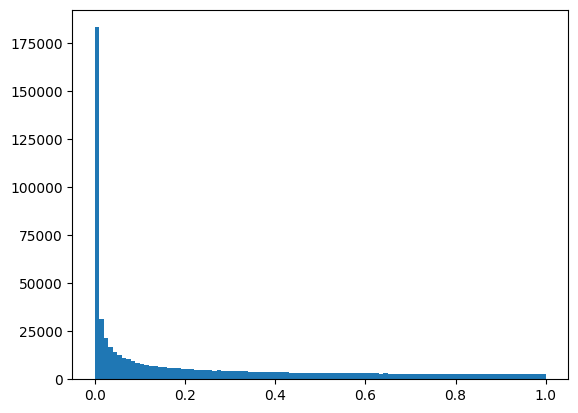

In [11]:
print(gm.values.min())
import matplotlib.pyplot as plt
plt.hist(gm.values.flatten(), bins=100)

In [12]:
gm.to_csv(f'../results_final_Dec22/granger_T.csv')